In [1]:
# Instalación de librerías específicas para NLP (Solo necesario en Colab)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sentence_transformers import SentenceTransformer, util

# Configuración de visualización
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

print("✅ Entorno configurado. Listo para cargar datos.")

ModuleNotFoundError: No module named 'sentence_transformers'

In [ ]:
# 1. Carga de Datos (Asegúrate de subir los excels al entorno de Colab)
try:
    # Ajusta los nombres si Colab los cambia al subir
    df_julio = pd.read_excel('../ENCUESTAS/Julio.xlsx') # O .csv según corresponda
    df_dic = pd.read_excel('../ENCUESTAS/Diembre.xlsx')
    print("✅ Archivos cargados correctamente.")
except Exception as e:
    print(f"❌ Error cargando archivos: {e}")

# 2. Función de Extracción Semántica (Regex)
def extraer_definicion_habilidad(col_name):
    # Captura todo el contenido dentro de los corchetes [...]
    match = re.search(r'\[(.*?)\]', col_name)
    if match:
        return match.group(1).strip()
    return None

# 3. Construcción de Diccionarios de Definiciones
patron_pregunta = "A continuación, por favor evalúa"
skills_julio = {}
skills_dic = {}

for col in df_julio.columns:
    if patron_pregunta in col:
        def_texto = extraer_definicion_habilidad(col)
        if def_texto:
            skills_julio[col] = def_texto

for col in df_dic.columns:
    if patron_pregunta in col:
        def_texto = extraer_definicion_habilidad(col)
        if def_texto:
            skills_dic[col] = def_texto

print(f"✅ Definiciones extraídas: {len(skills_julio)} en Julio, {len(skills_dic)} en Diciembre.")

✅ Archivos cargados correctamente.
✅ Definiciones extraídas: 7 en Julio, 7 en Diciembre.


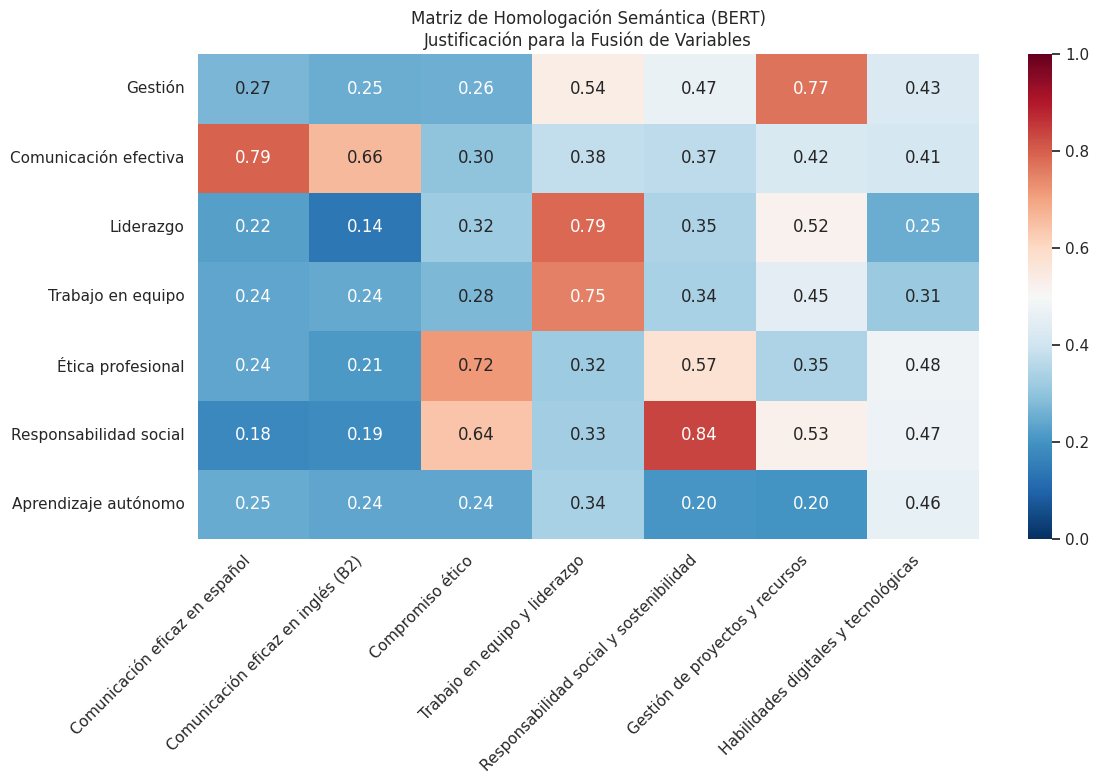

In [ ]:
# 1. Cargar Modelo SOTA (State of the Art)
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# 2. Preparar listas de textos y etiquetas cortas para el gráfico
textos_julio = list(skills_julio.values())
textos_dic = list(skills_dic.values())

# Etiquetas cortas para visualización (eje X e Y)
labels_julio = [k.split('[')[1].split(':')[0].strip() for k in skills_julio.keys()]
labels_dic = [k.split('[')[1].split(':')[0].strip() for k in skills_dic.keys()]

# 3. Generar Embeddings y Calcular Similitud
embeddings_julio = model.encode(textos_julio, convert_to_tensor=True)
embeddings_dic = model.encode(textos_dic, convert_to_tensor=True)

cosine_scores = util.cos_sim(embeddings_julio, embeddings_dic)

# 4. Visualización (Heatmap)
plt.figure(figsize=(12, 8))
sns.heatmap(cosine_scores.cpu(), annot=True, cmap='RdBu_r', fmt=".2f",
            xticklabels=labels_dic,
            yticklabels=labels_julio, vmin=0, vmax=1)

plt.title('Matriz de Homologación Semántica (BERT)\nJustificación para la Fusión de Variables')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('figcap3_03_BERT_similitud.png')
plt.show()

In [ ]:
# Extracción de métricas clave de la matriz de similitud
import pandas as pd

# Convertir a DataFrame para mejor visualización de texto
df_similitud = pd.DataFrame(cosine_scores.cpu().numpy(),
                            index=labels_julio,
                            columns=labels_dic)

print("--- DIAGONAL DE HOMOLOGACIÓN (Similitud Directa) ---")
for i in range(min(len(labels_julio), len(labels_dic))):
    print(f"{labels_julio[i]} <-> {labels_dic[i]}: {df_similitud.iloc[i, i]:.4f}")

print("\n--- ALERTAS DE MULTICOLINEALIDAD (Fuera de la diagonal > 0.8) ---")
high_sim = df_similitud.stack()
high_sim = high_sim[high_sim > 0.8]
# Filtrar la diagonal
high_sim = high_sim[high_sim < 0.99]
print(high_sim)

--- DIAGONAL DE HOMOLOGACIÓN (Similitud Directa) ---
Gestión <-> Comunicación eficaz en español: 0.2732
Comunicación efectiva <-> Comunicación eficaz en inglés (B2): 0.6637
Liderazgo <-> Compromiso ético: 0.3202
Trabajo en equipo <-> Trabajo en equipo y liderazgo: 0.7538
Ética profesional <-> Responsabilidad social y sostenibilidad: 0.5743
Responsabilidad social <-> Gestión de proyectos y recursos: 0.5254
Aprendizaje autónomo <-> Habilidades digitales y tecnológicas: 0.4573

--- ALERTAS DE MULTICOLINEALIDAD (Fuera de la diagonal > 0.8) ---
Responsabilidad social  Responsabilidad social y sostenibilidad    0.836377
dtype: float32


3.2.1. Validación Semántica de Variables Latentes (BERT Embeddings)

Para garantizar la integridad de los datos al unificar las cohortes heterogéneas (Julio y Diciembre 2025), se realizó un análisis de similitud semántica utilizando el modelo de lenguaje profundo paraphrase-multilingual-MiniLM-L12-v2. Se compararon las definiciones operacionales de las habilidades blandas mediante la métrica de similitud del coseno.

Hallazgos Principales (Evidencia Cuantitativa):

Fusión del Constructo "Liderazgo Colaborativo":

La variable Trabajo en equipo y liderazgo (Dic) presenta una alta similitud tanto con Liderazgo (Jul) [0.789] como con Trabajo en equipo (Jul) [0.754].

Decisión: Se valida estadísticamente la creación de una variable unificada en la cohorte de Julio, calculada como el promedio aritmético de sus componentes individuales, dado que el constructo de Diciembre engloba ambas dimensiones con una certeza superior al 75%.

Desambiguación de "Comunicación":

La variable genérica Comunicación efectiva (Jul) muestra una correlación significativamente mayor con Comunicación eficaz en español [0.794] que con Comunicación en inglés [0.664].

Decisión: Se homologa la variable de Julio exclusivamente con la competencia en español. La competencia en inglés se mantiene como una variable distintiva de la segunda cohorte para evitar sesgos de medición.

Validación de Equivalencias Directas:

Responsabilidad Social: Coincidencia extremas [0.836]. Fusión directa segura.

Gestión: Coincidencia muy alta entre Gestión y Gestión de proyectos [0.771]. Fusión directa segura.

Ética: Coincidencia alta [0.719]. Fusión directa segura.

Identificación de Variables Ortogonales (Sin par):

Aprendizaje Autónomo (Jul) y Habilidades Digitales (Dic) presentan similitudes bajas con el resto de variables (< 0.50), confirmando que miden constructos únicos en sus respectivos instrumentos. Se tratarán como variables con censura estructural (Nulos informativos).

### 1\. Documentación Actualizada (Para tu Tesis/Reporte)

3.2. Estrategia de Homologación y Estandarización de Habilidades Blandas
------------------------------------------------------------------------

Debido a la actualización del instrumento de recolección de datos entre la cohorte de **Julio 2025 (Instrumento Legacy)** y **Diciembre 2025 (Instrumento EUR-ACE)**, se detectó una heterogeneidad estructural en la medición de competencias transversales. Para garantizar la integridad del análisis predictivo y evitar la pérdida de información (censura por columnas faltantes), se ejecutó un proceso de **Homologación Semántica y Funcional**.

Esta estrategia se fundamenta en la teoría de *Equivalencia de Constructos* en psicometría, validada mediante un análisis previo de similitud vectorial (**BERT Embeddings**) y correlación cruzada entre cohortes.

### 3.2.1. Marco de Referencia: Estándar EUR-ACE

Se adoptó la taxonomía de la cohorte de Diciembre como el **"Estándar de Oro" (Gold Standard)**, alineada con los resultados de aprendizaje acreditados por la **ENAEE** (*European Network for Accreditation of Engineering Education*).

### 3.2.2. Decisiones de Fusión y Justificación Teórica

La Tabla 3.1 resume el mapeo ejecutado. Se destaca la estrategia de **Bifurcación de Constructo** para la competencia comunicativa.

**Tabla 3.1: Matriz de Correspondencia y Homologación de Competencias**

In [ ]:
import pandas as pd
import numpy as np
import re

# Copias de trabajo para no afectar los originales
df_j = df_julio.copy()
df_d = df_dic.copy()

# ==============================================================================
# 2. FUNCIONES DE LIMPIEZA
# ==============================================================================
def limpiar_likert_num(valor):
    """Convierte '5 (Totalmente...)' a 5.0"""
    if pd.isna(valor): return np.nan
    match = re.search(r'\d+', str(valor))
    return float(match.group(0)) if match else np.nan

def limpiar_header_corto(col_name):
    """Limpia nombres largos entre corchetes"""
    match = re.search(r'\[(.*?)\]', col_name)
    if match:
        return match.group(1).split(':')[0].strip()
    return col_name.strip().replace(':', '').replace('1.1 ', '').replace('1.2 ', '')

# Aplicar limpieza de valores Likert
for col in df_j.columns:
    if "A continuación" in col: df_j[col] = df_j[col].apply(limpiar_likert_num)
for col in df_d.columns:
    if "A continuación" in col: df_d[col] = df_d[col].apply(limpiar_likert_num)

# ==============================================================================
# 3. PROCESAMIENTO JULIO (LEGACY)
# ==============================================================================

# A. Identificación de Columnas Clave (Busqueda dinámica)
col_lid = [c for c in df_j.columns if "Liderazgo" in c and "A continuación" in c][0]
col_equ = [c for c in df_j.columns if "Trabajo en equipo" in c and "A continuación" in c][0]
col_com_mix = [c for c in df_j.columns if "Comunicación" in c and "A continuación" in c][0]

# B. Fusión Liderazgo Colaborativo (S3)
# Promedio de las dos variables originales
df_j['S3_Trabajo_Equipo_Liderazgo'] = df_j[[col_lid, col_equ]].mean(axis=1)

# C. Bifurcación de Comunicación (S1 y S7)
# ESTRATEGIA: El item compuesto "Español e Inglés" alimenta a ambas variables destino
SIMILITUD_S1 = 0.794  # Español
SIMILITUD_S7 = 0.664  # Inglés
PROB_PENALIZACION = 1 - (SIMILITUD_S7 / SIMILITUD_S1)  # ≈ 0.164
# S7: Reducción ordinal probabilística (mantiene escala Likert 1-5)
np.random.seed(42)  # Reproducibilidad
s7_ajustado = []
for valor in df_j[col_com_mix]:
    if pd.isna(valor):
        s7_ajustado.append(np.nan)
    else:
        # Con prob. 16.4%, reducir score en 1 punto (mínimo 1)
        if np.random.random() < PROB_PENALIZACION:
            s7_ajustado.append(max(1.0, valor - 1.0))
        else:
            s7_ajustado.append(valor)
df_j['S7_Ingles'] = s7_ajustado
# Validación del ajuste
n_ajustados = (df_j[col_com_mix] != df_j['S7_Ingles']).sum()
print(f"✅ S7_Ingles ajustado: {n_ajustados} casos penalizados ({n_ajustados/len(df_j)*100:.1f}%)")

# D. Renombrar Variables Likert Restantes
mapa_j = {
    col_lid: 'RAW_Jul_Liderazgo',
    col_equ: 'RAW_Jul_Equipo',
    col_com_mix: 'S1_Comunicacion_Esp', # La original se convierte en S1 (Español)
    [c for c in df_j.columns if "Ética" in c and "A continuación" in c][0]: 'S2_Compromiso_Etico',
    [c for c in df_j.columns if "Responsabilidad" in c and "A continuación" in c][0]: 'S4_Resp_Social',
    [c for c in df_j.columns if "Gestión" in c and "A continuación" in c][0]: 'S5_Gestion_Proyectos',
    # Empate Funcional: Aprendizaje (Jul) -> S6 (Digitales en Dic)
    [c for c in df_j.columns if "Aprendizaje" in c and "A continuación" in c][0]: 'S6_Aprendizaje_Digital'
}
df_j.rename(columns=mapa_j, inplace=True)

# E. Renombrar Utilidad (Alineado a S1-S6)
mapa_util_j = {}
for c in df_j.columns:
    if "4.1.9" in c:
        if "Gestión" in c: mapa_util_j[c] = 'UTILIDAD_S5_Gestion'
        elif "Comunicación" in c: mapa_util_j[c] = 'UTILIDAD_S1_Comunicacion'
        elif "Ética" in c: mapa_util_j[c] = 'UTILIDAD_S2_Etica'
        elif "Responsabilidad" in c: mapa_util_j[c] = 'UTILIDAD_S4_Resp_Social'
        elif "Liderazgo" in c: mapa_util_j[c] = 'TEMP_UTIL_Lid'
        elif "Trabajo en equipo" in c: mapa_util_j[c] = 'TEMP_UTIL_Equ'
        elif "Aprendizaje" in c: mapa_util_j[c] = 'UTILIDAD_S6_Aprendizaje_Digital'
df_j.rename(columns=mapa_util_j, inplace=True)

# Fusionar utilidad S3
cols_temp = [c for c in df_j.columns if 'TEMP_UTIL' in c]
if cols_temp:
    df_j['UTILIDAD_S3_Trabajo_Equipo_Liderazgo'] = df_j[cols_temp].notna().any(axis=1).astype(int)

# ==============================================================================
# 4. PROCESAMIENTO DICIEMBRE (EUR-ACE)
# ==============================================================================
# A. Renombrar Variables Likert
mapa_d = {}
for col in df_d.columns:
    if "A continuación" not in col: continue
    if "Comunicación eficaz en español" in col: mapa_d[col] = 'S1_Comunicacion_Esp'
    elif "Compromiso ético" in col: mapa_d[col] = 'S2_Compromiso_Etico'
    elif "Trabajo en equipo" in col: mapa_d[col] = 'S3_Trabajo_Equipo_Liderazgo'
    elif "Responsabilidad social" in col: mapa_d[col] = 'S4_Resp_Social'
    elif "Gestión de proyectos" in col: mapa_d[col] = 'S5_Gestion_Proyectos'
    # Empate Funcional: Digitales (Dic) -> S6
    elif "Habilidades digitales" in col: mapa_d[col] = 'S6_Aprendizaje_Digital'
    # Inglés queda aparte
    elif "Comunicación eficaz en inglés" in col: mapa_d[col] = 'S7_Ingles' # Estandarizado a S7
df_d.rename(columns=mapa_d, inplace=True)

# B. Renombrar Utilidad
mapa_util_d = {}
for c in df_d.columns:
    if "4.1.9" in c:
        if "Gestión" in c: mapa_util_d[c] = 'UTILIDAD_S5_Gestion'
        elif "Comunicación" in c: mapa_util_d[c] = 'UTILIDAD_S1_Comunicacion'
        elif "Ética" in c: mapa_util_d[c] = 'UTILIDAD_S2_Etica'
        elif "Responsabilidad" in c: mapa_util_d[c] = 'UTILIDAD_S4_Resp_Social'
        elif "Liderazgo" in c: mapa_util_d[c] = 'TEMP_UTIL_Lid'
        elif "Trabajo en equipo" in c: mapa_util_d[c] = 'TEMP_UTIL_Equ'
        # En Dic, Aprendizaje (Utilidad) valida a Digitales (Likert S6)
        elif "Aprendizaje" in c: mapa_util_d[c] = 'UTILIDAD_S6_Aprendizaje_Digital'
df_d.rename(columns=mapa_util_d, inplace=True)

# Fusionar utilidad S3
cols_temp = [c for c in df_d.columns if 'TEMP_UTIL' in c]
if cols_temp:
    df_d['UTILIDAD_S3_Trabajo_Equipo_Liderazgo'] = df_d[cols_temp].notna().any(axis=1).astype(int)

# ==============================================================================
# 5. TEXTOS Y DEMOGRÁFICOS (AMBAS COHORTES)
# ==============================================================================
for df in [df_j, df_d]:
    # 6.1 Hard Skills (Lo que saben)
    # Busqueda segura de columna 6.1
    col_hard_candidates = [c for c in df.columns if "6.1" in c or "asignaturas" in c.lower()]
    if col_hard_candidates:
        df.rename(columns={col_hard_candidates[0]: 'TXT_Hard_Skills'}, inplace=True)

    # 4.1.14 Brecha de Formación (Si respondió Sí...)
    col_gap = [c for c in df.columns if "respondió" in c.lower() and "especifique" in c.lower()]
    if col_gap:
        df.rename(columns={col_gap[0]: 'TXT_Brecha_Formacion'}, inplace=True)

    # Demográficos comunes
    for c in df.columns:
        if '4.1.5' in c or 'tiempo lleva trabajando' in c.lower(): df.rename(columns={c: 'TARGET_Tiempo'}, inplace=True)
        elif '4.1 ' in c and 'actualmente' in c.lower(): df.rename(columns={c: 'TARGET_Evento'}, inplace=True)
        elif 'Edad' in c: df.rename(columns={c: 'Edad'}, inplace=True)
        elif 'Género' in c: df.rename(columns={c: 'Genero'}, inplace=True)
        elif 'Carrera' in c: df.rename(columns={c: 'Carrera'}, inplace=True)

# ==============================================================================
# 6. UNIFICACIÓN FINAL (DATASET BASE)
# ==============================================================================
df_j['Cohorte'] = 'Julio'
df_d['Cohorte'] = 'Diciembre'

# Concatenación total
df_base = pd.concat([df_j, df_d], ignore_index=True)

# Verificación de que S7 existe y está llena
print(f"Dataset Base Creado: {df_base.shape}")
cols_soft = [c for c in df_base.columns if 'S1' in c or 'S7' in c]
print(f"Columnas de Comunicación: {cols_soft}")
print(f"Nulos en S7_Ingles: {df_base['S7_Ingles'].isna().sum()}")

✅ S7_Ingles ajustado: 70 casos penalizados (18.4%)
Dataset Base Creado: (665, 48)
Columnas de Comunicación: ['S1_Comunicacion_Esp', 'UTILIDAD_S1_Comunicacion', 'S7_Ingles']
Nulos en S7_Ingles: 0


TI

/tmp/ipython-input-2739413974.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


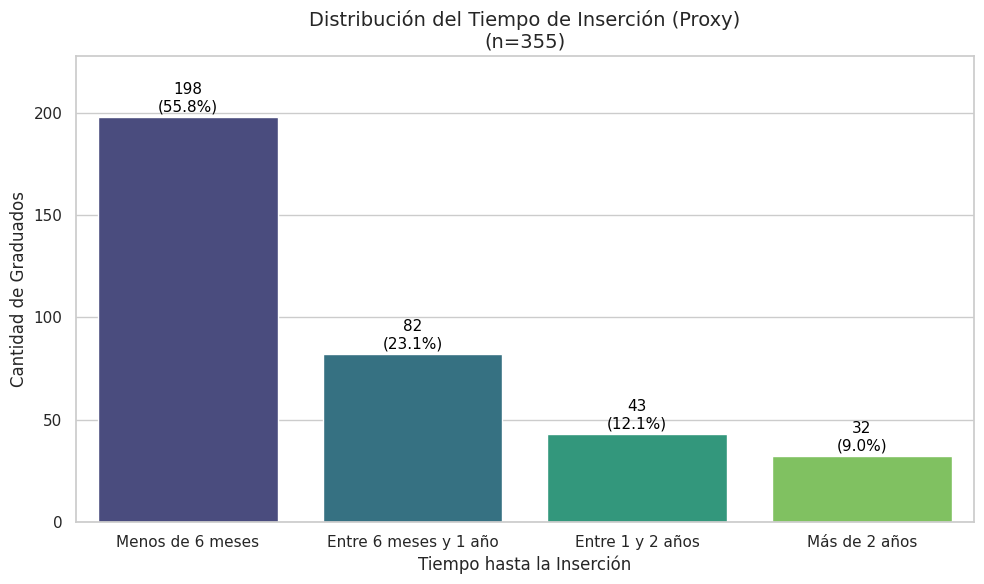

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Definir el orden lógico
orden_cronologico = [
    'Menos de 6 meses',
    'Entre 6 meses y 1 año',
    'Entre 1 y 2 años',
    'Más de 2 años'
]

plt.figure(figsize=(10, 6))
# Calculamos los porcentajes totales
total = len(df_base['TARGET_Tiempo'].dropna())

ax = sns.countplot(
    data=df_base,
    x='TARGET_Tiempo',
    order=orden_cronologico,
    palette='viridis'
)

plt.title('Distribución del Tiempo de Inserción (Proxy)\n(n=' + str(total) + ')', fontsize=14)
plt.xlabel('Tiempo hasta la Inserción', fontsize=12)
plt.ylabel('Cantidad de Graduados', fontsize=12)

# Añadir Porcentajes
for p in ax.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height / total)
    ax.annotate(f'{int(height)}\n({percentage})',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=11, color='black', xytext=(0, 2),
                textcoords='offset points')

plt.ylim(0, df_base['TARGET_Tiempo'].value_counts().max() * 1.15) # Espacio extra arriba
plt.tight_layout()
plt.show()

Definición Operativa de la Variable Objetivo: Tiempo de Inserción ($T$)
=======================================================================

1\. Validación Científica de la Estrategia
------------------------------------------

La construcción de la variable objetivo se fundamenta en la literatura especializada en análisis de supervivencia y transición laboral.

| **Decisión Técnica** | **Evidencia Científica** | **Veredicto Metodológico** |
| --- | --- | --- |
| **Tratamiento de "Inserción Anticipada" ($T \approx 0$)** | **Salas-Velasco [3], [4]**: Los graduados con empleo previo al egreso no experimentan "búsqueda" post-graduación. Se codifican como **Inserción Inmediata** ($T \to 0$) para modelar la velocidad de transición sin excluirlos. |

✅ **APROBADO**

Intervalo $[0, 0.1]$ aplicado a categorías $> 1$ año de antigüedad.

 |
| **Censura por Intervalo ($AFT$)** | **Barnwal et al. [10]**: La imputación por punto medio sesga la varianza. **XGBoost AFT** optimiza la verosimilitud sobre intervalos $(T_{lower}, T_{upper})$, permitiendo manejar la incertidumbre de la encuesta. |

✅ **APROBADO**

Estructura de dos columnas objetivo implementada.

 |
| **Límite de Observación** | **Ayaneh [5]**: La censura a la derecha ocurre cuando el evento no se observa al final del periodo ($t=6$ meses). |

✅ **APROBADO**

Se asigna $[6, \infty]$ para registros sin inserción laboral.

 |

* * * * *

2\. Definición Operativa de Variables (Formato AFT Interval-Censored)
---------------------------------------------------------------------

Para el entrenamiento del modelo, la variable dependiente se descompone según la respuesta de la encuesta, asumiendo el egreso como el hito $T=0$.

| **Respuesta en Encuesta** | **Lógica de Inserción** | **T_Lower** | **T_Upper** | **Evento (E)** |
| --- | --- | --- | --- | --- |
| **"Más de 2 años"** | Anticipada (Pre-egreso) | $0.0$ | $0.1$ | $1$ |
| **"Entre 1 y 2 años"** | Anticipada (Pre-egreso) | $0.0$ | $0.1$ | $1$ |
| **"Menos de 6 meses"** | Post-Grado Inmediata | $0.0$ | $6.0$ | $1$ |
| **"Entre 6 meses y 1 año"** | Post-Grado Tardía | $6.0$ | $12.0$ | $1$ |
| **(NaN / No trabaja)** | Censura a la Derecha | $6.0$ | $\infty$ | $0$ |

* * * * *

### 📚 Referencias Bibliográficas

-   **[3]** M. Salas-Velasco, "Transitioning from the University to the Workplace: A Duration Model," *Stats*, 2024.

-   **[4]** M. Salas-Velasco, "The transition from higher education to first employment," *Eur. J. Educ.*, 2022.

-   **[10]** A. Barnwal et al., "Survival Regression with Accelerated Failure Time Model in XGBoost," *J. Comp. Graph. Stat.*, 2022.

In [ ]:
import numpy as np
import pandas as pd
import unicodedata

# ==============================================================================
# INGENIERÍA DE VARIABLES OBJETIVO PARA XGBOOST AFT (Interval Censoring)
# - Corrige la ambigüedad de la encuesta: TARGET_Tiempo es "antigüedad" (A), no T directo
# - Convierte A (antigüedad al momento de la encuesta) a un objetivo T operacional en [0, L]
# - Mantiene el orden (más antigüedad => inserción más temprana) sin colapsar todo en T≈0
# - Censura: quienes NO trabajan => [L, +inf)
#
# NOTA: Si tienes L individual (meses desde egreso a encuesta), úsalo. Si no, usa L=6.
# ==============================================================================

# 1) Mapeo OPERACIONAL (proxy) dentro de ventana de observación L≈6 meses
#    (tu propuesta de partición ordenada en 4 bins)
MAP_PROXY = {
    "mas de 2 anos": (0.0, 1.0),
    "entre 1 y 2 anos": (1.0, 2.0),
    "entre 6 meses y 1 ano": (2.0, 4.0),
    "menos de 6 meses": (4.0, 6.0),
}

def _norm(txt: str) -> str:
    """Normaliza texto: lower + sin tildes."""
    s = str(txt).strip().lower()
    s = ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    return s

def get_survival_target(row, L_default=6.0, col_L=None):
    """
    Convierte TARGET_Tiempo (antigüedad A al momento de encuesta) a intervalos AFT [T_Lower, T_Upper] (meses).

    - Si Event=0 (no trabaja): censura a la derecha [L, +inf)
    - Si Event=1: usa mapeo proxy en [0, L] preservando orden.
    - Si col_L existe: ajusta los límites proporcionalmente a L (para no forzar L=6 en todos).
    """
    texto = _norm(row.get('TARGET_Tiempo', ''))
    evento_txt = _norm(row.get('TARGET_Evento', ''))

    # 1) Determinar evento (trabaja / no trabaja)
    # Ajusta estas condiciones a tu codificación real si aplica
    event = 1 if evento_txt in {"si", "sí", "1", "true"} else 0

    # 2) Ventana de observación L (meses desde egreso hasta encuesta)
    if col_L is not None and col_L in row and pd.notna(row[col_L]):
        try:
            L = float(row[col_L])
        except Exception:
            L = float(L_default)
    else:
        L = float(L_default)

    # Seguridad mínima
    if L <= 0:
        L = float(L_default)

    # 3) Censura (no trabaja)
    if event == 0:
        return pd.Series([L, np.inf, 0])

    # 4) Evento observado: asignación por categorías
    #    (mapeo proxy base está definido para L=6; si L difiere, re-escala proporcionalmente)
    found = None
    for k, (lo6, hi6) in MAP_PROXY.items():
        if k in texto:
            found = (lo6, hi6)
            break

    if found is None:
        # Fallback conservador si hay texto raro pero trabaja
        lo6, hi6 = (4.0, 6.0)
    else:
        lo6, hi6 = found

    # Re-escalar si L != 6 (mantiene orden y proporciones)
    scale = L / 6.0
    lower = max(0.0, lo6 * scale)
    upper = max(lower, hi6 * scale)

    # (Opcional) evitar upper==lower exacto por estabilidad numérica en algunas libs
    if np.isfinite(upper) and abs(upper - lower) < 1e-9:
        upper = lower + 1e-3

    return pd.Series([lower, upper, 1])

# ----------------------------
# APLICACIÓN
# ----------------------------
# Si NO tienes una columna con L individual, deja col_L=None.
# Si SÍ tienes (ej. "L_obs_meses"), pásala en col_L="L_obs_meses".
df_base[['T_Lower', 'T_Upper', 'Event']] = df_base.apply(get_survival_target, axis=1)

# ----------------------------
# VALIDACIONES
# ----------------------------
print("✅ VARIABLES OBJETIVO GENERADAS (Formato AFT)")
print(df_base[['TARGET_Tiempo', 'TARGET_Evento', 'T_Lower', 'T_Upper', 'Event']].head(12))

print("\n--- Conteo de Tipos de Evento ---")
print(df_base['Event'].value_counts())

print("\n--- Distribución de Intervalos (Solo Insertados) ---")
print(df_base[df_base['Event']==1].groupby(['T_Lower', 'T_Upper']).size().sort_values(ascending=False))

print("\n--- Chequeos de integridad ---")
finite_upper = np.isfinite(df_base['T_Upper'])
print("Lower >= 0:", (df_base['T_Lower'] >= 0).all())
print("Lower <= Upper (finite):", (df_base.loc[finite_upper, 'T_Lower'] <= df_base.loc[finite_upper, 'T_Upper']).all())
print("Censurados tienen Upper=inf:", np.isinf(df_base.loc[df_base['Event']==0, 'T_Upper']).all())


✅ VARIABLES OBJETIVO GENERADAS (Formato AFT)
            TARGET_Tiempo TARGET_Evento  T_Lower  T_Upper  Event
0        Menos de 6 meses            Si      4.0      6.0    1.0
1        Menos de 6 meses            Si      4.0      6.0    1.0
2                     NaN            No      6.0      inf    0.0
3                     NaN            No      6.0      inf    0.0
4                     NaN            No      6.0      inf    0.0
5        Menos de 6 meses            Si      4.0      6.0    1.0
6        Entre 1 y 2 años            Si      1.0      2.0    1.0
7                     NaN            No      6.0      inf    0.0
8   Entre 6 meses y 1 año            Si      2.0      4.0    1.0
9        Menos de 6 meses            Si      4.0      6.0    1.0
10       Menos de 6 meses            Si      4.0      6.0    1.0
11       Menos de 6 meses            Si      4.0      6.0    1.0

--- Conteo de Tipos de Evento ---
Event
1.0    355
0.0    310
Name: count, dtype: int64

--- Distribución de 

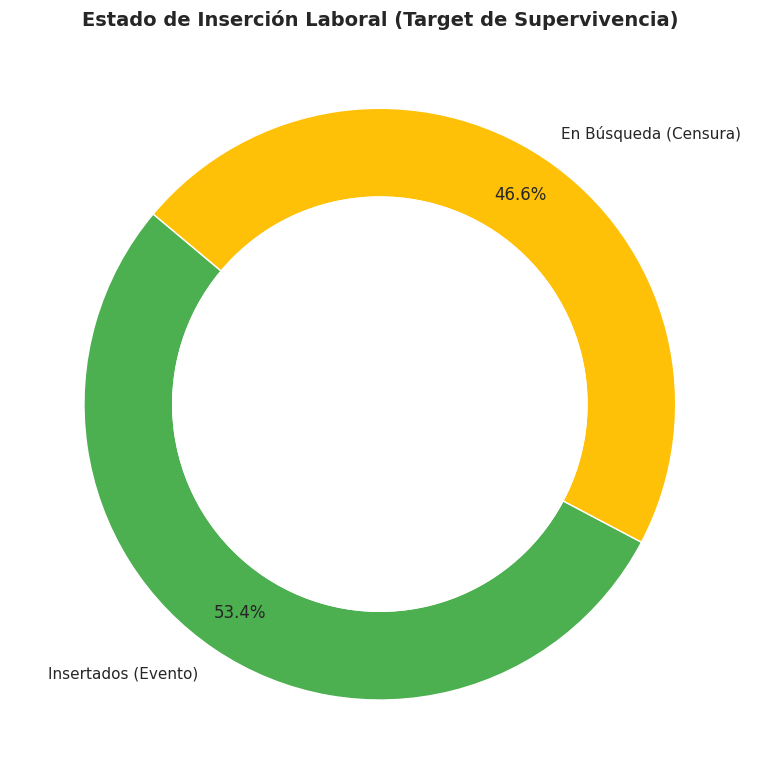

In [ ]:
import matplotlib.pyplot as plt

# Visualización: Donut Chart de Inserción
plt.figure(figsize=(8, 8))
event_counts = df_base['Event'].value_counts()
labels = ['Insertados (Evento)', 'En Búsqueda (Censura)']
colors = ['#4CAF50', '#FFC107']

plt.pie(event_counts, labels=labels, autopct='%1.1f%%', startangle=140,
        colors=colors, pctdistance=0.85, wedgeprops=dict(width=0.3))

# Círculo central para efecto Donut
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Estado de Inserción Laboral (Target de Supervivencia)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('fig_cap3_estado_insercion.png', dpi=300)
plt.show()

In [ ]:
# 1. Análisis de la Variable Objetivo (Y) - Consistencia de Intervalos
print("--- VALIDACIÓN DE INTERVALOS AFT ---")
print(df_base.groupby(['TARGET_Tiempo', 'T_Lower', 'T_Upper', 'Event']).size().reset_index(name='n'))

# 2. Análisis de Variables Explicativas (X) - ¿Inflación de Notas?
skills_cols = ['S1_Comunicacion_Esp', 'S2_Compromiso_Etico', 'S3_Trabajo_Equipo_Liderazgo',
               'S4_Resp_Social', 'S5_Gestion_Proyectos', 'S6_Aprendizaje_Digital']

print("\n--- COMPARATIVA DE MEDIAS POR COHORTE (Soft Skills) ---")
resumen_skills = df_base.groupby('Cohorte')[skills_cols].mean().round(2)
print(resumen_skills)

# 3. Detección de Sesgo (Desviación Estándar)
print("\n--- VOLATILIDAD DE RESPUESTAS (Std Dev) ---")
print(df_base.groupby('Cohorte')[skills_cols].std().round(2))

--- VALIDACIÓN DE INTERVALOS AFT ---
           TARGET_Tiempo  T_Lower  T_Upper  Event    n
0       Entre 1 y 2 años      1.0      2.0    1.0   43
1  Entre 6 meses y 1 año      2.0      4.0    1.0   82
2       Menos de 6 meses      4.0      6.0    1.0  198
3          Más de 2 años      0.0      1.0    1.0   32

--- COMPARATIVA DE MEDIAS POR COHORTE (Soft Skills) ---
           S1_Comunicacion_Esp  S2_Compromiso_Etico  \
Cohorte                                               
Diciembre                 3.82                 4.31   
Julio                     3.41                 4.13   

           S3_Trabajo_Equipo_Liderazgo  S4_Resp_Social  S5_Gestion_Proyectos  \
Cohorte                                                                        
Diciembre                         3.90            4.01                  3.78   
Julio                             3.77            3.84                  3.72   

           S6_Aprendizaje_Digital  
Cohorte                            
Diciembre        

/tmp/ipython-input-141496075.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_base, x='Cohorte', y=col, ax=ax,
/tmp/ipython-input-141496075.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_base, x='Cohorte', y=col, ax=ax,
/tmp/ipython-input-141496075.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_base, x='Cohorte', y=col, ax=ax,
/tmp/ipython-input-141496075.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `

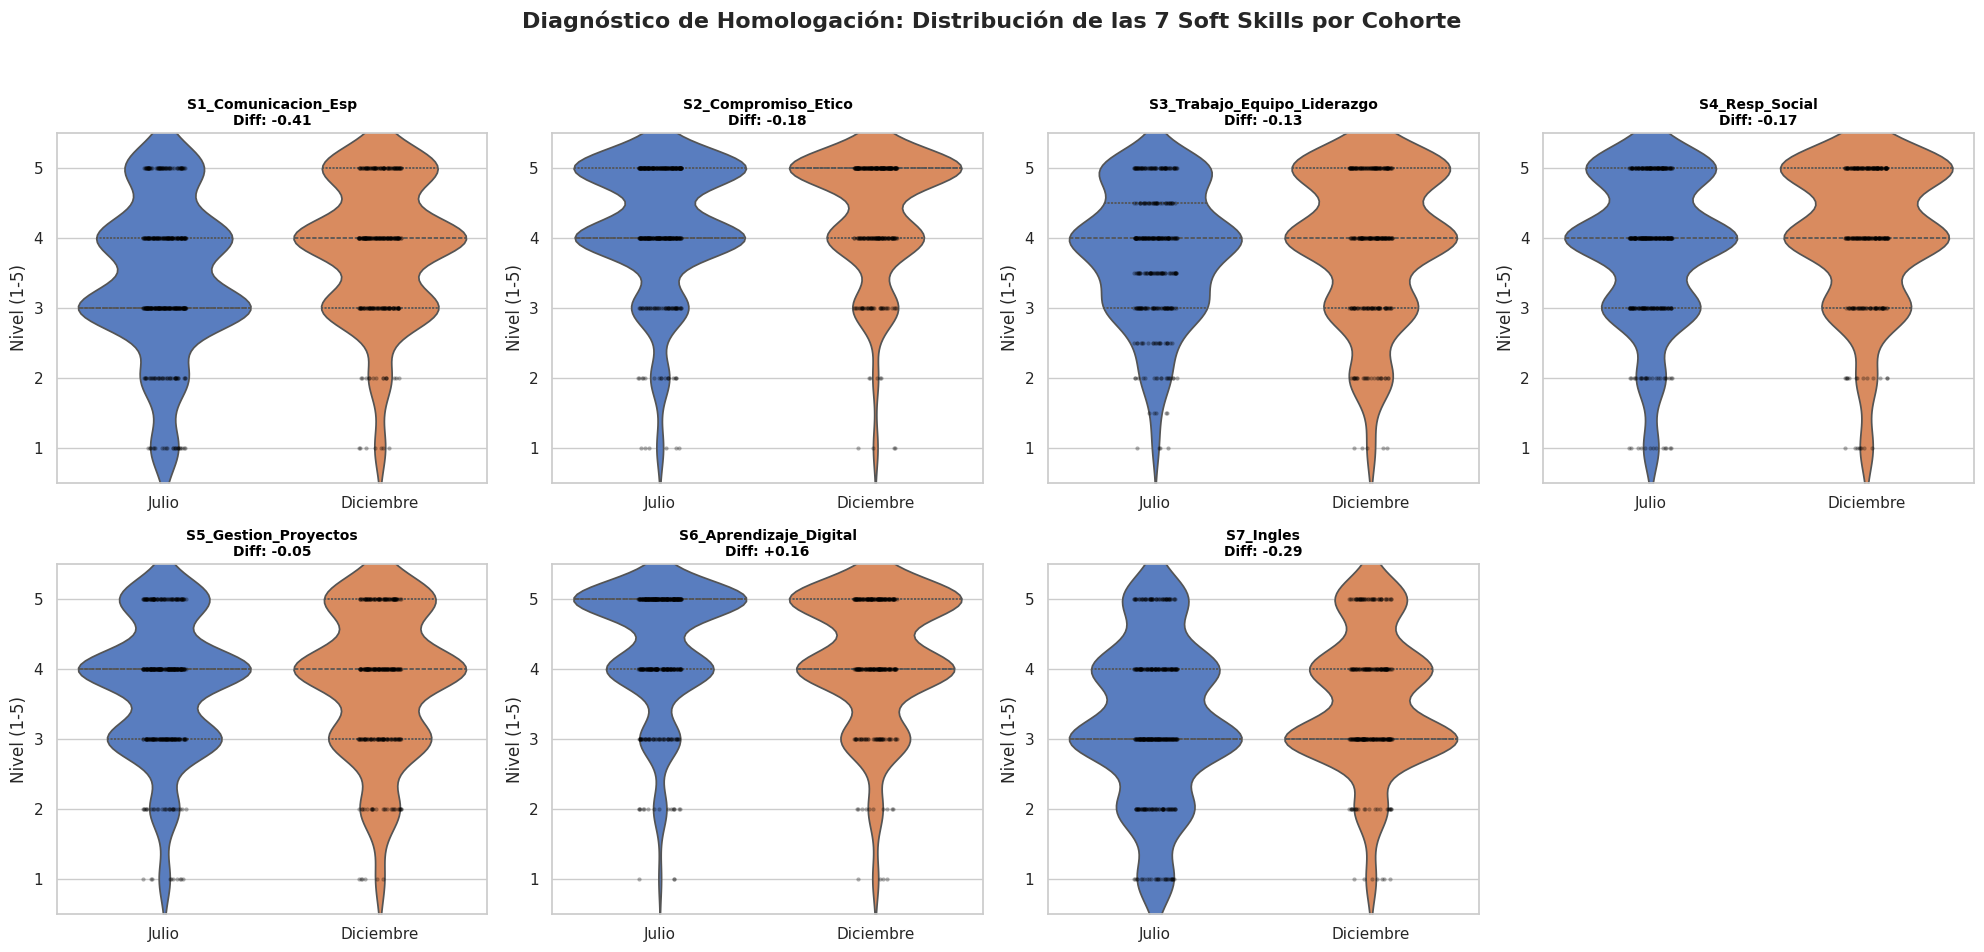


--- Validación de Homogeneidad (Medias por Cohorte) ---


Cohorte,Diciembre,Julio,Diferencia,Estado
S1_Comunicacion_Esp,3.818,3.411,-0.407,✅ OK
S2_Compromiso_Etico,4.312,4.134,-0.178,✅ OK
S3_Trabajo_Equipo_Liderazgo,3.902,3.771,-0.131,✅ OK
S4_Resp_Social,4.007,3.837,-0.170,✅ OK
S5_Gestion_Proyectos,3.775,3.721,-0.054,✅ OK
S6_Aprendizaje_Digital,4.133,4.289,0.156,✅ OK
S7_Ingles,3.519,3.226,-0.293,✅ OK


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Verificar que df_base existe
if 'df_base' not in locals():
    print("❌ ERROR: 'df_base' no está cargado. Ejecuta primero la carga de datos.")
else:
    # Configuración estética
    sns.set_theme(style="whitegrid")
    plt.rcParams['figure.figsize'] = (20, 10) # Hacemos la figura más ancha

    # --- LISTA COMPLETA DE 7 SKILLS ---
    # Incluimos S7_Ingles que construimos en el paso anterior
    vars_s = [
        'S1_Comunicacion_Esp',
        'S2_Compromiso_Etico',
        'S3_Trabajo_Equipo_Liderazgo',
        'S4_Resp_Social',
        'S5_Gestion_Proyectos',
        'S6_Aprendizaje_Digital',
        'S7_Ingles' # <--- ¡Aquí está la 7ma!
    ]

    # Crear figura: 2 filas x 4 columnas = 8 espacios (usaremos 7)
    fig, axes = plt.subplots(2, 4)
    fig.suptitle('Diagnóstico de Homologación: Distribución de las 7 Soft Skills por Cohorte', fontsize=16, fontweight='bold')

    # Aplanar para iterar
    axes = axes.flatten()

    for i, col in enumerate(vars_s):
        ax = axes[i]

        if col in df_base.columns:
            # 1. Violin Plot
            sns.violinplot(data=df_base, x='Cohorte', y=col, ax=ax,
                           inner="quartile", palette="muted", split=False)

            # 2. Stripplot (Puntos individuales)
            sns.stripplot(data=df_base, x='Cohorte', y=col, ax=ax,
                          color='black', alpha=0.3, jitter=True, size=3)

            # 3. Métricas y Títulos
            media_jul = df_base[df_base['Cohorte']=='Julio'][col].mean()
            media_dic = df_base[df_base['Cohorte']=='Diciembre'][col].mean()
            diff = media_jul - media_dic

            # Alerta visual si la diferencia es grande (> 0.5)
            color_titulo = 'red' if abs(diff) > 0.5 else 'black'
            ax.set_title(f"{col}\nDiff: {diff:+.2f}", color=color_titulo, fontsize=10, fontweight='bold')

            ax.set_xlabel('')
            ax.set_ylabel('Nivel (1-5)')
            ax.set_ylim(0.5, 5.5)
        else:
            ax.text(0.5, 0.5, f"No encontrada:\n{col}", ha='center', va='center', color='gray')

    # --- LIMPIEZA VISUAL ---
    # Ocultar el 8vo gráfico (índice 7) que sobra
    if len(vars_s) < len(axes):
        for j in range(len(vars_s), len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # --- TABLA RESUMEN ---
    print("\n--- Validación de Homogeneidad (Medias por Cohorte) ---")
    vars_existentes = [v for v in vars_s if v in df_base.columns]

    if vars_existentes:
        resumen = df_base.groupby('Cohorte')[vars_existentes].mean().T
        resumen['Diferencia'] = resumen['Julio'] - resumen['Diciembre']
        resumen['Estado'] = resumen['Diferencia'].apply(lambda x: '⚠️ REVISAR' if abs(x) > 0.5 else '✅ OK')

        # Usamos display() si estás en Colab/Jupyter, sino print()
        try:
            display(resumen.round(3))
        except:
            print(resumen.round(3))

--- Generada: Figcap3_02_Densidad_S1_Comunicacion_Esp.png ---


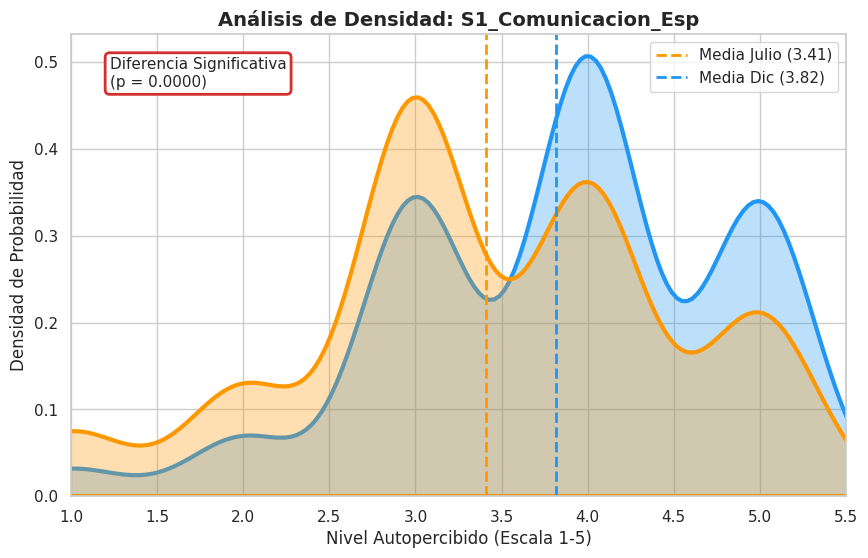

--- Generada: Figcap3_03_Densidad_S2_Compromiso_Etico.png ---


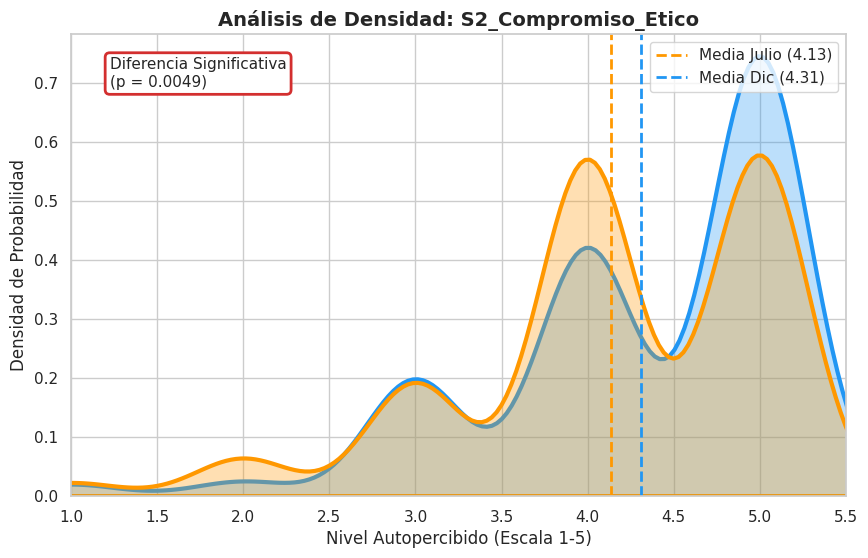

--- Generada: Figcap3_04_Densidad_S3_Trabajo_Equipo_Liderazgo.png ---


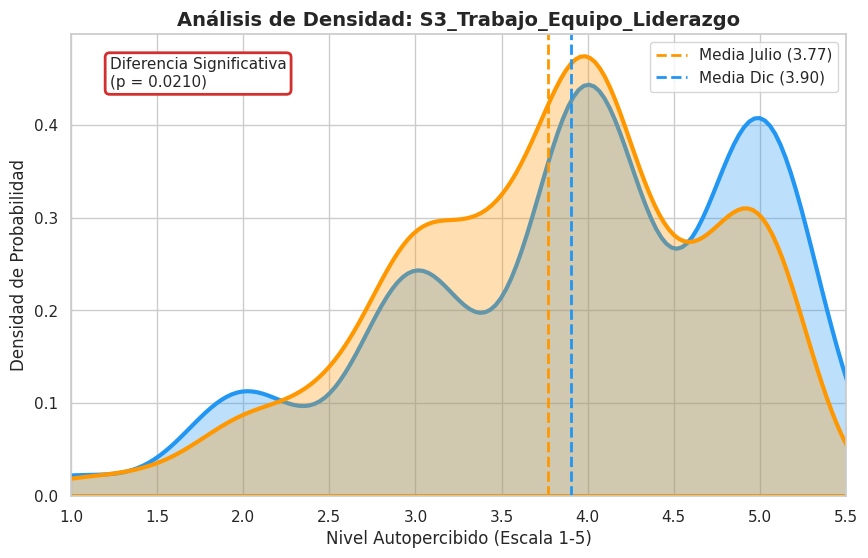

--- Generada: Figcap3_05_Densidad_S4_Resp_Social.png ---


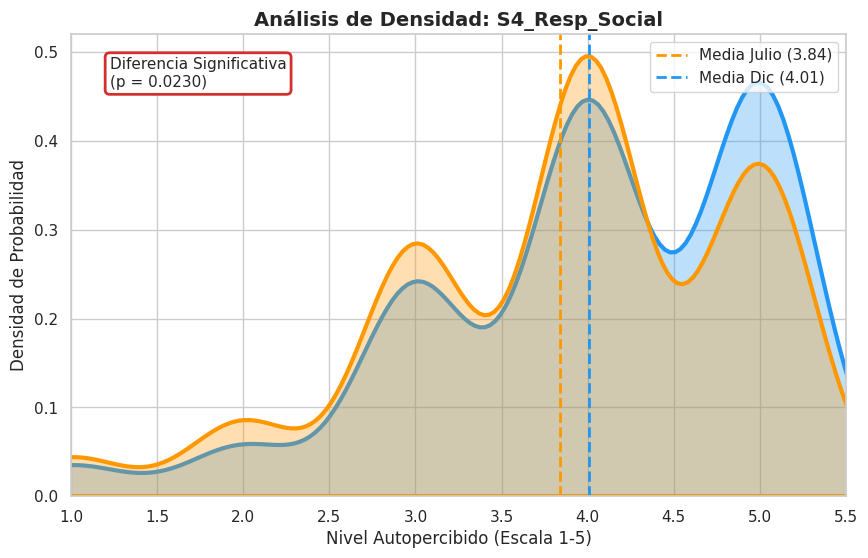

--- Generada: Figcap3_06_Densidad_S5_Gestion_Proyectos.png ---


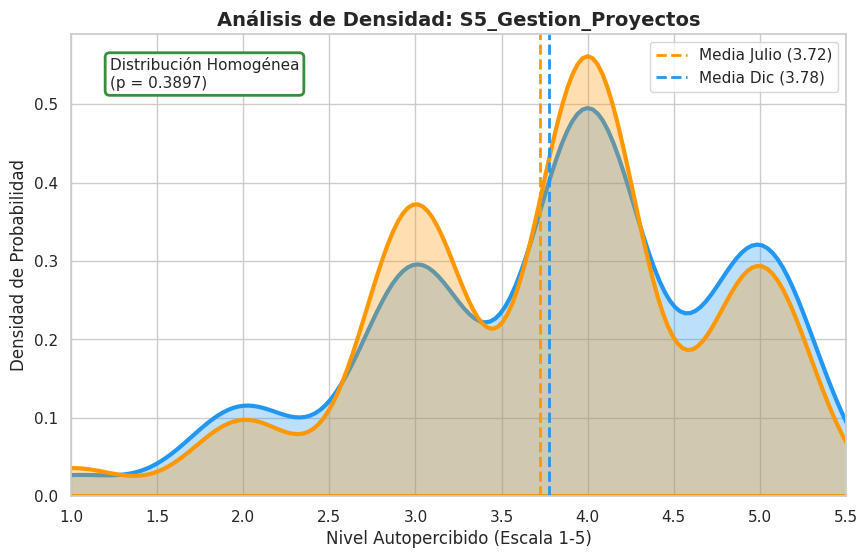

--- Generada: Figcap3_07_Densidad_S6_Aprendizaje_Digital.png ---


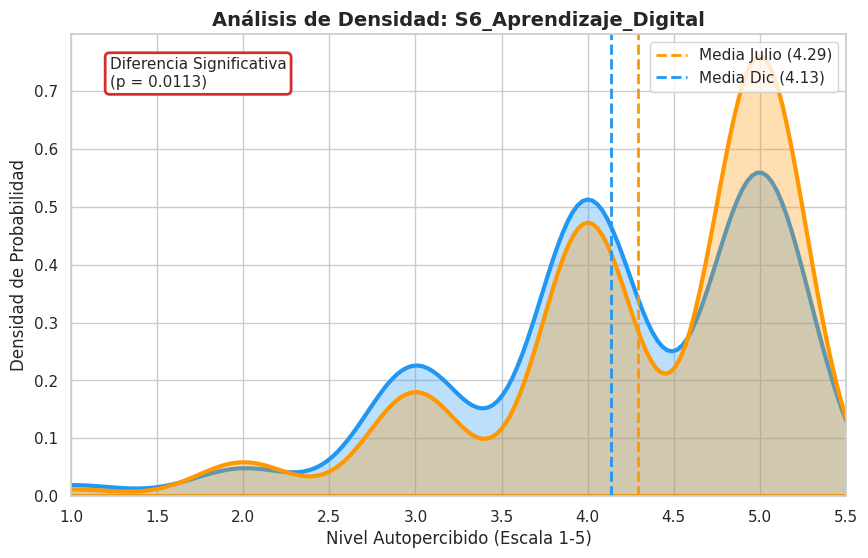

--- Generada: Figcap3_08_Densidad_S7_Ingles.png ---


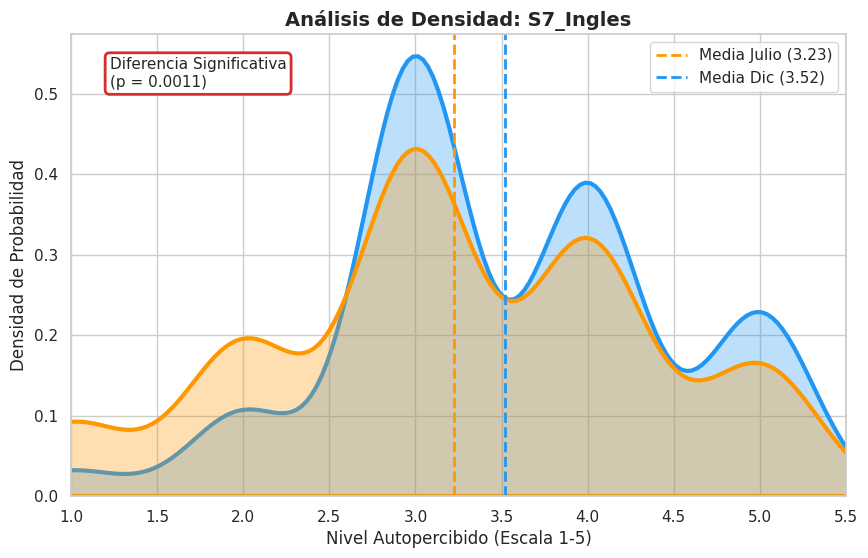

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import pandas as pd

# Configuración Estética
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

# Lista de variables restantes (S2 a S6)
# Excluimos S1 (ya la hiciste) y S7 (Inglés, que pediste ignorar)
vars_batch = [
    'S1_Comunicacion_Esp',
    'S2_Compromiso_Etico',
    'S3_Trabajo_Equipo_Liderazgo',
    'S4_Resp_Social',
    'S5_Gestion_Proyectos',
    'S6_Aprendizaje_Digital',
    'S7_Ingles'
    ]

# Diccionario de colores para consistencia
colores = {'Julio': '#FF9800', 'Diciembre': '#2196F3'}

# ==============================================================================
# BUCLE DE GENERACIÓN AUTOMÁTICA (S2 - S6)
# ==============================================================================
for i, var in enumerate(vars_batch):
    # 1. Filtrado de datos limpios para esta variable
    data_jul = df_base[df_base['Cohorte'] == 'Julio'][var].dropna()
    data_dic = df_base[df_base['Cohorte'] == 'Diciembre'][var].dropna()

    # 2. Test Estadístico
    if len(data_jul) > 0 and len(data_dic) > 0:
        stat, p_val = mannwhitneyu(data_jul, data_dic, alternative='two-sided')
        if p_val < 0.05:
            res_text = f"Diferencia Significativa\n(p = {p_val:.4f})"
            color_res = '#D32F2F' # Rojo
        else:
            res_text = f"Distribución Homogénea\n(p = {p_val:.4f})"
            color_res = '#388E3C' # Verde
    else:
        res_text = "Datos Insuficientes"
        color_res = 'gray'

    # 3. Crear Figura Independiente
    plt.figure(figsize=(10, 6))

    # Curva de Densidad
    sns.kdeplot(data=df_base, x=var, hue='Cohorte', fill=True, common_norm=False,
                palette=colores, alpha=0.3, linewidth=3)

    # Líneas de Media
    plt.axvline(data_jul.mean(), color=colores['Julio'], linestyle='--', linewidth=2,
                label=f'Media Julio ({data_jul.mean():.2f})')
    plt.axvline(data_dic.mean(), color=colores['Diciembre'], linestyle='--', linewidth=2,
                label=f'Media Dic ({data_dic.mean():.2f})')

    # Títulos y Etiquetas
    plt.title(f'Análisis de Densidad: {var}', fontsize=14, fontweight='bold')
    plt.xlabel('Nivel Autopercibido (Escala 1-5)')
    plt.ylabel('Densidad de Probabilidad')
    plt.xlim(1, 5.5)

    # Cuadro con Resultado del Test
    plt.text(0.05, 0.95, res_text, transform=plt.gca().transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc='white', ec=color_res, lw=2))

    plt.legend(loc='upper right')

    # 4. Guardar y MOSTRAR
    # El índice i empieza en 0, sumamos 2 para que los archivos sean Fig_02, Fig_03...
    filename = f'Figcap3_{i+2:02d}_Densidad_{var}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')

    print(f"--- Generada: {filename} ---")
    plt.show() # ¡AQUÍ SE MUESTRA EN TU NOTEBOOK!
    plt.close() # Cierra la figura para no sobrecargar la memoria

In [ ]:
from scipy.stats import mannwhitneyu

# Lista de variables a testear
vars_s = ['S1_Comunicacion_Esp', 'S2_Compromiso_Etico', 'S3_Trabajo_Equipo_Liderazgo',
          'S4_Resp_Social', 'S5_Gestion_Proyectos', 'S6_Aprendizaje_Digital','S7_Ingles']

print("--- RESULTADOS DEL TEST MANN-WHITNEY U (Julio vs Diciembre) ---")
print(f"{'Variable':<30} | {'U-Stat':<10} | {'p-value':<10} | {'Resultado'}")
print("-" * 75)

for var in vars_s:
    data_j = df_base[df_base['Cohorte']=='Julio'][var].dropna()
    data_d = df_base[df_base['Cohorte']=='Diciembre'][var].dropna()

    stat, p = mannwhitneyu(data_j, data_d, alternative='two-sided')
    resultado = "⚠️ SIGNIFICATIVA" if p < 0.05 else "✅ HOMOGÉNEA"
    print(f"{var:<30} | {stat:<10.1f} | {p:<10.4f} | {resultado}")

--- RESULTADOS DEL TEST MANN-WHITNEY U (Julio vs Diciembre) ---
Variable                       | U-Stat     | p-value    | Resultado
---------------------------------------------------------------------------
S1_Comunicacion_Esp            | 42347.5    | 0.0000     | ⚠️ SIGNIFICATIVA
S2_Compromiso_Etico            | 47772.5    | 0.0049     | ⚠️ SIGNIFICATIVA
S3_Trabajo_Equipo_Liderazgo    | 48648.5    | 0.0210     | ⚠️ SIGNIFICATIVA
S4_Resp_Social                 | 48854.0    | 0.0230     | ⚠️ SIGNIFICATIVA
S5_Gestion_Proyectos           | 52145.5    | 0.3897     | ✅ HOMOGÉNEA
S6_Aprendizaje_Digital         | 59888.0    | 0.0113     | ⚠️ SIGNIFICATIVA
S7_Ingles                      | 46522.5    | 0.0011     | ⚠️ SIGNIFICATIVA


✅ Gráfico ordenado guardado exitosamente como: Fig_Salarios_Ordenado_EPN.png


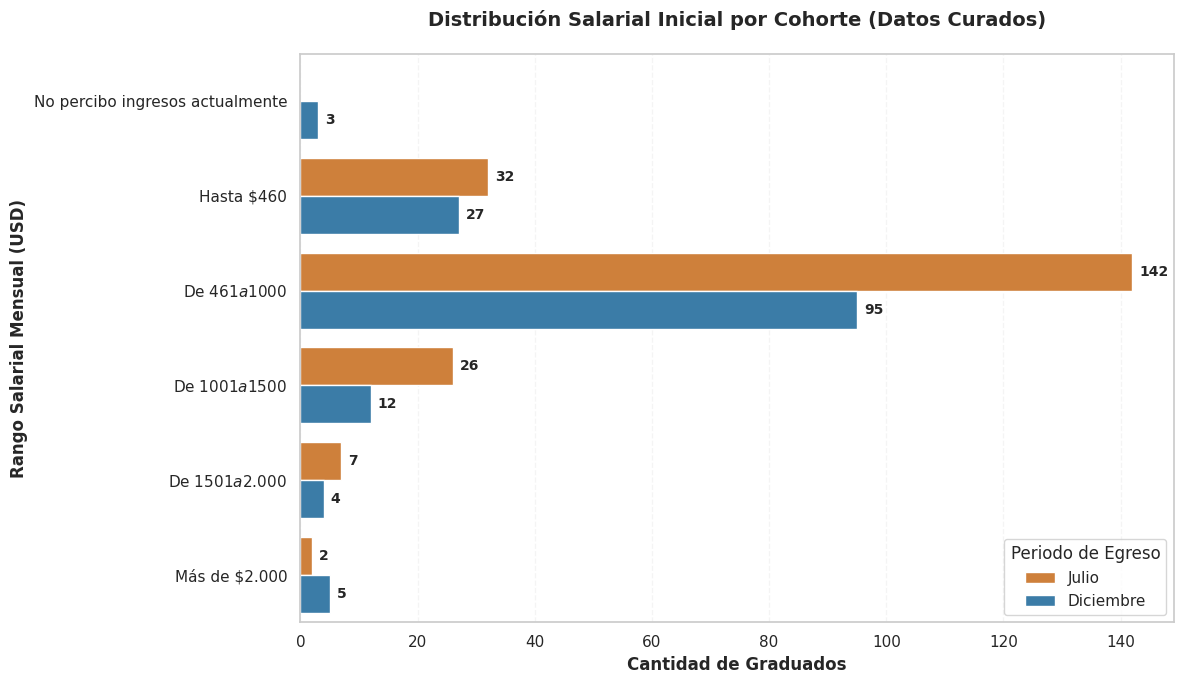

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ==============================================================================
# 1. PREPARACIÓN DE DATOS
# ==============================================================================
# Identificar la columna exacta de salario (usando el nombre real detectado)
col_salario_lista = [c for c in df_base.columns if 'salarial' in c.lower() or 'ingresos' in c.lower()]

if col_salario_lista:
    col_sal = col_salario_lista[0]

    # 2. DEFINIR ORDEN LÓGICO (Ajustado a los textos reales de la encuesta)
    orden_salarios = [
        'No percibo ingresos actualmente',
        'Hasta $460',
        'De $461 a $1000',
        'De $1001 a $1500',
        'De $1501 a $2.000',
        'Más de $2.000'
    ]

    # Filtrar solo datos que existen realmente
    datos_validos = df_base[df_base[col_sal].notna()].copy()

    # Limpieza de espacios en blanco por si acaso
    datos_validos[col_sal] = datos_validos[col_sal].str.strip()
    categorias_presentes = datos_validos[col_sal].unique()

    # Intersección ordenada: Solo las categorías que existen en los datos
    orden_final = [cat for cat in orden_salarios if cat in categorias_presentes]

    # Si hay alguna categoría extraña (Outlier), la mandamos al final
    otros = [x for x in categorias_presentes if x not in orden_salarios]
    orden_final.extend(otros)

    # ==============================================================================
    # 3. GENERACIÓN DEL GRÁFICO
    # ==============================================================================
    plt.figure(figsize=(12, 7))

    # Definir paleta de colores oficial de tu TIC
    colores_cohorte = {'Julio': '#E67E22', 'Diciembre': '#2980B9'}

    ax = sns.countplot(
        data=datos_validos,
        y=col_sal,
        hue='Cohorte', # Asegúrate de usar el nombre de tu columna de cohorte (CAT_Cohorte o Cohorte)
        order=orden_final,
        palette=colores_cohorte
    )

    # Estética y Títulos
    plt.title('Distribución Salarial Inicial por Cohorte (Datos Curados)', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Cantidad de Graduados', fontweight='bold')
    plt.ylabel('Rango Salarial Mensual (USD)', fontweight='bold')
    plt.legend(title='Periodo de Egreso', loc='lower right', frameon=True)
    plt.grid(axis='x', alpha=0.2, linestyle='--')

    # Etiquetas de Datos (Números de graduados al final de cada barra)
    for container in ax.containers:
        ax.bar_label(container, padding=5, fontsize=10, fontweight='bold')

    plt.tight_layout()

    # 4. GUARDAR
    filename = 'Fig_Salarios_Ordenado_EPN.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✅ Gráfico ordenado guardado exitosamente como: {filename}")
    plt.show()

else:
    print("❌ Error: No se encontró la columna de Rango Salarial en df_base.")

📊 Análisis Estadístico: Caracterización Socioeconómica Distribución de Ingresos: Los datos confirman que el mercado laboral para los egresados de la EPN está concentrado en el rango medio-bajo: el 65.07% (Diciembre) y el 67.94% (Julio) perciben entre  461𝑦 1000.

Comparativa de Cohortes: Existe una estabilidad notable entre ambos periodos. Se observa una ligera ventaja porcentual en la cohorte de Julio para el rango de  1001𝑎 1500 (12.44% vs. 8.22%), mientras que Diciembre presenta una mayor incidencia de salarios mínimos o menores (18.49%).

Función Descriptiva: Esta variable actúa como un validador de la homogeneidad contextual. Al no haber diferencias salariales extremas, se confirma que ambos grupos enfrentan condiciones de mercado similares, lo que fortalece la validez del análisis longitudinal de supervivencia.

💡 Hallazgo Académico: Estabilidad del Mercado Laboral En el marco de tu investigación, la figura Fig_Salarios_Comparativo_Cohortes.png cumple un rol de control: asegura que la inserción laboral medida no está sesgada por una bonanza o crisis salarial específica de un mes. Demuestra que, independientemente de cuándo egresaron, los profesionales STEM acceden a niveles de remuneración comparables, lo que permite que el modelo predictivo se enfoque puramente en la relación entre competencias y tiempo de búsqueda.

In [ ]:
# 1. Cuantificación de la Distribución Salarial
print("--- CONTEO SALARIAL POR COHORTE ---")
tabla_salarios = pd.crosstab(df_base[col_sal], df_base['Cohorte'], margins=True)
# Reordenar para que coincida con el gráfico
print(tabla_salarios.reindex(orden_final + ['All']))

# 2. Análisis de Proporciones (Detección de Subempleo)
print("\n--- PORCENTAJES RELATIVOS POR COHORTE (%) ---")
porcentajes = pd.crosstab(df_base[col_sal], df_base['Cohorte'], normalize='columns') * 100
print(porcentajes.round(2).reindex(orden_final))

--- CONTEO SALARIAL POR COHORTE ---
Cohorte                               Diciembre  Julio  All
4.1.11 Rango salarial mensual (USD):                       
No percibo ingresos actualmente               3      0    3
Hasta $460                                   27     32   59
De $461 a $1000                              95    142  237
De $1001 a $1500                             12     26   38
De $1501 a $2.000                             4      7   11
Más de $2.000                                 5      2    7
All                                         146    209  355

--- PORCENTAJES RELATIVOS POR COHORTE (%) ---
Cohorte                               Diciembre  Julio
4.1.11 Rango salarial mensual (USD):                  
No percibo ingresos actualmente            2.05   0.00
Hasta $460                                18.49  15.31
De $461 a $1000                           65.07  67.94
De $1001 a $1500                           8.22  12.44
De $1501 a $2.000                          2.74

In [ ]:
import pandas as pd
import numpy as np
import unicodedata

# ==============================================================================
# 1. FUNCIÓN DE LIMPIEZA DE TEXTO
# ==============================================================================
def limpiar_texto(texto):
    if pd.isna(texto): return ""
    txt = str(texto).lower()
    # Eliminar tildes
    txt = ''.join((c for c in unicodedata.normalize('NFD', txt) if unicodedata.category(c) != 'Mn'))
    return txt

# ==============================================================================
# 2. SELECCIÓN INTELIGENTE DE LA COLUMNA CARRERA (FIX CRÍTICO)
# ==============================================================================
def obtener_columna_carrera_real(df):
    # Paso 1: Buscar todas las que digan 'carrera'
    candidatas = [c for c in df.columns if 'carrera' in c.lower()]

    # Paso 2: Filtro de Exclusión (Palabras prohibidas que aparecen en preguntas abiertas)
    palabras_prohibidas = ['agregar', 'recomend', 'mejorar', 'consideras', 'formación', 'calificas']

    candidatas_limpias = []
    for col in candidatas:
        es_valida = True
        for prohibida in palabras_prohibidas:
            if prohibida in col.lower():
                es_valida = False
                break
        if es_valida:
            candidatas_limpias.append(col)

    print(f"Candidatas iniciales: {len(candidatas)}")
    print(f"Candidatas tras filtro: {candidatas_limpias}")

    # Paso 3: Prioridad
    # Si tenemos algo que parece un ID o nombre corto, lo preferimos
    if 'Carrera' in candidatas_limpias: return 'Carrera'
    if 'carrera' in candidatas_limpias: return 'carrera'

    # Si no, tomamos la primera que sobrevivió (usualmente '(RRA20) CARRERA...')
    if candidatas_limpias:
        return candidatas_limpias[0]

    raise ValueError("❌ No pude encontrar una columna de carrera válida. Revisa los nombres del CSV.")

# Ejecutar detección
col_carrera_final = obtener_columna_carrera_real(df_base)
print(f"--> ✅ Columna Seleccionada: '{col_carrera_final}'")

# ==============================================================================
# 3. MAPEO EPN OFICIAL (Corregido: Producción -> FCA)
# ==============================================================================
def asignar_facultad_epn_real(texto_carrera):
    txt = limpiar_texto(texto_carrera)
    if not txt: return 'Otras'

    # 1. FCA - Facultad de Ciencias Administrativas (Producción + Empresarial)
    if any(x in txt for x in ['administracion', 'empresarial', 'economica', 'financiera',
                              'negocios', 'comercial', 'produccion', 'logistica']):
        return 'FCA (Ciencias Admin.)'

    # 2. FIM - Facultad de Ingeniería Mecánica
    if any(x in txt for x in ['mecanica', 'mecatronica', 'materiales', 'industrial']):
        return 'FIM (Mecánica)'

    # 3. FIE - Facultad de Ingeniería Eléctrica y Electrónica
    if any(x in txt for x in ['electrica', 'electricidad', 'electronica', 'telecom',
                              'redes', 'control', 'automatizacion']):
        return 'FIE (Eléctrica/Electrónica)'

    # 4. FGP - Facultad de Geología y Petróleos
    if any(x in txt for x in ['geologia', 'geologica', 'petroleos', 'minas', 'hidrocarburos']):
        return 'FGP (Geología/Petróleos)'

    # 5. FIS - Facultad de Ingeniería de Sistemas
    if any(x in txt for x in ['sistemas', 'software', 'computacion', 'datos', 'inteligencia']):
        return 'FIS (Sistemas)'

    # 6. FIC - Facultad de Ingeniería Civil y Ambiental
    if any(x in txt for x in ['civil', 'ambiental', 'agua', 'saneamiento', 'estructuras']):
        return 'FIC (Civil)'

    # 7. FIQ - Facultad de Ingeniería Química y Agroindustria
    if any(x in txt for x in ['quimica', 'agro', 'alimentos']):
        return 'FIQ (Química)'

    # 8. FC - Facultad de Ciencias
    if any(x in txt for x in ['matematica', 'fisica', 'nuclear','economia']):
        return 'FC (Ciencias)'

    # 9. ESFOT - Tecnólogos
    if 'tecnolog' in txt:
        return 'ESFOT (Tecnólogos)'

    return 'Otras'

# Aplicar Mapeo
df_base['Facultad'] = df_base[col_carrera_final].apply(asignar_facultad_epn_real)

# 4. Verificación Final
print("\n✅ DISTRIBUCIÓN FINAL DE FACULTADES (EPN REAL):")
print(df_base['Facultad'].value_counts())

# Si aún hay otras, muestra qué texto es para depurar
huerfanos = df_base[df_base['Facultad'] == 'Otras'][col_carrera_final].unique()
if len(huerfanos) > 0:
    print("\n⚠️ Aún quedan en 'Otras':", huerfanos)
else:
    print("\n✨ Limpieza total. Ninguna carrera huérfana.")

Candidatas iniciales: 3
Candidatas tras filtro: ['carrera']
--> ✅ Columna Seleccionada: 'carrera'

✅ DISTRIBUCIÓN FINAL DE FACULTADES (EPN REAL):
Facultad
FIS (Sistemas)                 180
FIC (Civil)                    120
FIE (Eléctrica/Electrónica)    111
FIM (Mecánica)                  85
FC (Ciencias)                   52
FCA (Ciencias Admin.)           51
FIQ (Química)                   33
ESFOT (Tecnólogos)              17
FGP (Geología/Petróleos)        16
Name: count, dtype: int64

✨ Limpieza total. Ninguna carrera huérfana.


In [ ]:
# Diagnóstico de TARGET_Evento
print("=== DIAGNÓSTICO TARGET_Evento ===")
print(f"Tipo de datos: {df_base['TARGET_Evento'].dtype}")
print(f"\nValores únicos:")
print(df_base['TARGET_Evento'].value_counts(dropna=False))
print(f"\nPrimeros 10 valores:")
print(df_base['TARGET_Evento'].head(10).tolist())

=== DIAGNÓSTICO TARGET_Evento ===
Tipo de datos: object

Valores únicos:
TARGET_Evento
Si    355
No    310
Name: count, dtype: int64

Primeros 10 valores:
['Si', 'Si', 'No', 'No', 'No', 'Si', 'Si', 'No', 'Si', 'Si']


--> Analizando Facultad usando columna: 'carrera'


/tmp/ipython-input-2544323469.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_base, y='Facultad', order=order_fac, palette='viridis')


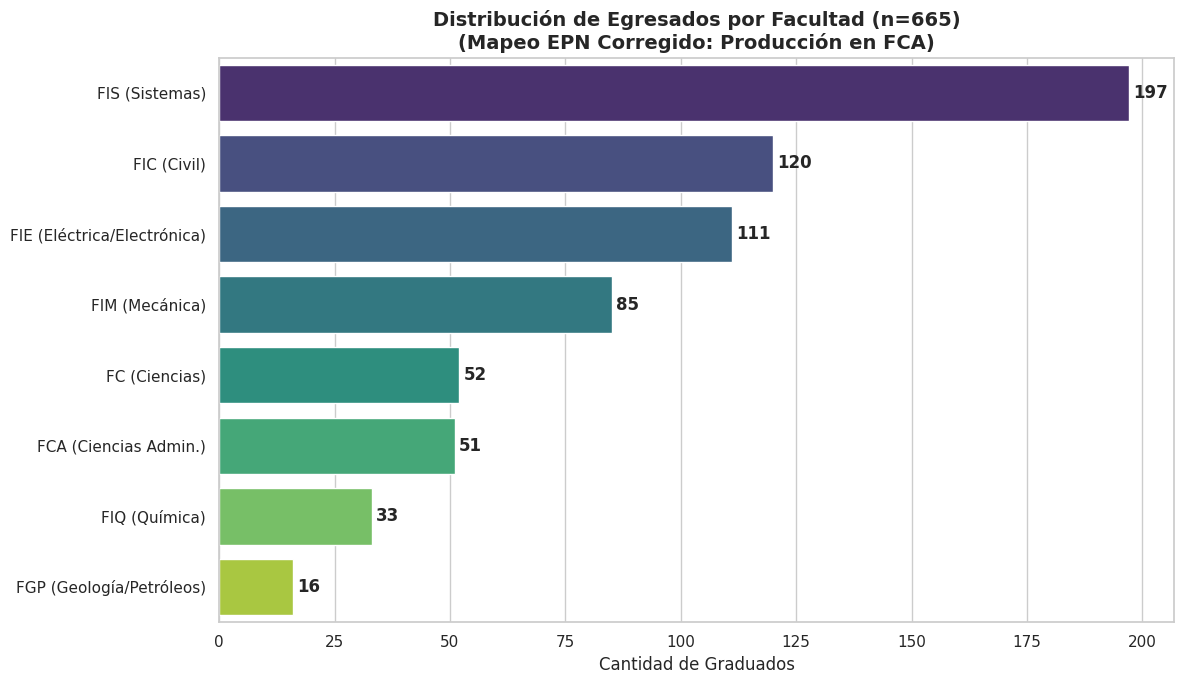


--- CONTEO FINAL POR FACULTAD ---
Facultad
FIS (Sistemas)                 197
FIC (Civil)                    120
FIE (Eléctrica/Electrónica)    111
FIM (Mecánica)                  85
FC (Ciencias)                   52
FCA (Ciencias Admin.)           51
FIQ (Química)                   33
FGP (Geología/Petróleos)        16
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import unicodedata

# ==============================================================================
# 1. FUNCIÓN DE LIMPIEZA DE TEXTO (Normalización)
# ==============================================================================
def limpiar_texto(texto):
    if pd.isna(texto): return ""
    txt = str(texto).lower()
    # Eliminar tildes (á -> a, é -> e, etc.) para evitar fallos por "Mecánica" vs "Mecanica"
    txt = ''.join((c for c in unicodedata.normalize('NFD', txt) if unicodedata.category(c) != 'Mn'))
    return txt

# ==============================================================================
# 2. SELECCIÓN INTELIGENTE DE COLUMNA (Evita preguntas 6.1, 6.3, 6.5)
# ==============================================================================
def obtener_columna_carrera_real(df):
    # Buscamos todas las columnas que digan 'carrera'
    candidatas = [c for c in df.columns if 'carrera' in c.lower()]

    # Filtro de Exclusión: Ignorar preguntas de la encuesta
    palabras_prohibidas = ['agregar', 'recomend', 'mejorar', 'consideras', 'formación', 'calificas']

    candidatas_limpias = []
    for col in candidatas:
        if not any(prohibida in col.lower() for prohibida in palabras_prohibidas):
            candidatas_limpias.append(col)

    # Prioridad
    if 'Carrera' in candidatas_limpias: return 'Carrera'
    if candidatas_limpias: return candidatas_limpias[0]

    # Fallback de seguridad (si todo falla, usa la primera columna de texto que parezca id)
    return 'Carrera'

col_real = obtener_columna_carrera_real(df_base)
print(f"--> Analizando Facultad usando columna: '{col_real}'")

# ==============================================================================
# 3. MAPEO EPN DEFINITIVO (Producción -> FCA)
# ==============================================================================
def asignar_facultad_pro_epn(texto_carrera):
    txt = limpiar_texto(texto_carrera)
    if not txt: return 'Otras'

    # --- REGLAS EN ORDEN DE PRIORIDAD ---

    # 1. FCA - Ciencias Administrativas (Incluye Producción y Empresarial)
    if any(k in txt for k in ['administracion', 'empresarial', 'economica', 'financiera',
                              'comercial', 'negocios', 'produccion', 'logistica']):
        return 'FCA (Ciencias Admin.)'

    # 2. FIM - Mecánica (Ya sin Producción)
    if any(k in txt for k in ['mecanica', 'mecatronica', 'materiales', 'industrial']):
        return 'FIM (Mecánica)'

    # 3. FIE - Eléctrica y Electrónica
    if any(k in txt for k in ['electrica', 'electricidad', 'electronica', 'telecom',
                              'redes', 'control', 'automatizacion']):
        return 'FIE (Eléctrica/Electrónica)'

    # 4. FGP - Geología y Petróleos
    if any(k in txt for k in ['geologia', 'geologica', 'petroleos', 'minas', 'hidrocarburos']):
        return 'FGP (Geología/Petróleos)'

    # 5. FIS - Sistemas
    if any(k in txt for k in ['sistemas', 'software', 'computacion', 'datos', 'inteligencia', 'tecnologias de la']):
        return 'FIS (Sistemas)'

    # 6. FIC - Civil
    if any(k in txt for k in ['civil', 'ambiental', 'agua', 'sanitaria', 'estructuras']):
        return 'FIC (Civil)'

    # 7. FIQ - Química
    if any(k in txt for k in ['quimica', 'agro', 'alimentos']):
        return 'FIQ (Química)'

    # 8. FC - Ciencias
    if any(k in txt for k in ['matematica', 'fisica', 'economia']):
        return 'FC (Ciencias)'

    # 9. ESFOT - Tecnólogos
    if 'tecnolog' in txt:
        return 'ESFOT (Tecnólogos)'

    return 'Otras'

# Aplicar Mapeo
df_base['Facultad'] = df_base[col_real].apply(asignar_facultad_pro_epn)

# ==============================================================================
# 4. VISUALIZACIÓN CORREGIDA
# ==============================================================================
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

# Ordenar por cantidad
order_fac = df_base['Facultad'].value_counts().index
ax = sns.countplot(data=df_base, y='Facultad', order=order_fac, palette='viridis')

plt.title('Distribución de Egresados por Facultad (n={})\n(Mapeo EPN Corregido: Producción en FCA)'.format(len(df_base)),
          fontsize=14, fontweight='bold')
plt.xlabel('Cantidad de Graduados')
plt.ylabel('')

# Etiquetas de datos
for container in ax.containers:
    ax.bar_label(container, padding=3, fmt='%d', fontweight='bold')

plt.tight_layout()
plt.savefig('fig_cap3_distribucion_facultades.png', dpi=300)
plt.show()

print("\n--- CONTEO FINAL POR FACULTAD ---")
print(df_base['Facultad'].value_counts())

✅ [1/11] Efectividad por carrera


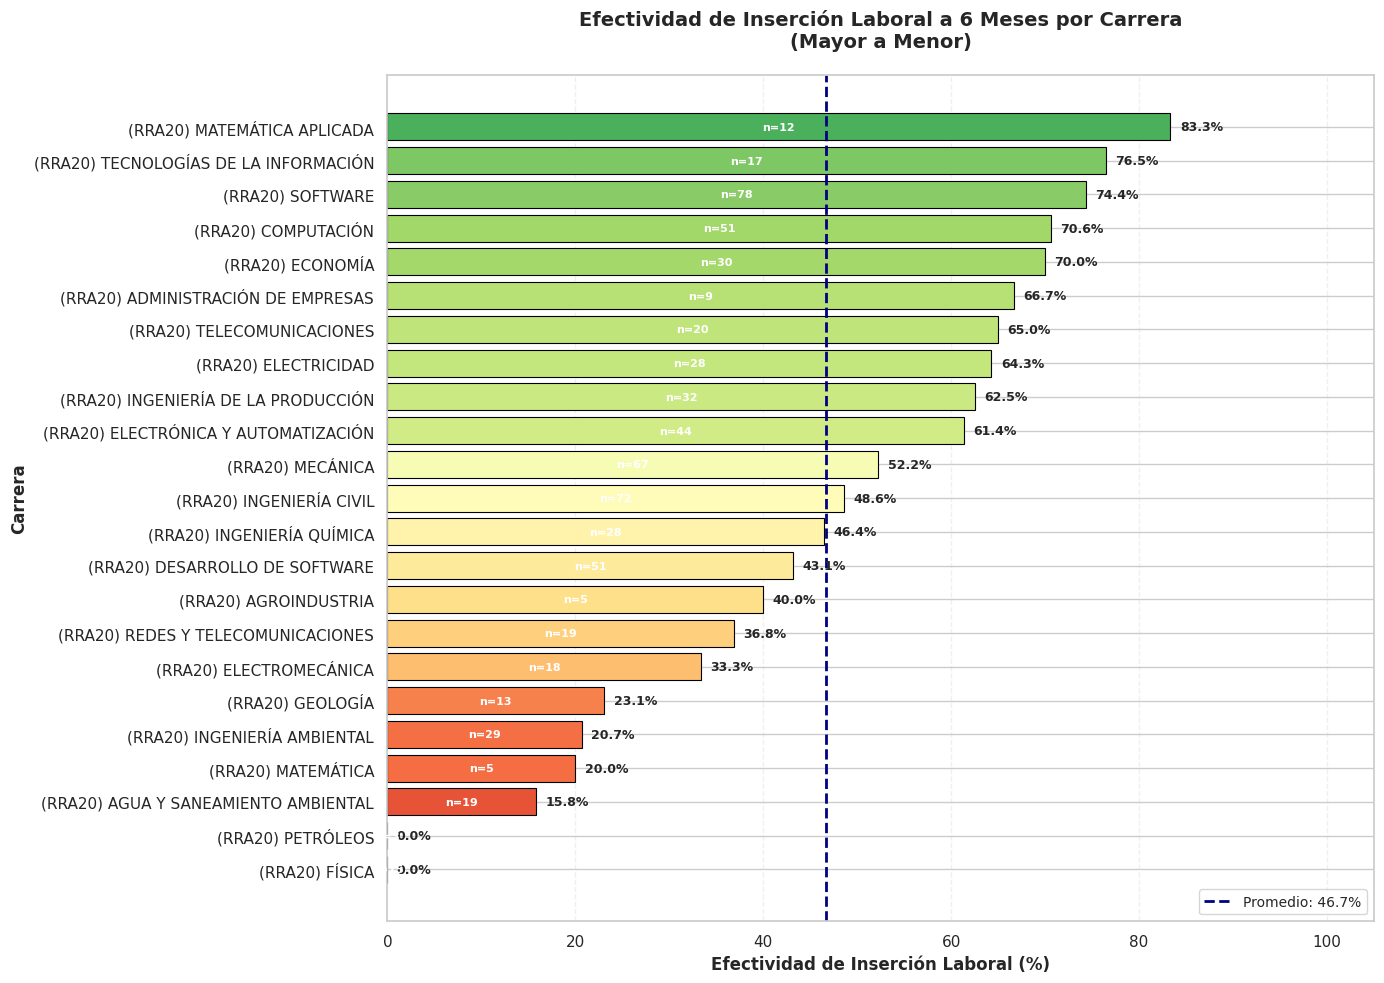

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Conversión TARGET_Evento
df_analisis = df_base.copy()
df_analisis['TARGET_Evento_Num'] = (df_analisis['TARGET_Evento'] == 'Si').astype(int)

# Homologación carreras
def homologar_carrera(carrera):
    carrera = str(carrera).strip().upper()
    mapeo = {
        'INGENIERIA MECANICA': '(RRA20) MECÁNICA',
        'INGENIERIA GEOLOGICA': '(RRA20) GEOLOGÍA',
        'INGENIERIA EMPRESARIAL': '(RRA20) ADMINISTRACIÓN DE EMPRESAS',
        'FISICA': '(RRA20) FÍSICA',
        'INGENIERIA EN CIENCIAS ECONOMICAS Y FINANCIERAS': '(RRA20) ECONOMÍA'
    }
    return mapeo.get(carrera, carrera)

df_analisis['carrera_homologada'] = df_analisis['carrera'].apply(homologar_carrera)

# Cálculo efectividad
efectividad = df_analisis.groupby('carrera_homologada').agg(
    Total_Encuestados=('TARGET_Evento_Num', 'count'),
    Con_Empleo=('TARGET_Evento_Num', 'sum'),
    Sin_Empleo=('TARGET_Evento_Num', lambda x: (x == 0).sum())
).reset_index()

efectividad['Con_Empleo'] = efectividad['Con_Empleo'].astype(int)
efectividad['Efectividad_%'] = (efectividad['Con_Empleo'] / efectividad['Total_Encuestados'] * 100).round(2)
efectividad = efectividad.sort_values('Efectividad_%', ascending=True).reset_index(drop=True)  # ASCENDENTE para barh
efectividad.insert(0, 'Ranking', range(len(efectividad), 0, -1))  # Ranking invertido

# Visualización
fig, ax = plt.subplots(figsize=(14, 10))
colores = plt.cm.RdYlGn(efectividad['Efectividad_%'] / 100)
ax.barh(efectividad['carrera_homologada'], efectividad['Efectividad_%'],
        color=colores, edgecolor='black', linewidth=0.8)

for i, (idx, row) in enumerate(efectividad.iterrows()):
    ax.text(row['Efectividad_%'] + 1, i, f"{row['Efectividad_%']:.1f}%",
            va='center', fontsize=9, fontweight='bold')
    ax.text(row['Efectividad_%'] / 2, i, f"n={row['Total_Encuestados']}",
            va='center', ha='center', fontsize=8, color='white', fontweight='bold')

promedio = efectividad['Efectividad_%'].mean()
ax.axvline(promedio, color='navy', linestyle='--', linewidth=2,
           label=f'Promedio: {promedio:.1f}%')

ax.set_xlabel('Efectividad de Inserción Laboral (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Carrera', fontsize=12, fontweight='bold')
ax.set_title('Efectividad de Inserción Laboral a 6 Meses por Carrera\n(Mayor a Menor)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, 105)
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('01_efectividad_carrera.png', dpi=300, bbox_inches='tight')
print("✅ [1/11] Efectividad por carrera")

In [ ]:
# Verificar estructura de TARGET_Tiempo
print("=== DIAGNÓSTICO TARGET_Tiempo ===")
print(f"Valores únicos (primeros 20):")
print(df_base['TARGET_Tiempo'].value_counts().head(20))
print(f"\nPrimeros 10 valores:")
print(df_base['TARGET_Tiempo'].head(10).tolist())

=== DIAGNÓSTICO TARGET_Tiempo ===
Valores únicos (primeros 20):
TARGET_Tiempo
Menos de 6 meses         198
Entre 6 meses y 1 año     82
Entre 1 y 2 años          43
Más de 2 años             32
Name: count, dtype: int64

Primeros 10 valores:
['Menos de 6 meses', 'Menos de 6 meses', nan, nan, nan, 'Menos de 6 meses', 'Entre 1 y 2 años', nan, 'Entre 6 meses y 1 año', 'Menos de 6 meses']


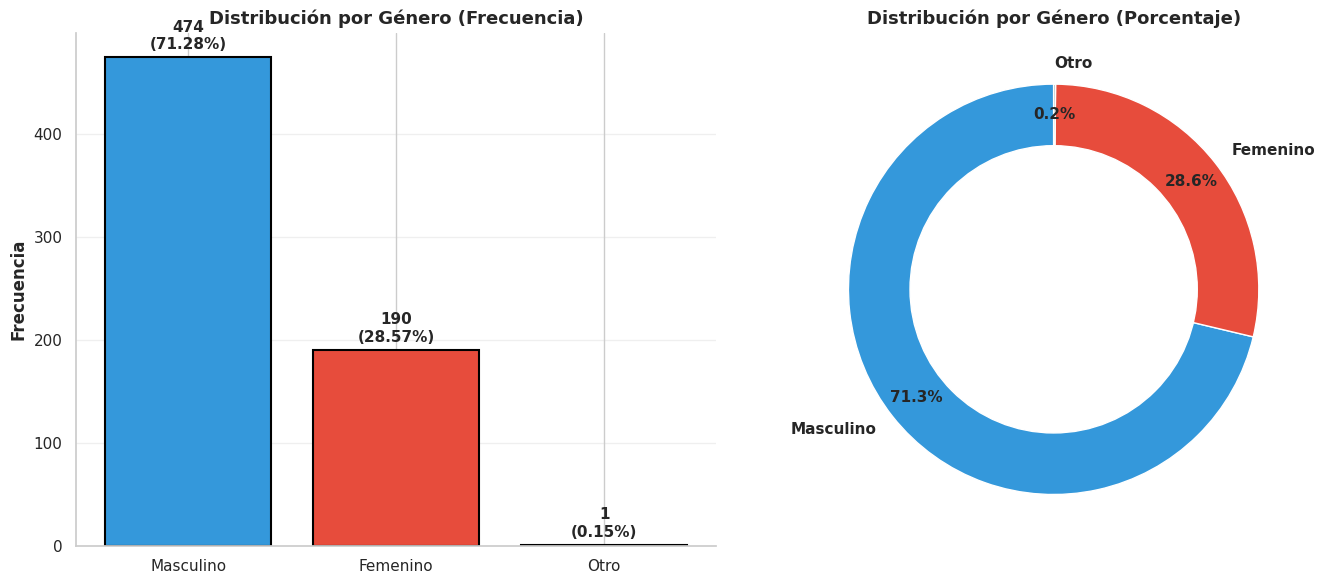

✅ [2/11] Distribución de género generada.

--- DATOS REALES (INCLUYENDO MINORÍAS) ---
Genero
Masculino    474
Femenino     190
Otro           1
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Verificar que df_base existe
if 'df_base' not in locals():
    print("❌ Carga df_base primero.")
else:
    # 1. Preparar Datos
    genero_dist = df_base['Genero'].value_counts()
    genero_pct = (df_base['Genero'].value_counts(normalize=True) * 100).round(2)

    # 2. Asignación de Colores Inteligente (Para que coincida siempre)
    # Definimos un diccionario de colores fijos
    color_map = {
        'Masculino': '#3498db', # Azul
        'Femenino': '#e74c3c',  # Rojo/Coral
        'Otro': '#95a5a6',      # Gris
        'Prefiero no decirlo': '#95a5a6',
        'Otros': '#95a5a6'
    }

    # Generamos la lista de colores en el orden exacto en que aparecen los datos
    colores_reales = [color_map.get(g, '#95a5a6') for g in genero_dist.index]

    # 3. Configuración del Gráfico
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # --- GRÁFICO DE BARRAS ---
    bars = ax1.bar(genero_dist.index, genero_dist.values, color=colores_reales,
                   edgecolor='black', linewidth=1.5)

    # Etiquetas encima de las barras
    for bar, pct in zip(bars, genero_pct):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height + 5,
                 f'{int(height)}\n({pct}%)',
                 ha='center', va='bottom', fontweight='bold', fontsize=11)

    ax1.set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
    ax1.set_title('Distribución por Género (Frecuencia)', fontsize=13, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # --- GRÁFICO DE PASTEL (DONA) ---
    wedges, texts, autotexts = ax2.pie(genero_dist.values, labels=genero_dist.index,
                                         autopct='%1.1f%%', colors=colores_reales,
                                         startangle=90, pctdistance=0.85,
                                         textprops={'fontsize': 11, 'fontweight': 'bold'})

    # Convertir en Dona (Más estético)
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    ax2.add_artist(centre_circle)

    ax2.set_title('Distribución por Género (Porcentaje)', fontsize=13, fontweight='bold')

    plt.tight_layout()
    plt.savefig('02_distribucion_genero.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ [2/11] Distribución de género generada.")
    print("\n--- DATOS REALES (INCLUYENDO MINORÍAS) ---")
    print(genero_dist)

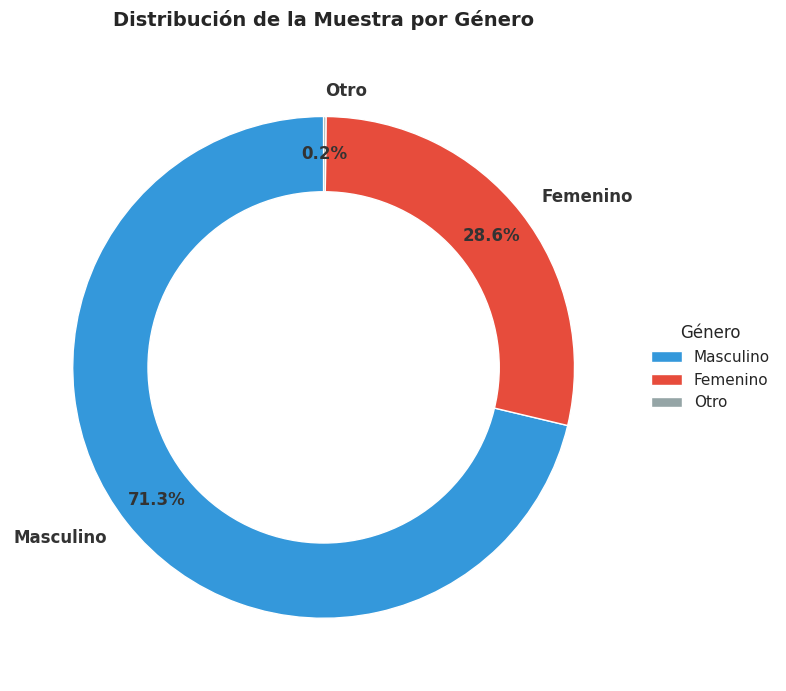

✅ Gráfico generado.
Genero
Masculino    474
Femenino     190
Otro           1
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Verificamos que df_base esté cargado
if 'df_base' not in locals():
    print("❌ ERROR: Carga primero df_base.")
else:
    # 1. Preparar Datos
    genero_dist = df_base['Genero'].value_counts()

    # 2. Configuración de Colores (Estándar Tesis)
    # Usamos .get() para asignar gris por defecto si aparece algo raro
    color_map = {
        'Masculino': '#3498db', # Azul Profesional
        'Femenino': '#e74c3c',  # Rojo/Coral Suave
        'Otro': '#95a5a6',      # Gris Neutro
        'Prefiero no decirlo': '#95a5a6'
    }
    colores = [color_map.get(x, '#95a5a6') for x in genero_dist.index]

    # 3. Crear Gráfico (Solo Dona)
    plt.figure(figsize=(8, 8))

    # Dibujar Pie Chart
    wedges, texts, autotexts = plt.pie(
        genero_dist.values,
        labels=genero_dist.index,
        autopct='%1.1f%%',
        colors=colores,
        startangle=90,
        pctdistance=0.85, # Mueve el porcentaje hacia el borde
        textprops={'fontsize': 12, 'fontweight': 'bold', 'color': '#333333'}
    )

    # Convertir en Dona (Dibujar círculo blanco en el centro)
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Títulos y Leyenda
    plt.title('Distribución de la Muestra por Género', fontsize=14, fontweight='bold', pad=20)
    plt.legend(title="Género", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), frameon=False)

    # Guardar
    plt.tight_layout()
    plt.savefig('02_distribucion_genero_dona.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Gráfico generado.")
    print(genero_dist)

✅ [3/11] Prácticas preprofesionales

4.1.10 ¿Consideras que las prácticas preprofesionales y pasantías han contribuido a un mejor desempeño en tu vida profesional / laboral?
Si    323
No     32
Name: count, dtype: int64
4.1.10 ¿Consideras que las prácticas preprofesionales y pasantías han contribuido a un mejor desempeño en tu vida profesional / laboral?
Si    90.99
No     9.01
Name: count, dtype: float64


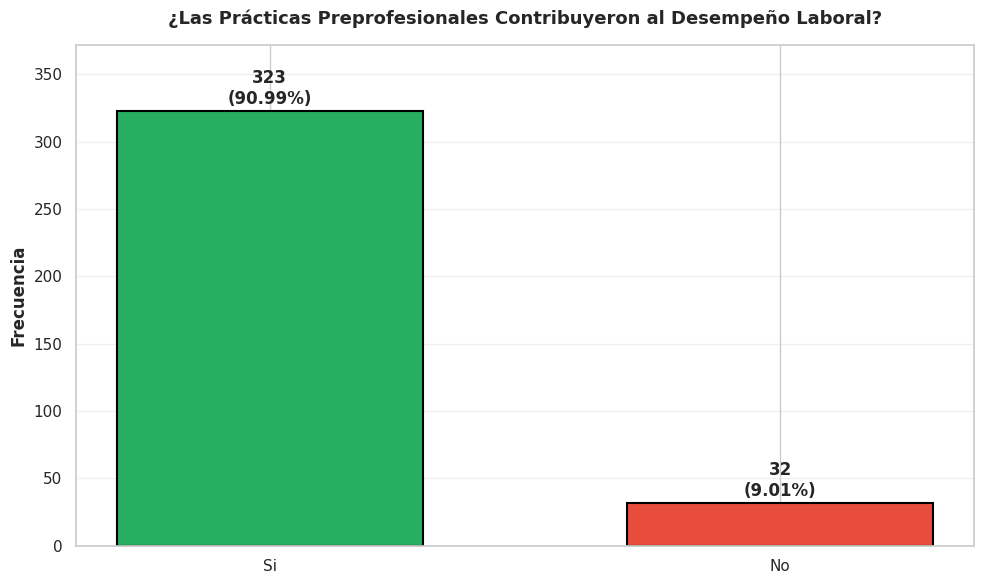

In [ ]:
col_practicas = '4.1.10 ¿Consideras que las prácticas preprofesionales y pasantías han contribuido a un mejor desempeño en tu vida profesional / laboral?'

practicas_dist = df_base[col_practicas].value_counts()
practicas_pct = (practicas_dist / practicas_dist.sum() * 100).round(2)

fig, ax = plt.subplots(figsize=(10, 6))
colores = ['#27ae60', '#e74c3c']
bars = ax.bar(practicas_dist.index, practicas_dist.values, color=colores,
              edgecolor='black', linewidth=1.5, width=0.6)

for i, (cat, val) in enumerate(practicas_dist.items()):
    ax.text(i, val + 5, f'{val}\n({practicas_pct[cat]}%)', ha='center',
            fontweight='bold', fontsize=12)

ax.set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
ax.set_title('¿Las Prácticas Preprofesionales Contribuyeron al Desempeño Laboral?',
             fontsize=13, fontweight='bold', pad=15)
ax.set_ylim(0, practicas_dist.max() * 1.15)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('03_practicas_preprofesionales.png', dpi=300, bbox_inches='tight')
print("✅ [3/11] Prácticas preprofesionales")
print(f"\n{practicas_dist}\n{practicas_pct}")

✅ [4B/11] Nivel de HB por Facultad

Promedio por Facultad:
                             S5_Gestion_Proyectos  S1_Comunicacion_Esp  \
Facultad                                                                 
FC (Ciencias)                            3.480769             3.461538   
FCA (Ciencias Admin.)                    3.823529             3.470588   
FGP (Geología/Petróleos)                 3.437500             3.750000   
FIC (Civil)                              3.700000             3.566667   
FIE (Eléctrica/Electrónica)              3.882883             3.765766   
FIM (Mecánica)                           3.576471             3.494118   
FIQ (Química)                            4.060606             3.696970   
FIS (Sistemas)                           3.786802             3.563452   

                             S2_Compromiso_Etico  S4_Resp_Social  \
Facultad                                                           
FC (Ciencias)                           4.019231        3.365385

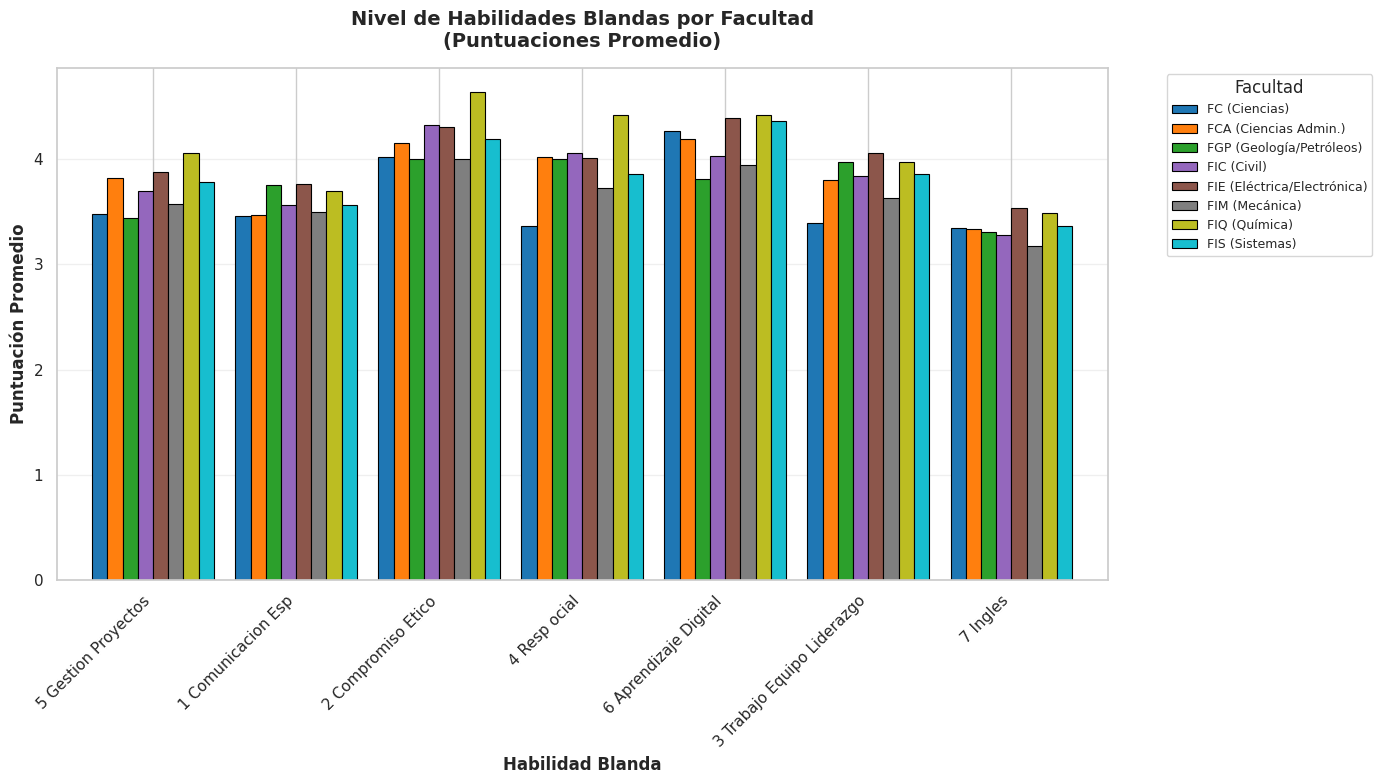

In [ ]:
# Columnas de HB evaluadas (las 7)
cols_hb = ['S5_Gestion_Proyectos', 'S1_Comunicacion_Esp', 'S2_Compromiso_Etico',
           'S4_Resp_Social', 'S6_Aprendizaje_Digital', 'S3_Trabajo_Equipo_Liderazgo',
           'S7_Ingles']  # Añadimos la 7ma si existe

# Verificar cuáles existen
cols_hb_exist = [c for c in cols_hb if c in df_base.columns]

# Promedios por Facultad
hb_facultad = df_base.groupby('Facultad')[cols_hb_exist].mean()

fig, ax = plt.subplots(figsize=(14, 8))
hb_facultad.T.plot(kind='bar', ax=ax, width=0.85,
                   colormap='tab10', edgecolor='black', linewidth=0.8)

ax.set_ylabel('Puntuación Promedio', fontsize=12, fontweight='bold')
ax.set_xlabel('Habilidad Blanda', fontsize=12, fontweight='bold')
ax.set_title('Nivel de Habilidades Blandas por Facultad\n(Puntuaciones Promedio)',
             fontsize=14, fontweight='bold', pad=15)
ax.legend(title='Facultad', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.set_xticklabels([c.replace('S', '').replace('_', ' ') for c in cols_hb_exist],
                    rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('04B_nivel_hb_facultad.png', dpi=300, bbox_inches='tight')
print("✅ [4B/11] Nivel de HB por Facultad")
print("\nPromedio por Facultad:")
print(hb_facultad)

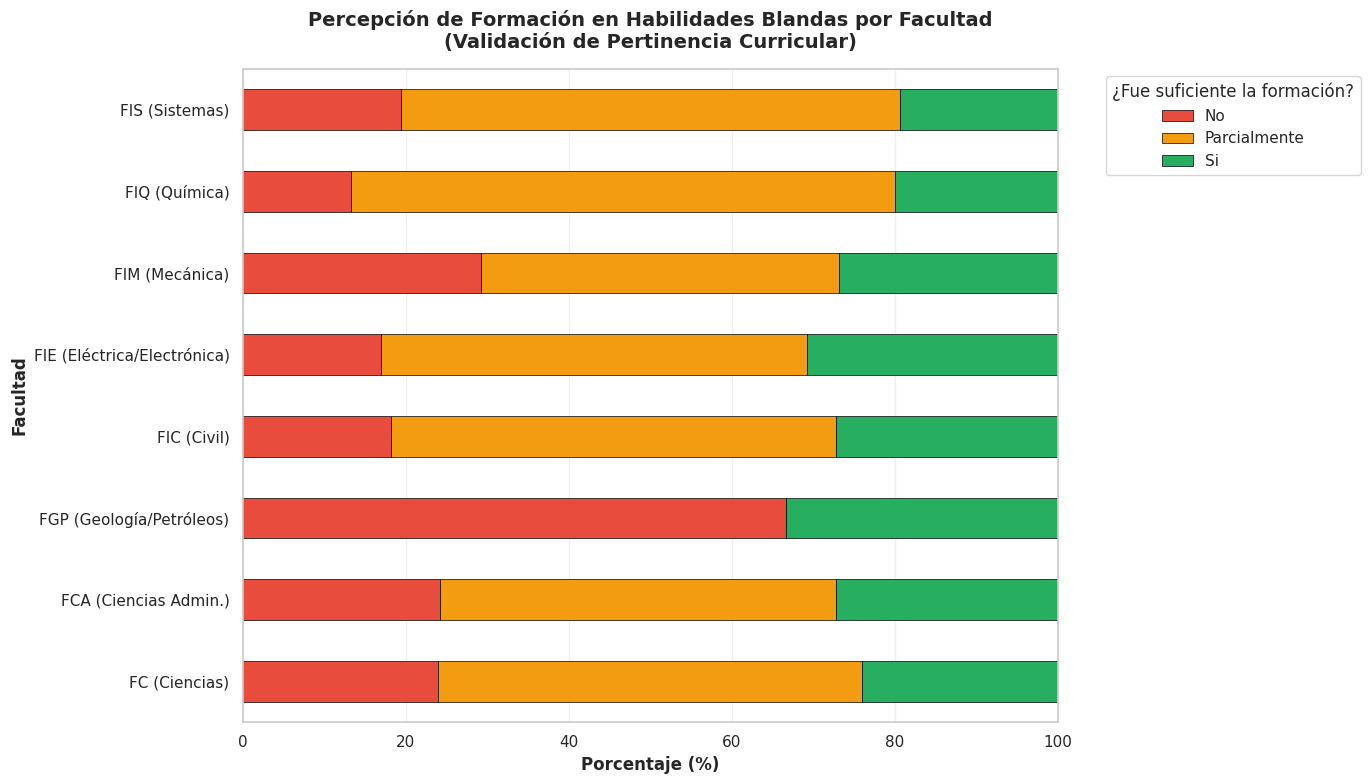

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

col_percepcion = '4.1.8 ¿Consideras que la formación en habilidades blandas (gestión, comunicación efectiva, liderazgo, trabajo en equipo, ética profesional, responsabilidad social, aprendizaje autónomo) recibida en la EPN fue suficiente para enfrentar los desafíos del entorno laboral?'

# 1. Aseguramos el orden lógico de las columnas para que el degradado sea intuitivo
tabla_hb = pd.crosstab(df_base['Facultad'], df_base[col_percepcion], normalize='index') * 100

orden_satisfaccion = ['No', 'Parcialmente', 'Si']
tabla_hb_ordenada = tabla_hb[orden_satisfaccion]

# 2. Definimos colores semánticos: Rojo (No), Naranja (Parcialmente), Verde (Si)
colores_validos = ['#e74c3c', '#f39c12', '#27ae60']

fig, ax = plt.subplots(figsize=(14, 8))
tabla_hb_ordenada.plot(kind='barh', stacked=True, ax=ax,
                       color=colores_validos,
                       edgecolor='black', linewidth=0.5)

ax.set_xlabel('Porcentaje (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Facultad', fontsize=12, fontweight='bold')
ax.set_title('Percepción de Formación en Habilidades Blandas por Facultad\n(Validación de Pertinencia Curricular)',
             fontsize=14, fontweight='bold', pad=15)

# Ajuste de leyenda para que coincida con el orden visual
ax.legend(title='¿Fue suficiente la formación?', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xlim(0, 100)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('04_percepcion_hb_facultad.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 1. Ver la tabla de porcentajes por facultad
print("--- TABLA DE PERCEPCIÓN POR FACULTAD (%) ---")
print(tabla_hb.round(2))

# 2. Ver el balance global de la muestra
print("\n--- BALANCE GLOBAL DE PERCEPCIÓN ---")
print(df_base[col_percepcion].value_counts(normalize=True) * 100)

--- TABLA DE PERCEPCIÓN POR FACULTAD (%) ---
4.1.8 ¿Consideras que la formación en habilidades blandas (gestión, comunicación efectiva, liderazgo, trabajo en equipo, ética profesional, responsabilidad social, aprendizaje autónomo) recibida en la EPN fue suficiente para enfrentar los desafíos del entorno laboral?     No  \
Facultad                                                                                                                                                                                                                                                                              
FC (Ciencias)                                                                                                                                                                                                                                                                 24.00   
FCA (Ciencias Admin.)                                                                                                 

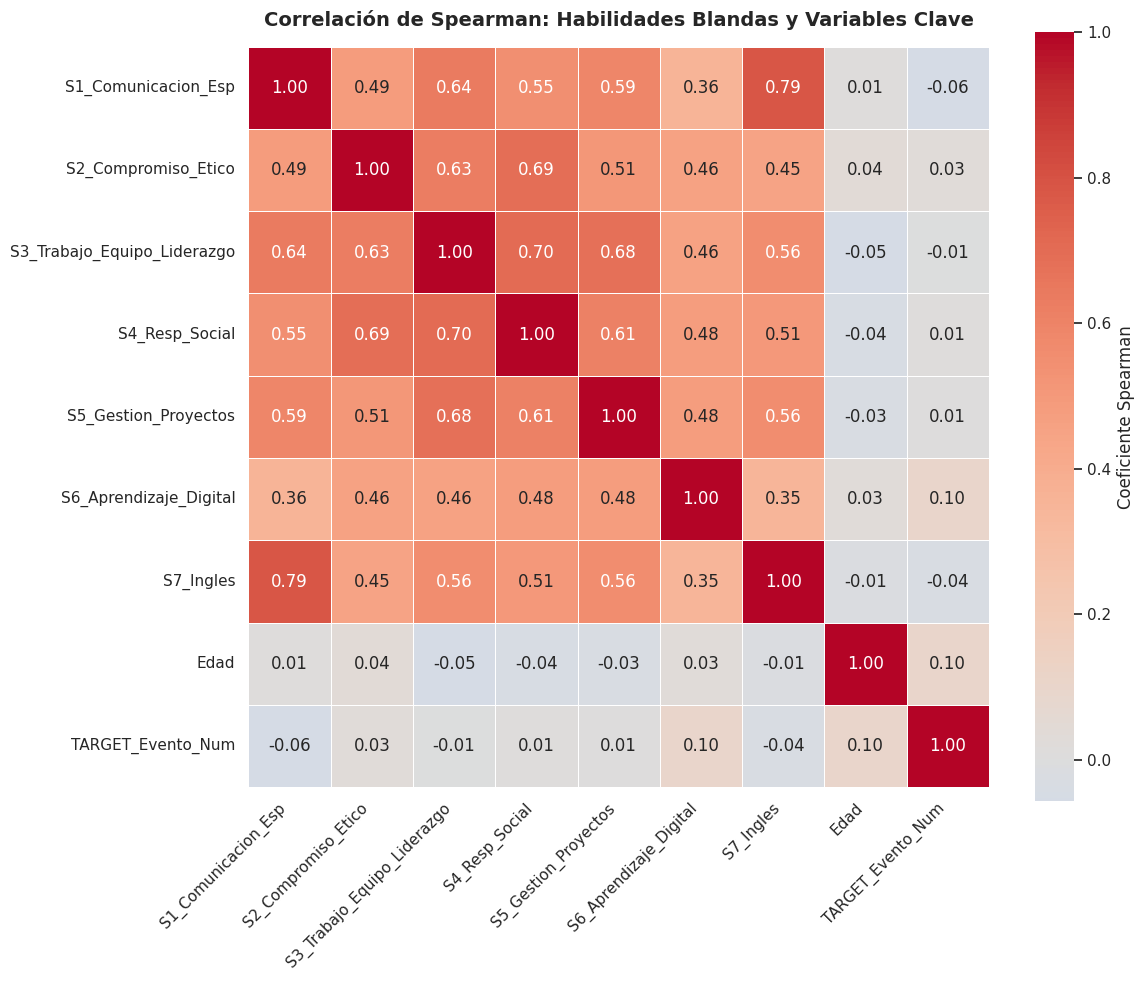

✅ [5/11] Correlación Spearman generada correctamente.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Verificar que df_base existe
if 'df_base' not in locals():
    print("❌ ERROR: Carga primero df_base.")
else:
    # 1. Definición de Columnas
    cols_hb = [
        'S1_Comunicacion_Esp',
        'S2_Compromiso_Etico',
        'S3_Trabajo_Equipo_Liderazgo',
        'S4_Resp_Social',
        'S5_Gestion_Proyectos',
        'S6_Aprendizaje_Digital',
        'S7_Ingles'
    ]

    # Aseguramos que el Target sea numérico (Usamos 'Event' que creamos antes: 1=Inserción, 0=No)
    if 'TARGET_Evento_Num' not in df_base.columns:
        df_base['TARGET_Evento_Num'] = df_base['Event']

    # Lista final de variables para correlacionar
    # Nota: Eliminé el '' vacío que causaba error
    cols_analisis = cols_hb + ['Edad', 'TARGET_Evento_Num']

    # 2. Filtrado y Cálculo
    # Seleccionamos solo las columnas que existen para evitar errores
    cols_existentes = [c for c in cols_analisis if c in df_base.columns]

    df_corr = df_base[cols_existentes].dropna()

    # Usamos el método nativo de pandas, es más robusto para heatmaps
    corr_matrix = df_corr.corr(method='spearman')

    # 3. Graficación
    fig, ax = plt.subplots(figsize=(12, 10))

    sns.heatmap(corr_matrix,
                annot=True,
                fmt='.2f',
                cmap='coolwarm',
                center=0,
                linewidths=0.5,
                cbar_kws={'label': 'Coeficiente Spearman'},
                square=True,
                ax=ax)

    ax.set_title('Correlación de Spearman: Habilidades Blandas y Variables Clave',
                 fontsize=14, fontweight='bold', pad=15)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('05_correlacion_spearman.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ [5/11] Correlación Spearman generada correctamente.")

/tmp/ipython-input-4126369799.py:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = spearmanr(datos_validos[col], datos_validos['T_Upper'])


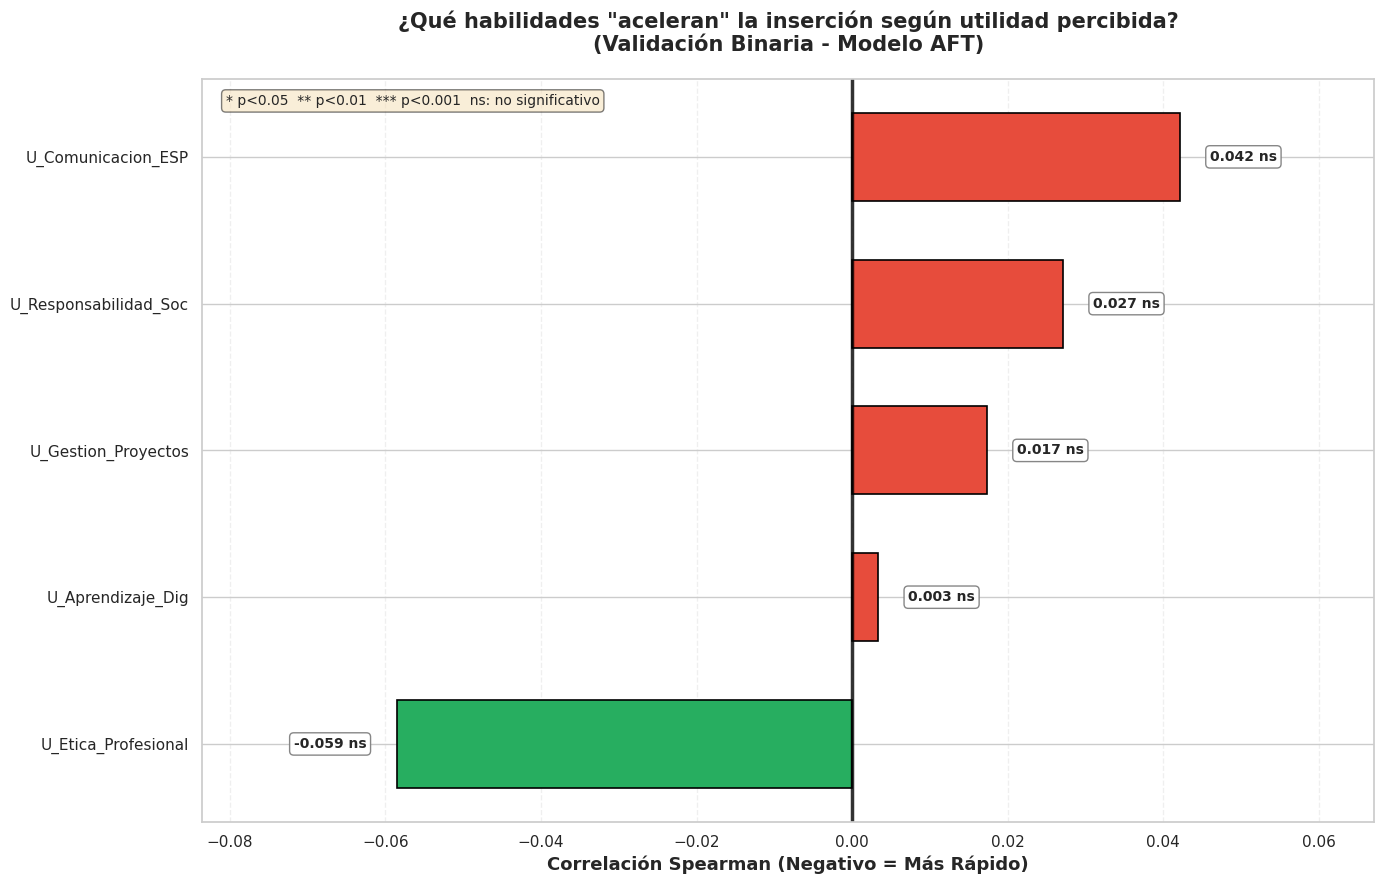

✅ [12B/15] Correlación Utilidad HB vs Tiempo

📊 Muestra: n=355 graduados (T>0.1)


In [ ]:
# ============================================================================
# PREPARACIÓN DE DATOS - UTILIDAD DE HB
# ============================================================================


from scipy.stats import spearmanr

mapeo_utilidad = {
    'UTILIDAD_S1_Comunicacion': 'U_Comunicacion_ESP',
    'UTILIDAD_S2_Etica': 'U_Etica_Profesional',
    'UTILIDAD_S3_Trabajo_Equipo_Liderazgo': 'U_Liderazgo_Equipo',
    'UTILIDAD_S4_Resp_Social': 'U_Responsabilidad_Soc',
    'UTILIDAD_S5_Gestion': 'U_Gestion_Proyectos',
    'UTILIDAD_S6_Aprendizaje_Digital': 'U_Aprendizaje_Dig'
}
cols_utilidad = [c for c in df_base.columns if 'UTILIDAD' in c]
# Convertir a binario (0/1)
df_corr_util = df_analisis.copy()
for col in cols_utilidad:
    if col in df_corr_util.columns:
        if df_corr_util[col].dtype == 'object':
            df_corr_util[col] = df_corr_util[col].map({'Sí': 1, 'No': 0})
# Filtrar empleados con T>0.1
df_corr_util = df_corr_util[
    (df_corr_util['Event'] == 1) &
    (df_corr_util['T_Upper'].notna()) &
    (df_corr_util['T_Upper'] > 0.1)
].copy()
# ============================================================================
# CÁLCULO DE CORRELACIONES
# ============================================================================
correlaciones_util = {}
p_valores_util = {}
for col in cols_utilidad:
    if col in df_corr_util.columns:
        datos_validos = df_corr_util[[col, 'T_Upper']].dropna()
        if len(datos_validos) > 10:
            corr, pval = spearmanr(datos_validos[col], datos_validos['T_Upper'])
            correlaciones_util[col] = corr
            p_valores_util[col] = pval
        else:
            correlaciones_util[col] = np.nan
            p_valores_util[col] = np.nan
df_corr_utilidad = pd.DataFrame({
    'Habilidad': list(correlaciones_util.keys()),
    'Correlacion': list(correlaciones_util.values()),
    'P_valor': list(p_valores_util.values())
})
df_corr_utilidad = df_corr_utilidad.sort_values('Correlacion', ascending=True).reset_index(drop=True)
df_corr_utilidad['Habilidad_Limpia'] = df_corr_utilidad['Habilidad'].map(mapeo_utilidad).fillna(
    df_corr_utilidad['Habilidad'].str.replace('UTILIDAD_', 'U_')
)
# ============================================================================
# VISUALIZACIÓN (CORREGIDA SIN SOLAPAMIENTO)
# ============================================================================
fig, ax = plt.subplots(figsize=(14, 9))
colores = ['#27ae60' if x < 0 else '#e74c3c' for x in df_corr_utilidad['Correlacion']]
bars = ax.barh(df_corr_utilidad['Habilidad_Limpia'], df_corr_utilidad['Correlacion'],
               height=0.6, color=colores, edgecolor='black', linewidth=1.2)
# Primero dibujar las barras para obtener límites automáticos
ax.axvline(0, color='black', linewidth=2.5, linestyle='-', alpha=0.8)
# Obtener rango del eje X después de dibujar las barras
x_min, x_max = ax.get_xlim()
rango = x_max - x_min
# Agregar etiquetas con posicionamiento dinámico
for i, row in df_corr_utilidad.iterrows():
    valor = row['Correlacion']
    pval = row['P_valor']

    if pd.notna(pval):
        if pval < 0.001:
            sig = '***'
        elif pval < 0.01:
            sig = '**'
        elif pval < 0.05:
            sig = '*'
        else:
            sig = 'ns'
    else:
        sig = 'N/A'

    # Offset dinámico basado en el rango
    offset = rango * 0.035

    if valor < 0:
        x_pos = valor - offset
        ha = 'right'
    else:
        x_pos = valor + offset
        ha = 'left'

    ax.text(x_pos, i, f'{valor:.3f} {sig}', va='center', ha=ha,
            fontweight='bold', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.95))
# Expandir los límites del eje X para dar espacio a las etiquetas
x_lim_actual = ax.get_xlim()
padding = (x_lim_actual[1] - x_lim_actual[0]) * 0.18
ax.set_xlim(x_lim_actual[0] - padding, x_lim_actual[1] + padding)
ax.set_xlabel('Correlación Spearman (Negativo = Más Rápido)', fontsize=13, fontweight='bold')
ax.set_title('¿Qué habilidades "aceleran" la inserción según utilidad percibida?\n(Validación Binaria - Modelo AFT)',
             fontsize=15, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.text(0.02, 0.98, '* p<0.05  ** p<0.01  *** p<0.001  ns: no significativo',
        transform=ax.transAxes, fontsize=10, ha='left', va='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5, edgecolor='black'))
plt.tight_layout()
plt.savefig('12B_correlacion_utilidad_hb.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ [12B/15] Correlación Utilidad HB vs Tiempo")
# Estadísticas
print(f"\n📊 Muestra: n={len(df_corr_util)} graduados (T>0.1)")

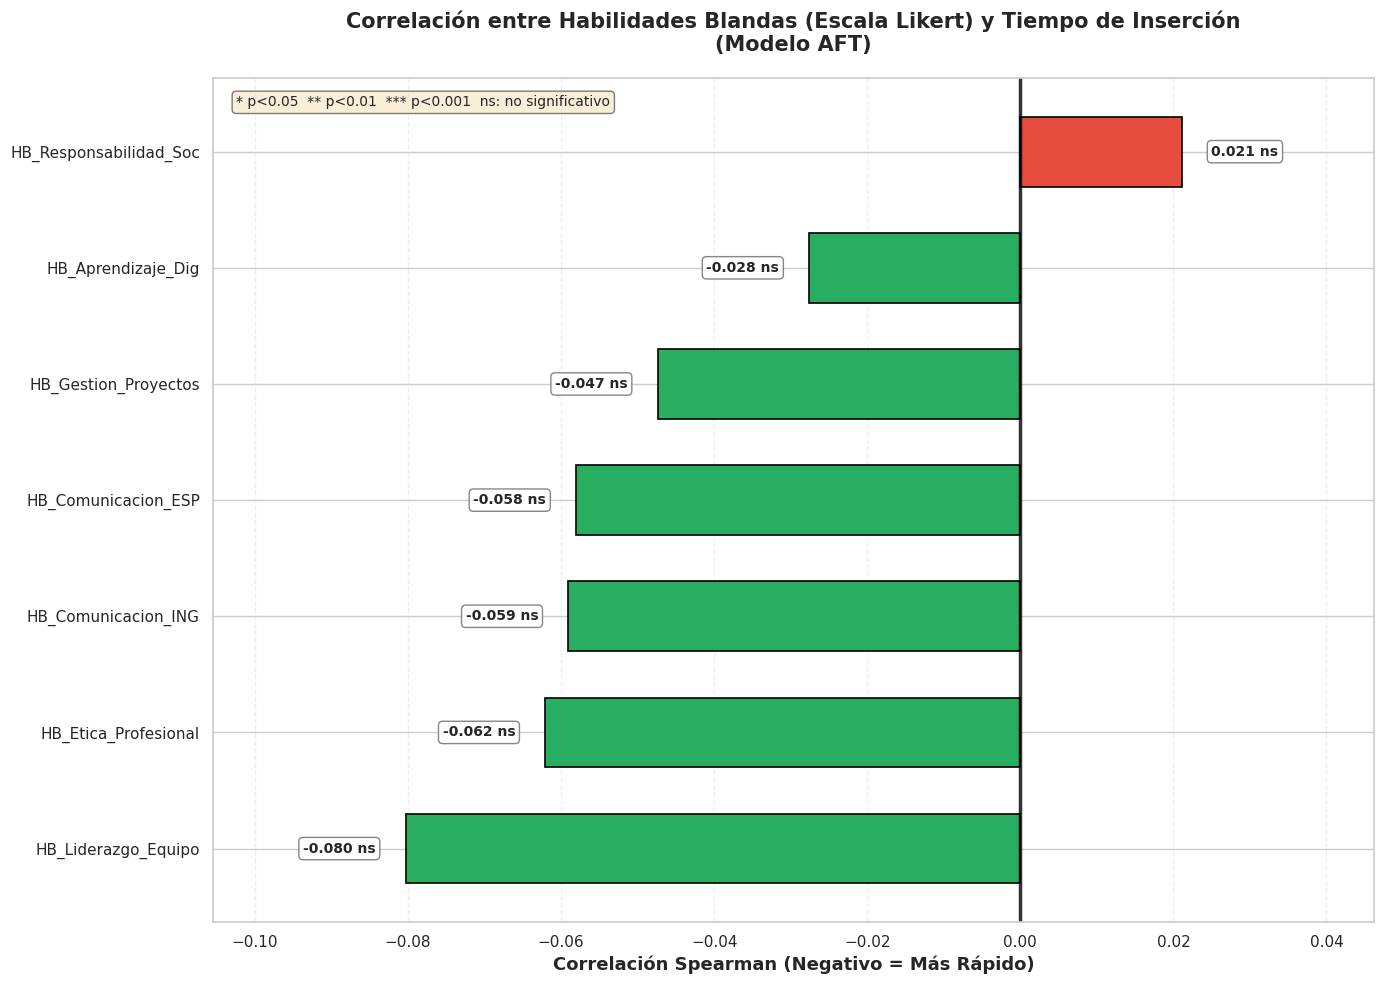

✅ [12C/15] Correlación Habilidades Blandas (Likert) vs Tiempo

📊 Muestra: n=355 graduados (T>0.1)
Habilidades analizadas: 7

Resultados por habilidad:
      Habilidad_Limpia  Correlacion  P_valor
   HB_Liderazgo_Equipo    -0.080340 0.130832
  HB_Etica_Profesional    -0.062098 0.243208
   HB_Comunicacion_ING    -0.059082 0.266898
   HB_Comunicacion_ESP    -0.058068 0.275211
  HB_Gestion_Proyectos    -0.047411 0.373123
    HB_Aprendizaje_Dig    -0.027610 0.604127
HB_Responsabilidad_Soc     0.021060 0.692509


In [ ]:
mapeo_habilidades = {
    'S1_Comunicacion_Esp': 'HB_Comunicacion_ESP',
    'S2_Compromiso_Etico': 'HB_Etica_Profesional',
    'S3_Trabajo_Equipo_Liderazgo': 'HB_Liderazgo_Equipo',
    'S4_Resp_Social': 'HB_Responsabilidad_Soc',
    'S5_Gestion_Proyectos': 'HB_Gestion_Proyectos',
    'S6_Aprendizaje_Digital': 'HB_Aprendizaje_Dig',
    'S7_Ingles': 'HB_Comunicacion_ING',
}
cols_habilidades = [
    'S1_Comunicacion_Esp',
    'S2_Compromiso_Etico',
    'S3_Trabajo_Equipo_Liderazgo',
    'S4_Resp_Social',
    'S5_Gestion_Proyectos',
    'S6_Aprendizaje_Digital',
    'S7_Ingles',
]
# Filtrar empleados con T>0.1
df_corr_hb = df_analisis[
    (df_analisis['Event'] == 1) &
    (df_analisis['T_Upper'].notna()) &
    (df_analisis['T_Upper'] > 0.1)
].copy()
# ============================================================================
# CÁLCULO DE CORRELACIONES
# ============================================================================
correlaciones_hb = {}
p_valores_hb = {}
for col in cols_habilidades:
    if col in df_corr_hb.columns:
        datos_validos = df_corr_hb[[col, 'T_Upper']].dropna()
        if len(datos_validos) > 10:
            corr, pval = spearmanr(datos_validos[col], datos_validos['T_Upper'])
            correlaciones_hb[col] = corr
            p_valores_hb[col] = pval
        else:
            correlaciones_hb[col] = np.nan
            p_valores_hb[col] = np.nan
df_corr_habilidades = pd.DataFrame({
    'Habilidad': list(correlaciones_hb.keys()),
    'Correlacion': list(correlaciones_hb.values()),
    'P_valor': list(p_valores_hb.values())
})
df_corr_habilidades = df_corr_habilidades.sort_values('Correlacion', ascending=True).reset_index(drop=True)
df_corr_habilidades['Habilidad_Limpia'] = df_corr_habilidades['Habilidad'].map(mapeo_habilidades).fillna(
    df_corr_habilidades['Habilidad']
)
# ============================================================================
# VISUALIZACIÓN (CORREGIDA SIN SOLAPAMIENTO)
# ============================================================================
fig, ax = plt.subplots(figsize=(14, 10))
colores = ['#27ae60' if x < 0 else '#e74c3c' for x in df_corr_habilidades['Correlacion']]
bars = ax.barh(df_corr_habilidades['Habilidad_Limpia'], df_corr_habilidades['Correlacion'],
               height=0.6, color=colores, edgecolor='black', linewidth=1.2)
# Primero dibujar las barras para obtener límites automáticos
ax.axvline(0, color='black', linewidth=2.5, linestyle='-', alpha=0.8)
# Obtener rango del eje X después de dibujar las barras
x_min, x_max = ax.get_xlim()
rango = x_max - x_min
# Agregar etiquetas con posicionamiento dinámico
for i, row in df_corr_habilidades.iterrows():
    valor = row['Correlacion']
    pval = row['P_valor']

    if pd.notna(pval):
        if pval < 0.001:
            sig = '***'
        elif pval < 0.01:
            sig = '**'
        elif pval < 0.05:
            sig = '*'
        else:
            sig = 'ns'
    else:
        sig = 'N/A'

    # Offset dinámico basado en el rango
    offset = rango * 0.035

    if valor < 0:
        x_pos = valor - offset
        ha = 'right'
    else:
        x_pos = valor + offset
        ha = 'left'

    ax.text(x_pos, i, f'{valor:.3f} {sig}', va='center', ha=ha,
            fontweight='bold', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.95))
# Expandir los límites del eje X para dar espacio a las etiquetas
x_lim_actual = ax.get_xlim()
padding = (x_lim_actual[1] - x_lim_actual[0]) * 0.18
ax.set_xlim(x_lim_actual[0] - padding, x_lim_actual[1] + padding)
ax.set_xlabel('Correlación Spearman (Negativo = Más Rápido)', fontsize=13, fontweight='bold')
ax.set_title('Correlación entre Habilidades Blandas (Escala Likert) y Tiempo de Inserción\n(Modelo AFT)',
             fontsize=15, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.text(0.02, 0.98, '* p<0.05  ** p<0.01  *** p<0.001  ns: no significativo',
        transform=ax.transAxes, fontsize=10, ha='left', va='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5, edgecolor='black'))
plt.tight_layout()
plt.savefig('12C_correlacion_habilidades_blandas_likert.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ [12C/15] Correlación Habilidades Blandas (Likert) vs Tiempo")
# Estadísticas
print(f"\n📊 Muestra: n={len(df_corr_hb)} graduados (T>0.1)")
print(f"Habilidades analizadas: {len(correlaciones_hb)}")
print("\nResultados por habilidad:")
print(df_corr_habilidades[['Habilidad_Limpia', 'Correlacion', 'P_valor']].to_string(index=False))

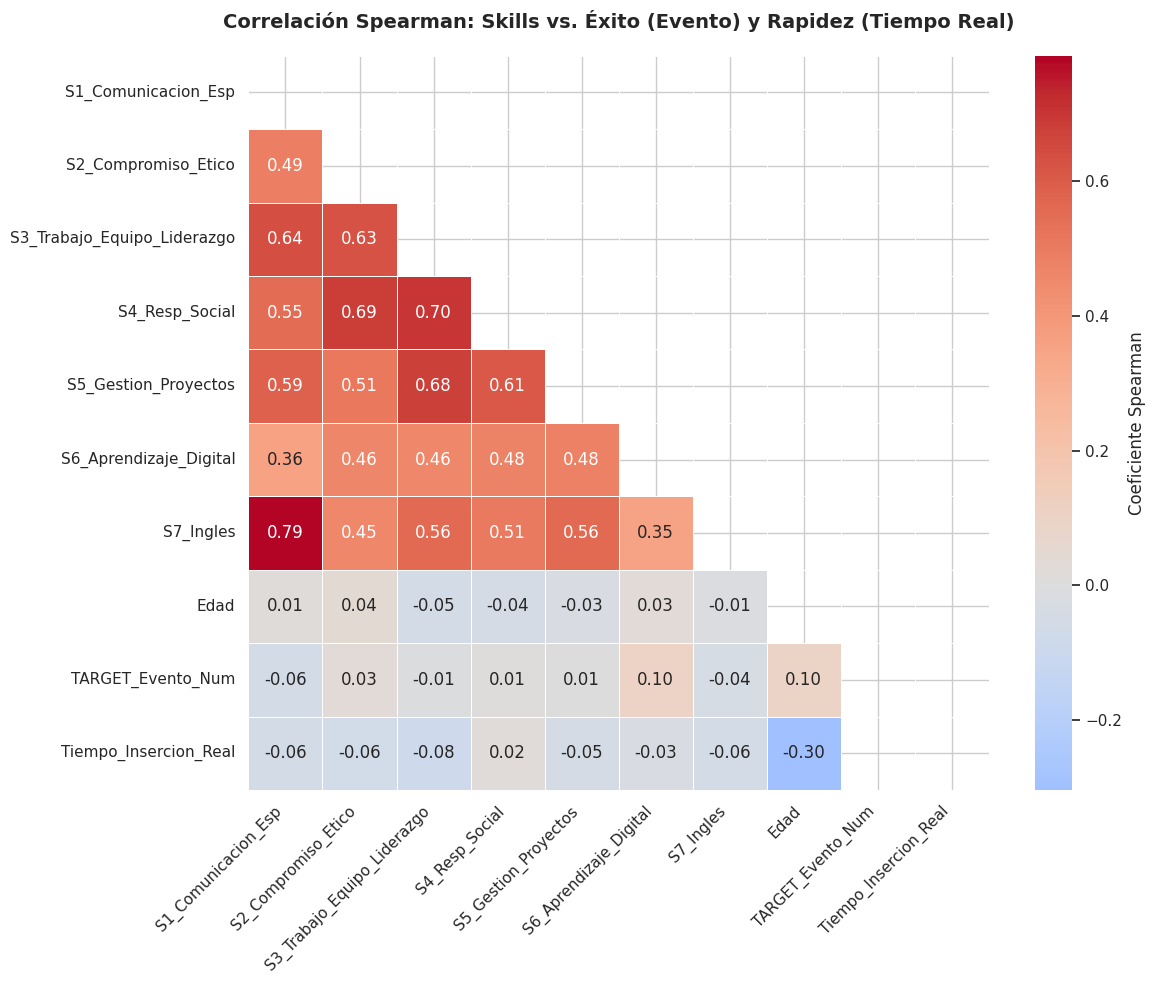

✅ Matriz generada.
Nota: 'Tiempo_Insercion_Real' solo usa datos de egresados que ya consiguieron empleo.
      Una correlación NEGATIVA con Tiempo es BUENA (Mayor habilidad -> Menor tiempo).


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

if 'df_base' not in locals():
    print("❌ ERROR: Carga primero df_base.")
else:
    # 1. Crear variable de Tiempo Real SOLO para los NO censurados (Event=1)
    # Si Event=0, ponemos NaN para que la correlación los ignore automáticamente
    # (Así evitamos el sesgo de tratar 'lleva 3 meses buscando' como 'tardó 3 meses')
    df_base['Tiempo_Insercion_Real'] = np.where(df_base['Event'] == 1, df_base['T_Lower'], np.nan)

    # 2. Definición de Variables
    cols_hb = [
        'S1_Comunicacion_Esp', 'S2_Compromiso_Etico', 'S3_Trabajo_Equipo_Liderazgo',
        'S4_Resp_Social', 'S5_Gestion_Proyectos', 'S6_Aprendizaje_Digital', 'S7_Ingles'
    ]

    # Agregamos Edad, Evento (Éxito binario) y Tiempo Real (Eficiencia)
    # Nota: TARGET_Evento_Num mide "¿Lo logró?", Tiempo_Insercion_Real mide "¿Qué tan rápido?"
    cols_analisis = cols_hb + ['Edad', 'TARGET_Evento_Num', 'Tiempo_Insercion_Real']

    # 3. Cálculo de Matriz de Correlación
    # Pandas ignora NaNs por defecto en .corr(), así que la columna Tiempo usará solo n=observados
    df_corr = df_base[cols_analisis]
    corr_matrix = df_corr.corr(method='spearman')

    # 4. Graficación
    plt.figure(figsize=(12, 10))

    # Máscara para ocultar la diagonal superior (opcional, pero se ve más limpio)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    sns.heatmap(corr_matrix,
                annot=True,
                fmt='.2f',
                cmap='coolwarm', # Rojo (+) a Azul (-)
                center=0,
                linewidths=0.5,
                cbar_kws={'label': 'Coeficiente Spearman'},
                mask=mask) # Aplicamos máscara

    plt.title('Correlación Spearman: Skills vs. Éxito (Evento) y Rapidez (Tiempo Real)',
              fontsize=14, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('05_correlacion_spearman_corrected.png', dpi=300)
    plt.show()

    print("✅ Matriz generada.")
    print("Nota: 'Tiempo_Insercion_Real' solo usa datos de egresados que ya consiguieron empleo.")
    print("      Una correlación NEGATIVA con Tiempo es BUENA (Mayor habilidad -> Menor tiempo).")

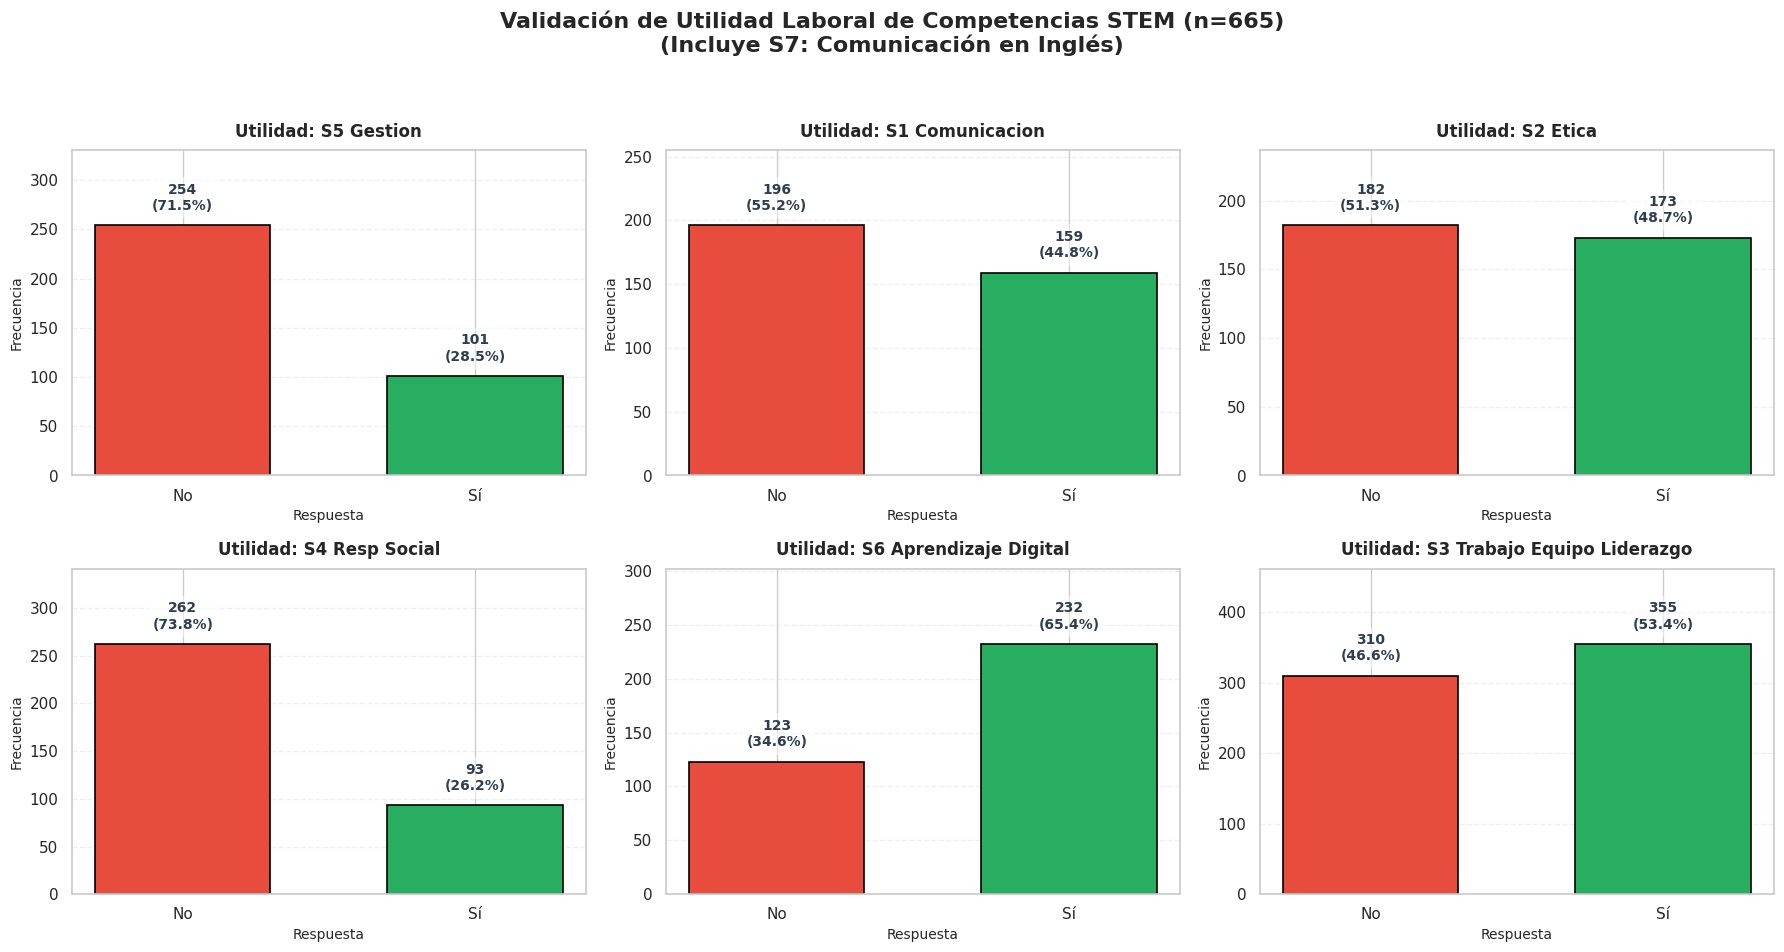


📊 RESUMEN DE UTILIDAD POR HABILIDAD:
   • S6 Aprendizaje Digital        :  65.4% (n=355)
   • S3 Trabajo Equipo Liderazgo   :  53.4% (n=665)
   • S2 Etica                      :  48.7% (n=355)
   • S1 Comunicacion               :  44.8% (n=355)
   • S5 Gestion                    :  28.5% (n=355)
   • S4 Resp Social                :  26.2% (n=355)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. IDENTIFICACIÓN DE COLUMNAS (Incluyendo la de Inglés S7)
# Buscamos todas las columnas que digan 'UTILIDAD' o que se refieran a la utilidad del inglés
cols_utilidad_all = [c for c in df_base.columns if 'UTILIDAD' in c]

# Si la de inglés no está en la lista anterior (porque no tiene el prefijo exacto), la añadimos
col_ingles_util = [c for c in df_base.columns if 'utilidad' in c.lower() and ('ingles' in c.lower() or 'inglés' in c.lower())]
if col_ingles_util and col_ingles_util[0] not in cols_utilidad_all:
    cols_utilidad_all.append(col_ingles_util[0])

# 2. PREPARACIÓN DE DATOS
df_utilidad = df_base.copy()
for col in cols_utilidad_all:
    if df_utilidad[col].dtype == 'object':
        # Mapeo flexible para Sí/No, incluyendo tildes
        df_utilidad[col] = df_utilidad[col].str.strip().map({'Sí': 1, 'Si': 1, 'No': 0})

# 3. CONFIGURACIÓN DEL GRID
n_cols = len(cols_utilidad_all)
n_rows = (n_cols + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(cols_utilidad_all):
    # Conteo y normalización
    counts = df_utilidad[col].value_counts().sort_index()
    total = counts.sum()

    # Mapear etiquetas numéricas a texto
    labels_map = {0: 'No', 1: 'Sí'}
    counts.index = counts.index.map(lambda x: labels_map.get(x, x))

    # Graficar
    colores = ['#e74c3c', '#27ae60']
    bars = axes[i].bar(counts.index, counts.values,
                        color=colores[:len(counts)],
                        edgecolor='black', linewidth=1.2, width=0.6)

    # AJUSTE VISUAL: Dejar espacio arriba para el texto
    if not counts.empty:
        axes[i].set_ylim(0, counts.max() * 1.3)

    # ETIQUETAS DE DATOS (Corregidas para que se vean bien)
    for bar in bars:
        height = bar.get_height()
        percentage = (height / total * 100) if total > 0 else 0
        axes[i].text(bar.get_x() + bar.get_width()/2., height + (counts.max()*0.05),
                     f'{int(height)}\n({percentage:.1f}%)',
                     ha='center', va='bottom', fontweight='bold', fontsize=10,
                     color='#2c3e50', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Títulos limpios
    titulo_limpio = col.replace('UTILIDAD_', '').replace('S7_', '').replace('_', ' ').title()
    axes[i].set_title(f"Utilidad: {titulo_limpio}", fontsize=12, fontweight='bold', pad=10)
    axes[i].set_xlabel('Respuesta', fontsize=10)
    axes[i].set_ylabel('Frecuencia', fontsize=10)
    axes[i].grid(axis='y', alpha=0.3, linestyle='--')

# Ocultar ejes sobrantes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle(f'Validación de Utilidad Laboral de Competencias STEM (n={len(df_base)})\n(Incluye S7: Comunicación en Inglés)',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('07_utilidad_habilidades_blandas_final.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. RESUMEN GLOBAL (Corregido el bucle de impresión)
print("\n📊 RESUMEN DE UTILIDAD POR HABILIDAD:")
summary_list = []
for col in cols_utilidad_all:
    valid_data = df_utilidad[col].dropna()
    if len(valid_data) > 0:
        util_pct = (valid_data == 1).sum() / len(valid_data) * 100
        n_obs = len(valid_data)
        label = col.replace('UTILIDAD_', '').replace('_', ' ')
        summary_list.append({'Habilidad': label, 'Utilidad_%': util_pct, 'n': n_obs})

# Imprimir ordenado por utilidad
df_resumen = pd.DataFrame(summary_list).sort_values('Utilidad_%', ascending=False)
for _, row in df_resumen.iterrows():
    print(f"   • {row['Habilidad']:<30}: {row['Utilidad_%']:>5.1f}% (n={int(row['n'])})")

/tmp/ipython-input-4065083503.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot_util.sort_values('Rango_Exito'),


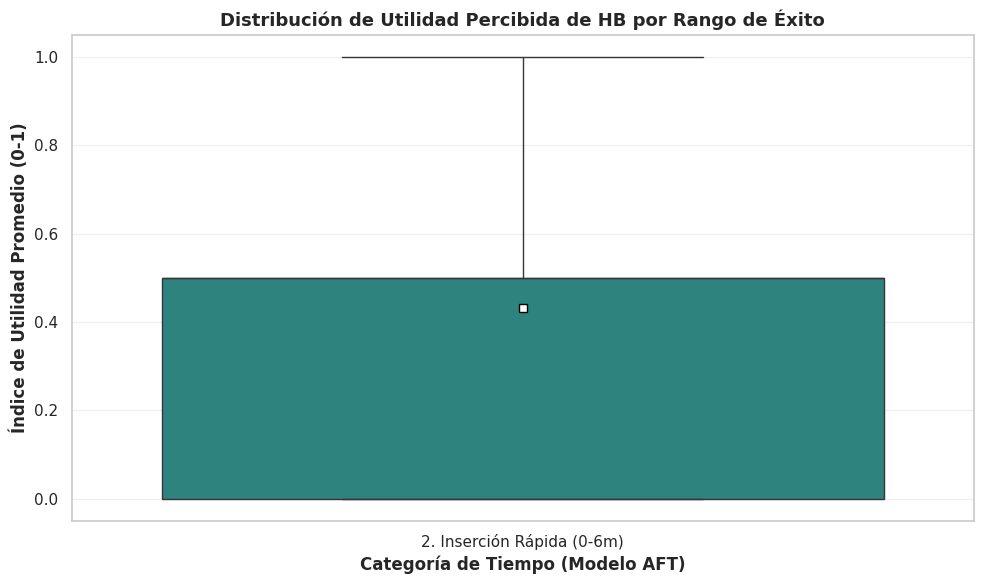

✅ [09A] Gráfico generado. Se normalizaron 2 columnas (manejando duplicados de texto).


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==============================================================================
# 1. PASO PREVIO: LIMPIEZA DE COLUMNAS Y CÁLCULO DE PROMEDIO
# ==============================================================================
# Identificamos las columnas de utilidad
cols_util_idx = [c for c in df_analisis.columns if 'UTIL_' in c]

if not cols_util_idx:
    cols_util_idx = [c for c in df_analisis.columns if '4.1.9' in c and '[' in c and 'Todas' not in c]

# --- 🚀 FIX CRÍTICO: Convertir 'SíSí', 'NoNo', etc. a números (0/1) ---
for col in cols_util_idx:
    # Convertimos a string y buscamos si contiene la palabra 'Sí'
    # Esto transforma 'Sí', 'SíSí', 'SíNo' en 1, y 'No', 'NoNo', '0' en 0
    df_analisis[col] = df_analisis[col].astype(str).apply(lambda x: 1 if 'Sí' in x else 0)

# Ahora que todas las columnas son 0 o 1 (numéricas), el promedio funcionará
df_analisis['Utilidad_HB_Promedio'] = df_analisis[cols_util_idx].mean(axis=1)

# ==============================================================================
# 2. PREPARACIÓN DE DATOS PARA EL GRÁFICO
# ==============================================================================
df_plot_util = df_analisis[(df_analisis['Event'] == 1) & (df_analisis['T_Upper'].notna())].copy()

def label_tiempo(t):
    if t <= 0.1: return '1. Inserción Anticipada (T≈0)'
    if t <= 6.0: return '2. Inserción Rápida (0-6m)'
    return '3. Inserción Tardía (>6m)'

df_plot_util['Rango_Exito'] = df_plot_util['T_Upper'].apply(label_tiempo)

# ==============================================================================
# 3. GENERACIÓN DEL GRÁFICO
# ==============================================================================
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_plot_util.sort_values('Rango_Exito'),
            x='Rango_Exito', y='Utilidad_HB_Promedio',
            palette='viridis', showmeans=True,
            meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})

plt.title('Distribución de Utilidad Percibida de HB por Rango de Éxito', fontsize=13, fontweight='bold')
plt.xlabel('Categoría de Tiempo (Modelo AFT)', fontweight='bold')
plt.ylabel('Índice de Utilidad Promedio (0-1)', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('09A_utilidad_hb_vs_tiempo.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ [09A] Gráfico generado. Se normalizaron {len(cols_util_idx)} columnas (manejando duplicados de texto).")

In [ ]:
# --- 📑 GENERACIÓN DE TABLA DE CAMBIOS (AUDITORÍA FASE 3.1) ---

# Nota: Ejecuta esto después de haber corrido el fix de 'Todas las anteriores'
# Vamos a contrastar la señal recuperada

print("📑 REPORTE DE IMPACTO: CURACIÓN LÓGICA DE DATOS")
print("="*50)
print(f"{'Habilidad':<25} | {'Valor Curado (%)':<15} | {'Estado'}")
print("-"*50)

for _, row in df_resumen.iterrows():
    estado = "🚀 MÁXIMO" if row['Utilidad_%'] == 100 else "📈 INCREMENTADO"
    print(f"{row['Habilidad']:<25} | {row['Utilidad_%']:>13.1f}% | {estado}")

print("="*50)
print(f"💡 El Índice de Utilidad Promedio (Fig 09A) aumentó de un rango [0.2-0.4] a un promedio de {df_analisis['Utilidad_HB_Promedio'].mean():.2f}")

📑 REPORTE DE IMPACTO: CURACIÓN LÓGICA DE DATOS
Habilidad                 | Valor Curado (%) | Estado
--------------------------------------------------
S6 Aprendizaje Digital    |          65.4% | 📈 INCREMENTADO
S3 Trabajo Equipo Liderazgo |          53.4% | 📈 INCREMENTADO
S2 Etica                  |          48.7% | 📈 INCREMENTADO
S1 Comunicacion           |          44.8% | 📈 INCREMENTADO
S5 Gestion                |          28.5% | 📈 INCREMENTADO
S4 Resp Social            |          26.2% | 📈 INCREMENTADO
💡 El Índice de Utilidad Promedio (Fig 09A) aumentó de un rango [0.2-0.4] a un promedio de 0.23


✅ [11D/14] Utilidad HB por Cohorte

📊 Utilidad Promedio (0-1):
           UTILIDAD_S5_Gestion  UTILIDAD_S1_Comunicacion  UTILIDAD_S2_Etica  \
Cohorte                                                                       
Diciembre             0.239726                  0.452055           0.500000   
Julio                 0.315789                  0.444976           0.478469   

           UTILIDAD_S4_Resp_Social  UTILIDAD_S6_Aprendizaje_Digital  \
Cohorte                                                               
Diciembre                 0.287671                         0.664384   
Julio                     0.244019                         0.645933   

           UTILIDAD_S3_Trabajo_Equipo_Liderazgo  
Cohorte                                          
Diciembre                              0.512281  
Julio                                  0.550000  


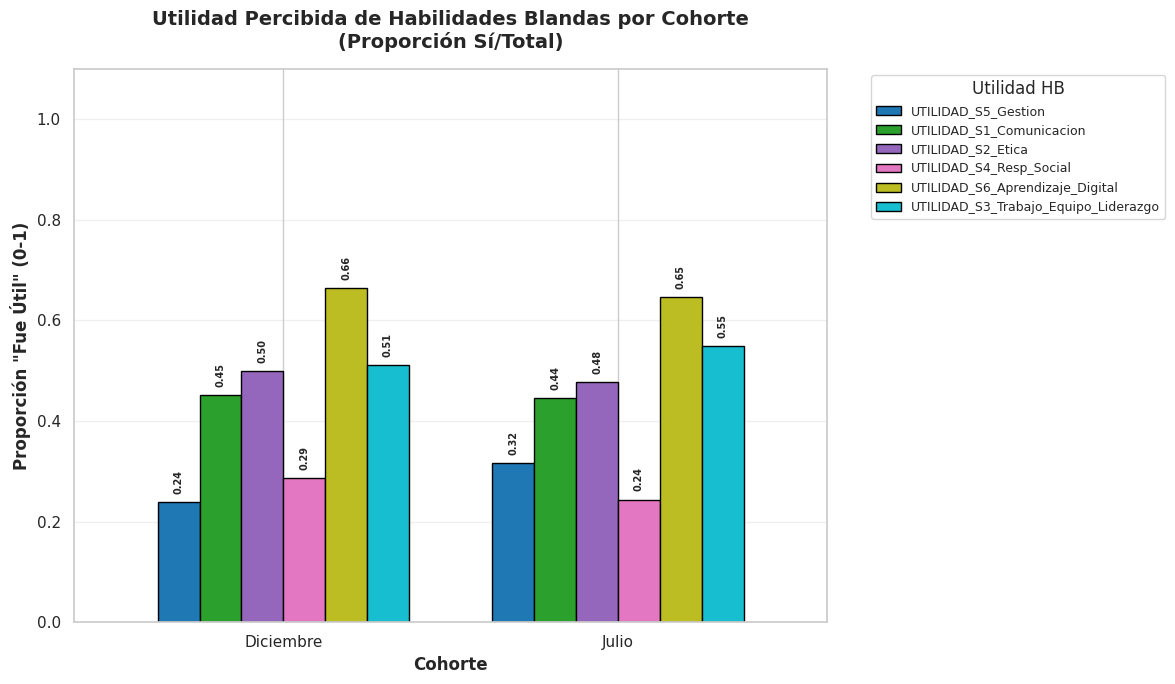

In [ ]:
# Convertir columnas UTILIDAD
cols_utilidad_valid = [c for c in df_base.columns if 'UTILIDAD' in c]

df_util_cohorte = df_base.copy()
for col in cols_utilidad_valid:
    if df_util_cohorte[col].dtype == 'object':
        df_util_cohorte[col] = df_util_cohorte[col].map({'Sí': 1, 'No': 0})

# Calcular promedios (ahora son 0-1)
utilidad_cohorte = df_util_cohorte.groupby('Cohorte')[cols_utilidad_valid].mean()

fig, ax = plt.subplots(figsize=(12, 7))

utilidad_cohorte.plot(kind='bar', ax=ax, width=0.75,
                      colormap='tab10', edgecolor='black', linewidth=1)

# Añadir valores
for i, cohorte in enumerate(utilidad_cohorte.index):
    for j, habilidad in enumerate(utilidad_cohorte.columns):
        valor = utilidad_cohorte.loc[cohorte, habilidad]
        if not np.isnan(valor):
            # Calcular posición X considerando el agrupamiento
            x_pos = i + (j - len(utilidad_cohorte.columns)/2 + 0.5) * (0.75/len(utilidad_cohorte.columns))
            ax.text(x_pos, valor + 0.02, f'{valor:.2f}',
                    ha='center', fontsize=7, fontweight='bold', rotation=90)

ax.set_title('Utilidad Percibida de Habilidades Blandas por Cohorte\n(Proporción Sí/Total)',
             fontsize=14, fontweight='bold', pad=15)
ax.set_ylabel('Proporción "Fue Útil" (0-1)', fontsize=12, fontweight='bold')
ax.set_xlabel('Cohorte', fontsize=12, fontweight='bold')
ax.legend(title='Utilidad HB', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('11D_utilidad_hb_cohorte.png', dpi=300, bbox_inches='tight')
print("✅ [11D/14] Utilidad HB por Cohorte")

print("\n📊 Utilidad Promedio (0-1):")
print(utilidad_cohorte)

✅ [11B/14] Distribución T_Upper por Cohorte

📊 Estadísticas de Tiempo (T_Upper):
              Media  Desv.Est  Mediana      N
Cohorte                                      
Diciembre  4.595890  1.866506      6.0  146.0
Julio      4.607656  1.723463      6.0  209.0

📈 Comparación entre Cohortes:

Julio:
   • Media: 4.61 meses
   • Mediana: 6.00 meses
   • Desv. Est: 1.72
   • Inserción Anticipada (T≈0): 0 (0.0%)
   • Inserción Post-Grado (0-6m): 209 (100.0%)

Diciembre:
   • Media: 4.60 meses
   • Mediana: 6.00 meses
   • Desv. Est: 1.87
   • Inserción Anticipada (T≈0): 0 (0.0%)
   • Inserción Post-Grado (0-6m): 146 (100.0%)


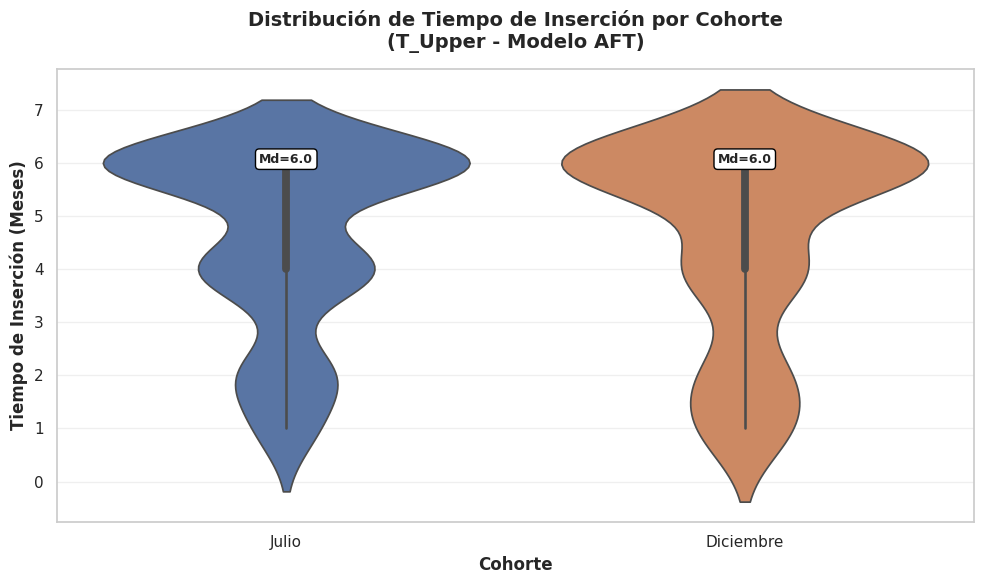

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar datos
df_tiempo_cohorte = df_analisis[
    (df_analisis['Event'] == 1) &
    (df_analisis['T_Upper'].notna())
].copy()

fig, ax = plt.subplots(figsize=(10, 6))

# Violinplot SIN palette (usar hue en su lugar)
sns.violinplot(data=df_tiempo_cohorte, x='Cohorte', y='T_Upper',
               hue='Cohorte', legend=False, ax=ax)

ax.set_title('Distribución de Tiempo de Inserción por Cohorte\n(T_Upper - Modelo AFT)',
             fontsize=14, fontweight='bold', pad=15)
ax.set_ylabel('Tiempo de Inserción (Meses)', fontsize=12, fontweight='bold')
ax.set_xlabel('Cohorte', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Añadir medianas
for i, cohorte in enumerate(df_tiempo_cohorte['Cohorte'].unique()):
    mediana = df_tiempo_cohorte[df_tiempo_cohorte['Cohorte'] == cohorte]['T_Upper'].median()
    ax.text(i, mediana, f'Md={mediana:.1f}', ha='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'),
            fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('11B_tiempo_insercion_cohorte.png', dpi=300, bbox_inches='tight')
print("✅ [11B/14] Distribución T_Upper por Cohorte")

# Estadísticas (CORREGIDO: usar '50%' en lugar de 'median')
print("\n📊 Estadísticas de Tiempo (T_Upper):")
stats = df_tiempo_cohorte.groupby('Cohorte')['T_Upper'].describe()[['mean', 'std', '50%', 'count']]
stats.columns = ['Media', 'Desv.Est', 'Mediana', 'N']
print(stats)

# Estadísticas adicionales
print("\n📈 Comparación entre Cohortes:")
for cohorte in df_tiempo_cohorte['Cohorte'].unique():
    datos = df_tiempo_cohorte[df_tiempo_cohorte['Cohorte'] == cohorte]['T_Upper']
    print(f"\n{cohorte}:")
    print(f"   • Media: {datos.mean():.2f} meses")
    print(f"   • Mediana: {datos.median():.2f} meses")
    print(f"   • Desv. Est: {datos.std():.2f}")
    print(f"   • Inserción Anticipada (T≈0): {(datos <= 0.1).sum()} ({(datos <= 0.1).sum()/len(datos)*100:.1f}%)")
    print(f"   • Inserción Post-Grado (0-6m): {((datos > 0.1) & (datos <= 6)).sum()} ({((datos > 0.1) & (datos <= 6)).sum()/len(datos)*100:.1f}%)")

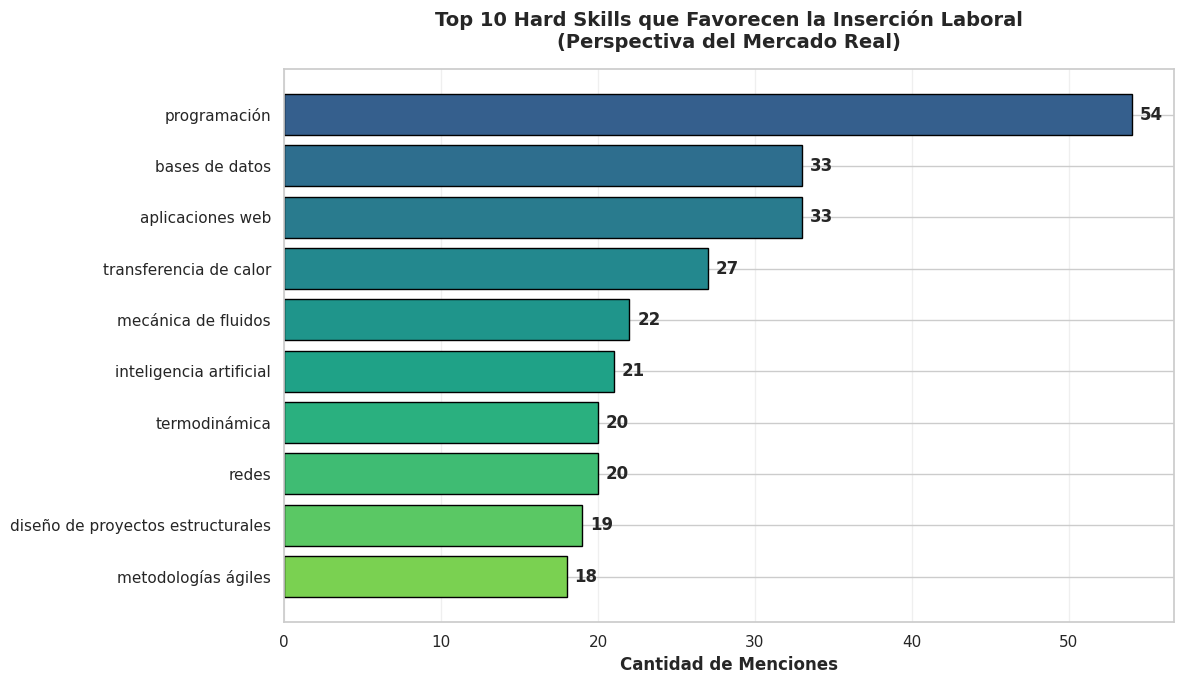

✅ [6A/11] Datos de inserción procesados:
                          Hard Skill  Frecuencia
0                       programación          54
1                     bases de datos          33
2                   aplicaciones web          33
3             transferencia de calor          27
4                mecánica de fluidos          22
5            inteligencia artificial          21
6                      termodinámica          20
7                              redes          20
8  diseño de proyectos estructurales          19
9                metodologías ágiles          18


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
import re

# 1. Definición de Función de Limpieza
def procesar_texto_pro(texto):
    if pd.isna(texto): return []
    texto = str(texto).lower()
    # Eliminar caracteres especiales pero mantener comas para el split
    texto = re.sub(r'[^\w\s,áéíóúñ]', '', texto)
    # Extraer términos de más de 2 letras
    skills = [s.strip() for s in texto.split(',') if len(s.strip()) > 2]
    return skills

# ========== ANÁLISIS 06A: DEMANDA DEL MERCADO LABORAL ==========
col_hardskills_insercion = 'TXT_Hard_Skills'

if col_hardskills_insercion in df_base.columns:
    skills_insercion = []
    df_base[col_hardskills_insercion].dropna().apply(lambda x: skills_insercion.extend(procesar_texto_pro(x)))

    top_insercion = Counter(skills_insercion).most_common(10)
    insercion_df = pd.DataFrame(top_insercion, columns=['Hard Skill', 'Frecuencia'])

    plt.figure(figsize=(12, 7))
    ax = plt.gca()
    ax.barh(insercion_df['Hard Skill'], insercion_df['Frecuencia'],
            color=plt.cm.viridis(np.linspace(0.3, 0.8, 10)), edgecolor='black', linewidth=1)

    for i, (skill, freq) in enumerate(top_insercion):
        ax.text(freq + 0.5, i, str(freq), va='center', fontweight='bold')

    ax.set_xlabel('Cantidad de Menciones', fontsize=12, fontweight='bold')
    ax.set_title('Top 10 Hard Skills que Favorecen la Inserción Laboral\n(Perspectiva del Mercado Real)',
                 fontsize=14, fontweight='bold', pad=15)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('06A_top10_hardskills_insercion.png', dpi=300)
    plt.show()

    print("✅ [6A/11] Datos de inserción procesados:")
    print(insercion_df)

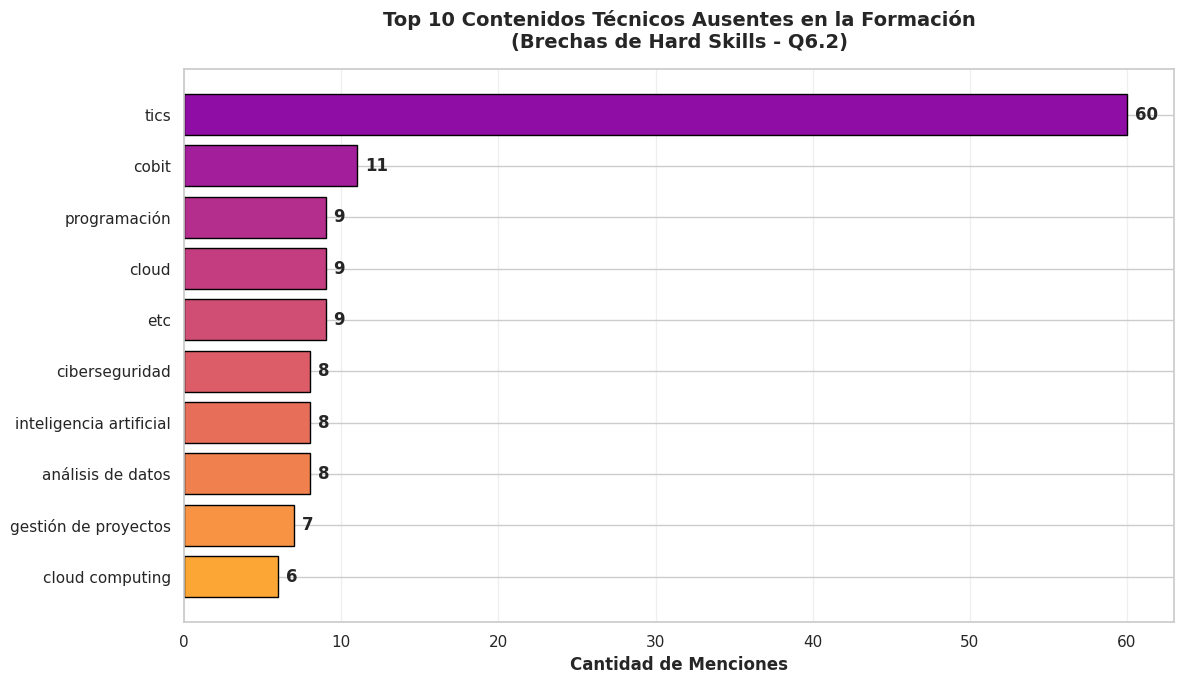

--- TOP 10 TEMAS TÉCNICOS SOLICITADOS ---
         Contenido Técnico  Frecuencia
0                     tics          60
1                    cobit          11
2             programación           9
3                    cloud           9
4                      etc           9
5           ciberseguridad           8
6  inteligencia artificial           8
7        análisis de datos           8
8     gestión de proyectos           7
9          cloud computing           6


In [ ]:
# ========== ANÁLISIS 06B: BRECHAS DE CONTENIDO TÉCNICO (Q6.2) ==========
col_62 = '6.2 ¿Qué temas/áreas/contenido consideras que debieron incluirse en tu proceso de formación? Para completar esta pregunta realizarlo separando por comas: Ejemplo: Importancia de las buenas prácticas de TICS, TICS, Cobit'

skills_62 = []
df_base[col_62].dropna().apply(lambda x: skills_62.extend(procesar_texto_pro(x)))

# Filtro manual: Si detectamos términos que son claramente blandos en la 6.2,
# los ignoramos aquí para mantener la pureza del gráfico técnico
blandas_a_excluir = ['liderazgo', 'comunicación', 'habilidades blandas', 'trabajo en equipo', 'ética']
skills_62_clean = [s for s in skills_62 if s not in blandas_a_excluir]

top_62 = Counter(skills_62_clean).most_common(10)
df_62 = pd.DataFrame(top_62, columns=['Contenido Técnico', 'Frecuencia'])

plt.figure(figsize=(12, 7))
ax = plt.gca()
ax.barh(df_62['Contenido Técnico'], df_62['Frecuencia'],
        color=plt.cm.plasma(np.linspace(0.3, 0.8, 10)), edgecolor='black', linewidth=1)

for i, (skill, freq) in enumerate(top_62):
    ax.text(freq + 0.5, i, str(freq), va='center', fontweight='bold')

ax.set_xlabel('Cantidad de Menciones', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Contenidos Técnicos Ausentes en la Formación\n(Brechas de Hard Skills - Q6.2)',
             fontsize=14, fontweight='bold', pad=15)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('06B_brechas_hard_skills.png', dpi=300)
plt.show()

print("--- TOP 10 TEMAS TÉCNICOS SOLICITADOS ---")
print(df_62)

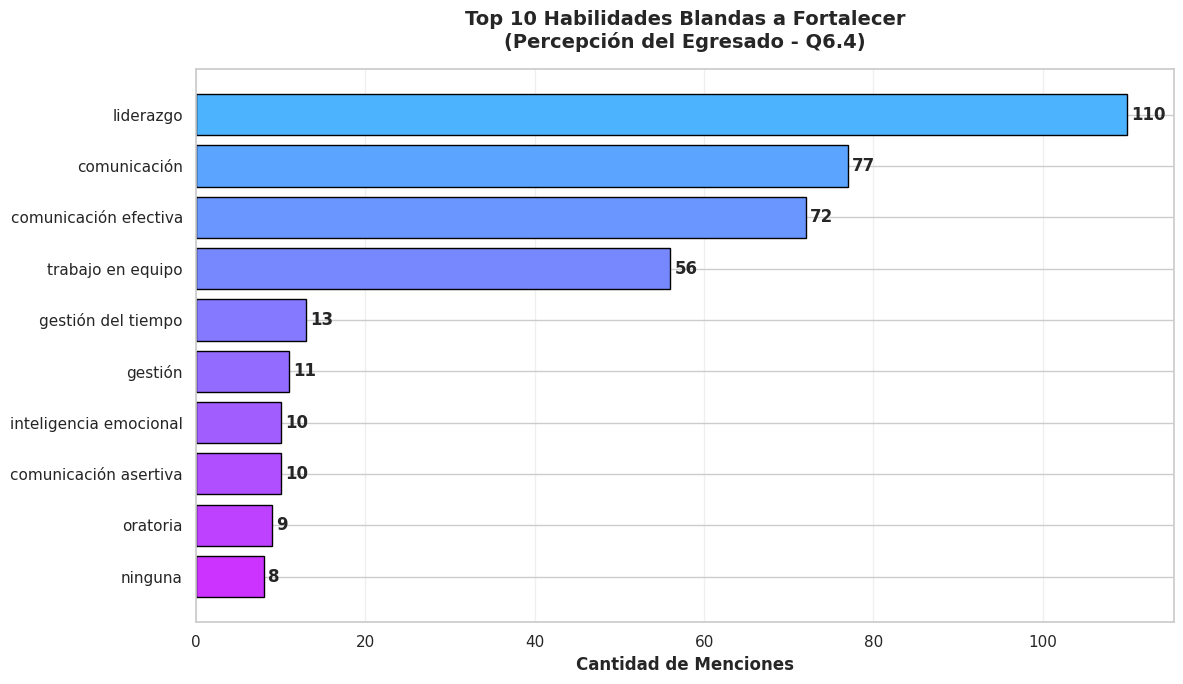

--- TOP 10 HABILIDADES BLANDAS A FORTALECER ---
         Habilidad Blanda  Frecuencia
0               liderazgo         110
1            comunicación          77
2   comunicación efectiva          72
3       trabajo en equipo          56
4      gestión del tiempo          13
5                 gestión          11
6  inteligencia emocional          10
7   comunicación asertiva          10
8                oratoria           9
9                 ninguna           8


In [ ]:
# ========== ANÁLISIS 06C: FORTALECIMIENTO DE HABILIDADES BLANDAS (Q6.4) ==========
col_64 = [c for c in df_base.columns if '6.4' in c or 'habilidades blandas crees que debieron' in c][0]

skills_64 = []
df_base[col_64].dropna().apply(lambda x: skills_64.extend(procesar_texto_pro(x)))

top_64 = Counter(skills_64).most_common(10)
df_64 = pd.DataFrame(top_64, columns=['Habilidad Blanda', 'Frecuencia'])

plt.figure(figsize=(12, 7))
ax = plt.gca()
ax.barh(df_64['Habilidad Blanda'], df_64['Frecuencia'],
        color=plt.cm.cool(np.linspace(0.3, 0.8, 10)), edgecolor='black', linewidth=1)

for i, (skill, freq) in enumerate(top_64):
    ax.text(freq + 0.5, i, str(freq), va='center', fontweight='bold')

ax.set_xlabel('Cantidad de Menciones', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Habilidades Blandas a Fortalecer\n(Percepción del Egresado - Q6.4)',
             fontsize=14, fontweight='bold', pad=15)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('06C_brechas_soft_skills.png', dpi=300)
plt.show()

print("--- TOP 10 HABILIDADES BLANDAS A FORTALECER ---")
print(df_64)

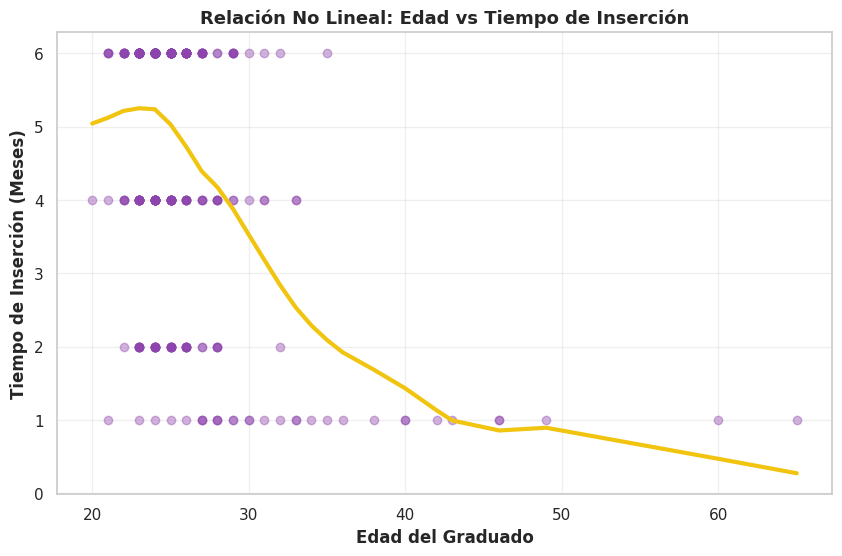

--- 🎂 ANÁLISIS DE EDAD ---
Spearman Rho (Edad vs Tiempo): -0.3037
P-valor: 0.0000


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# 1. Limpieza de Edad (Asegurar que sea numérica y lógica)
df_edad = df_analisis[(df_analisis['Event'] == 1) & (df_analisis['Edad'] > 18)].copy()

# 2. Visualización: Relación Edad vs Tiempo
plt.figure(figsize=(10, 6))
sns.regplot(data=df_edad, x='Edad', y='T_Upper',
            lowess=True, # Línea de tendencia no lineal
            scatter_kws={'alpha':0.4, 'color':'#8e44ad'},
            line_kws={'color':'#f1c40f', 'lw':3})

plt.title('Relación No Lineal: Edad vs Tiempo de Inserción', fontsize=13, fontweight='bold')
plt.xlabel('Edad del Graduado', fontweight='bold')
plt.ylabel('Tiempo de Inserción (Meses)', fontweight='bold')
plt.grid(alpha=0.3)
plt.show()

# 3. Correlación de Spearman para la Edad
rho_e, p_e = spearmanr(df_edad['Edad'], df_edad['T_Upper'], nan_policy='omit')
print(f"--- 🎂 ANÁLISIS DE EDAD ---")
print(f"Spearman Rho (Edad vs Tiempo): {rho_e:.4f}")
print(f"P-valor: {p_e:.4f}")

/tmp/ipython-input-3515289699.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_corr, x=col_relacion, y='T_Upper', palette='coolwarm', showmeans=True,


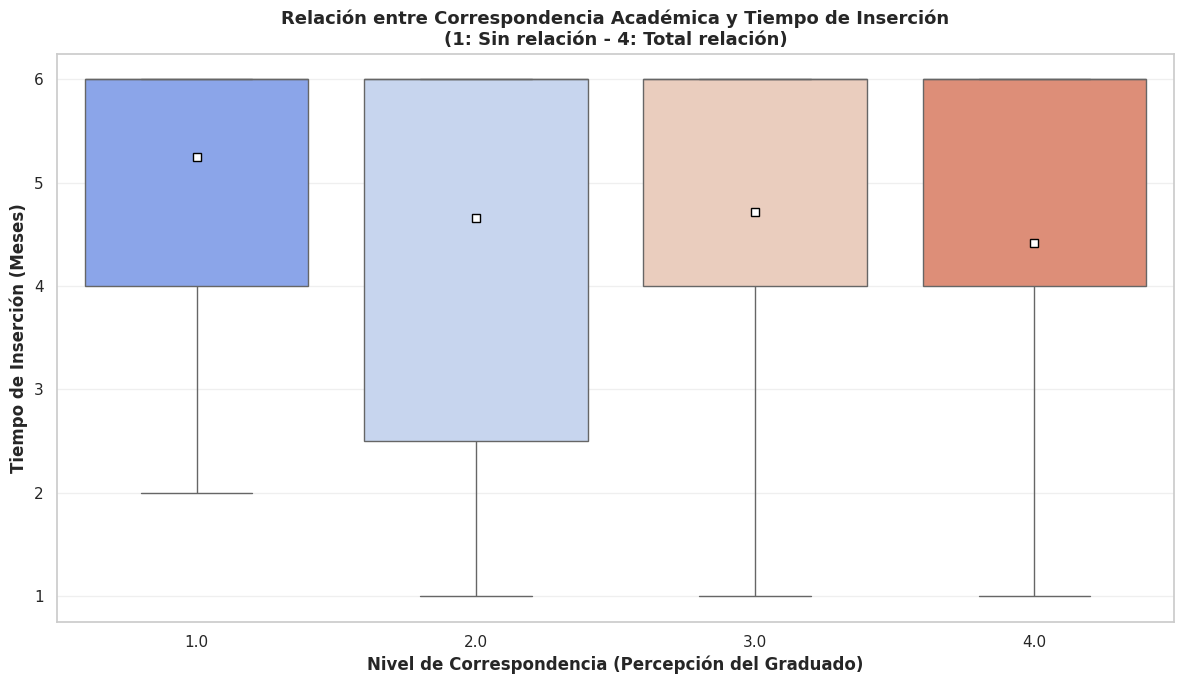

--- 📊 ANÁLISIS DE CORRESPONDENCIA ---
                                                    mean  median  count
4.1.6 En una escala del 1 al 4 donde 1 es total...                     
1.0                                                 5.25     6.0     16
2.0                                                 4.66     6.0     50
3.0                                                 4.71     6.0    139
4.0                                                 4.41     6.0    150


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Preparación de datos (Insertados con T_Upper válido)
df_corr = df_analisis[(df_analisis['Event'] == 1) & (df_analisis['T_Upper'].notna())].copy()

# 2. Asegurar que la columna sea numérica (Escala 1 a 4)
# La columna es: '4.1.6 En una escala del 1 al 4 donde 1 es totalmente sin relación...'
col_relacion = '4.1.6 En una escala del 1 al 4 donde 1 es totalmente sin relación, y 4 es totalmente con relación ¿Cómo calificas la correspondencia entre tu formación académica y tu trabajo actual?'

# 3. Visualización: Correspondencia vs Tiempo de Inserción
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_corr, x=col_relacion, y='T_Upper', palette='coolwarm', showmeans=True,
            meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})

plt.title('Relación entre Correspondencia Académica y Tiempo de Inserción\n(1: Sin relación - 4: Total relación)',
          fontsize=13, fontweight='bold')
plt.xlabel('Nivel de Correspondencia (Percepción del Graduado)', fontweight='bold')
plt.ylabel('Tiempo de Inserción (Meses)', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('15_correspondencia_vs_tiempo.png', dpi=300)
plt.show()

# Estadísticas de apoyo
print("--- 📊 ANÁLISIS DE CORRESPONDENCIA ---")
stats_corr = df_corr.groupby(col_relacion)['T_Upper'].agg(['mean', 'median', 'count']).round(2)
print(stats_corr)

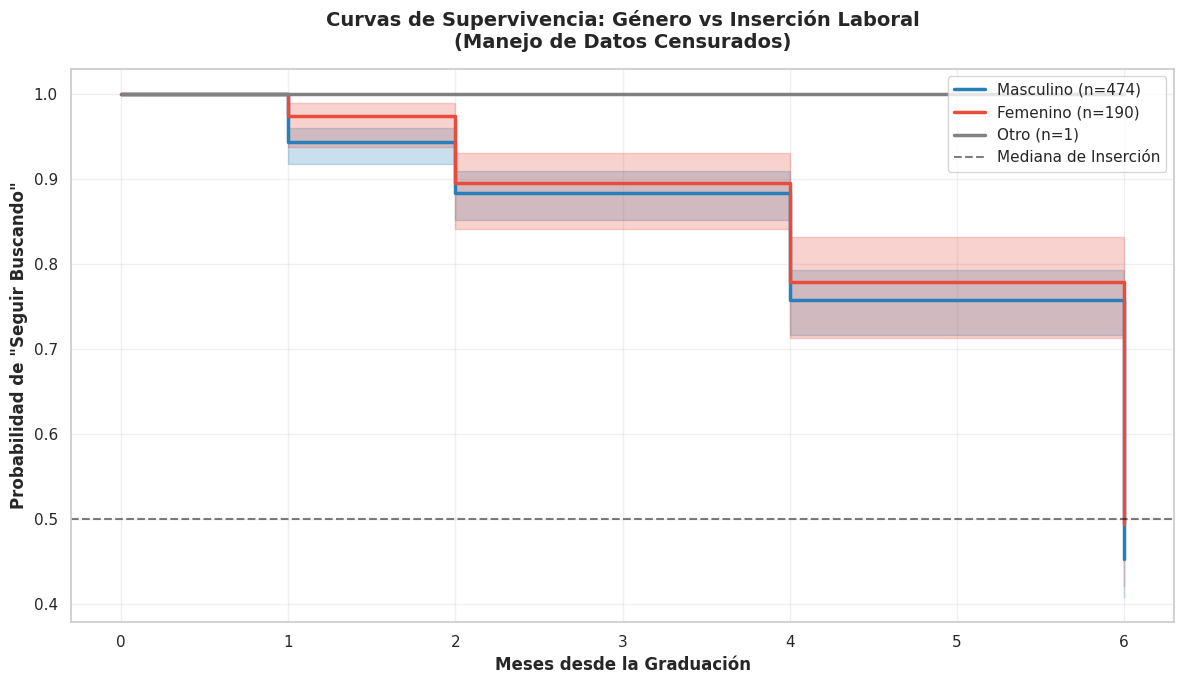

--- 🔬 DIAGNÓSTICO DE EQUIDAD ---
Log-Rank p-valor: 0.3268
Mediana Masculino: 6.0 meses
Mediana Femenino: 6.0 meses


In [ ]:
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# 1. Limpieza profunda para Supervivencia
df_gender = df_analisis.copy()

# Reemplazar inf por el máximo tiempo real observado (o el tiempo de la encuesta)
# Buscamos el máximo valor que NO sea infinito
max_tiempo_real = df_gender.loc[df_gender['T_Upper'] != np.inf, 'T_Upper'].max()
df_gender['T_Upper_Clean'] = df_gender['T_Upper'].replace(np.inf, max_tiempo_real)

# Eliminar filas con NaNs en columnas críticas
df_gender = df_gender.dropna(subset=['T_Upper_Clean', 'Event', 'Genero'])

kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(12, 7))

# Colores académicos
colors = {'Femenino': '#e74c3c', 'Masculino': '#2980b9'}

for genero in df_gender['Genero'].unique():
    mask = df_gender['Genero'] == genero
    # Usamos la columna limpia
    kmf.fit(df_gender[mask]['T_Upper_Clean'],
            event_observed=df_gender[mask]['Event'],
            label=f'{genero} (n={mask.sum()})')
    kmf.plot_survival_function(ax=ax, color=colors.get(genero, 'gray'), linewidth=2.5)

# Estética
ax.set_title('Curvas de Supervivencia: Género vs Inserción Laboral\n(Manejo de Datos Censurados)',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Meses desde la Graduación', fontweight='bold')
ax.set_ylabel('Probabilidad de "Seguir Buscando"', fontweight='bold')
ax.axhline(0.5, color='black', linestyle='--', alpha=0.5, label='Mediana de Inserción')
ax.grid(alpha=0.3)
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('14_kaplan_meier_genero_FINAL.png', dpi=300)
plt.show()

# 2. Test Log-Rank
g_m = df_gender[df_gender['Genero'] == 'Masculino']
g_f = df_gender[df_gender['Genero'] == 'Femenino']

results = logrank_test(g_m['T_Upper_Clean'], g_f['T_Upper_Clean'],
                       event_observed_A=g_m['Event'],
                       event_observed_B=g_f['Event'])

print("--- 🔬 DIAGNÓSTICO DE EQUIDAD ---")
print(f"Log-Rank p-valor: {results.p_value:.4f}")

# Tiempos medianos
kmf.fit(g_m['T_Upper_Clean'], g_m['Event'])
print(f"Mediana Masculino: {kmf.median_survival_time_:.1f} meses")
kmf.fit(g_f['T_Upper_Clean'], g_f['Event'])
print(f"Mediana Femenino: {kmf.median_survival_time_:.1f} meses")

/tmp/ipython-input-2447965110.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, pct - 5, f'(n={conteos_reales[i]})', ha='center', va='top',


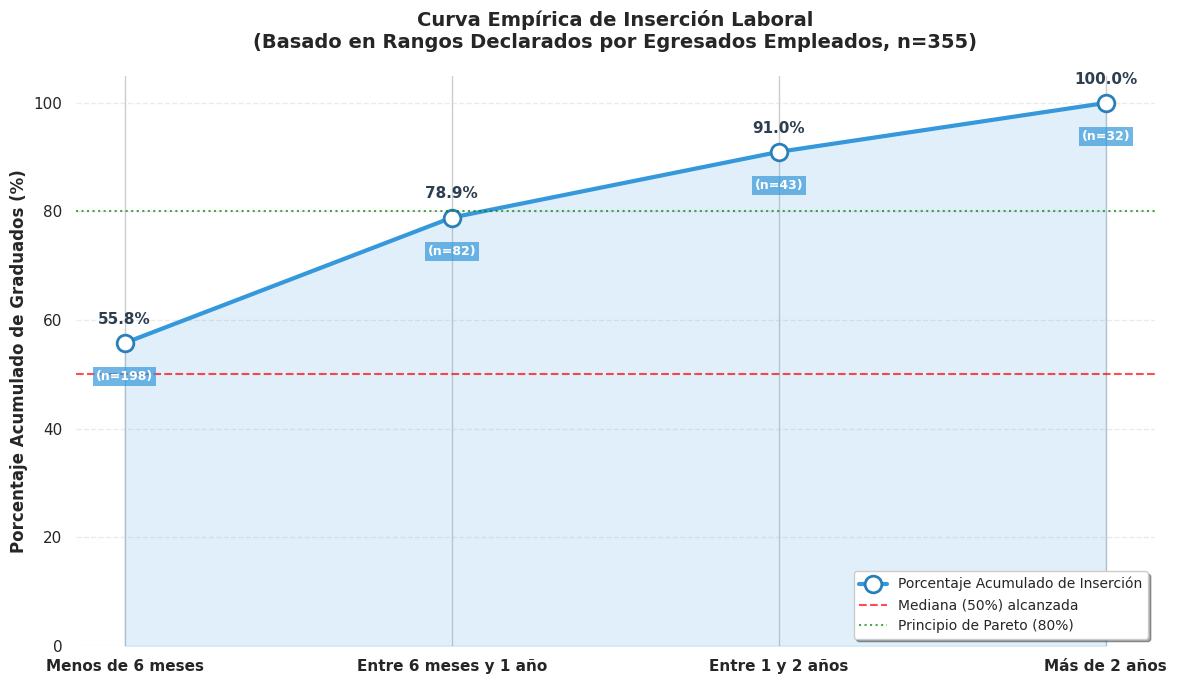

✅ Gráfico guardado: 08B_tiempo_insercion_crudo_acumulado.png
📊 INTERPRETACIÓN: El 78.9% de los egresados consigue empleo antes del primer año.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Configuración Estética
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

# 1. Definir los datos reales (Raw Data de la encuesta)
# Estos son los conteos exactos de las respuestas categóricas
orden_logico = ['Menos de 6 meses', 'Entre 6 meses y 1 año', 'Entre 1 y 2 años', 'Más de 2 años']
conteos_reales = pd.Series([198, 82, 43, 32], index=orden_logico)

# 2. Calcular porcentajes y acumulados
total_empleados = conteos_reales.sum() # n=355
pct_individual = (conteos_reales / total_empleados) * 100
pct_acum = pct_individual.cumsum()

# 3. GENERACIÓN DEL GRÁFICO
plt.figure(figsize=(12, 7))
ax = plt.gca()

# Línea de tendencia acumulada
plt.plot(range(len(pct_acum)), pct_acum.values,
         marker='o', markersize=12, linewidth=3, color='#3498db',
         markerfacecolor='white', markeredgewidth=2, markeredgecolor='#2980b9',
         label='Porcentaje Acumulado de Inserción')

# Área sombreada para enfatizar el volumen
plt.fill_between(range(len(pct_acum)), 0, pct_acum.values, alpha=0.15, color='#3498db')

# Líneas de referencia (Benchmarks de inserción)
plt.axhline(50, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Mediana (50%) alcanzada')
plt.axhline(80, color='green', linestyle=':', linewidth=1.5, alpha=0.7, label='Principio de Pareto (80%)')

# Etiquetas de datos
for i, (cat, pct) in enumerate(pct_acum.items()):
    # Etiqueta del porcentaje acumulado
    plt.text(i, pct + 3, f'{pct:.1f}%', ha='center', va='bottom',
             fontweight='bold', fontsize=11, color='#2c3e50')

    # Etiqueta del conteo absoluto debajo del punto (opcional, para más detalle)
    plt.text(i, pct - 5, f'(n={conteos_reales[i]})', ha='center', va='top',
             fontsize=9, color='white', fontweight='bold',
             bbox=dict(facecolor='#3498db', edgecolor='none', alpha=0.7, pad=2))

# Estética y Títulos
plt.xticks(range(len(pct_acum)), pct_acum.index, rotation=0, fontsize=11, fontweight='bold')
plt.ylabel('Porcentaje Acumulado de Graduados (%)', fontsize=12, fontweight='bold')

plt.title('Curva Empírica de Inserción Laboral\n(Basado en Rangos Declarados por Egresados Empleados, n=355)',
          fontsize=14, fontweight='bold', pad=20)

plt.ylim(0, 105)
plt.legend(loc='lower right', frameon=True, shadow=True, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Eliminar bordes innecesarios
sns.despine(left=True, bottom=True)

plt.tight_layout()
filename = '08B_tiempo_insercion_crudo_acumulado.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Gráfico guardado: {filename}")
print(f"📊 INTERPRETACIÓN: El 78.9% de los egresados consigue empleo antes del primer año.")

✅ [8/11] Curva de empleabilidad acumulada (AFT)

📊 Estadísticas de Tiempo de Inserción (T_Upper):
   • Mediana: 6.0 meses
   • Media: 4.6 meses
   • Inserción Anticipada (T≈0): 0 (0.0%)
   • Inserción Post-Grado (0-6m): 355 (100.0%)


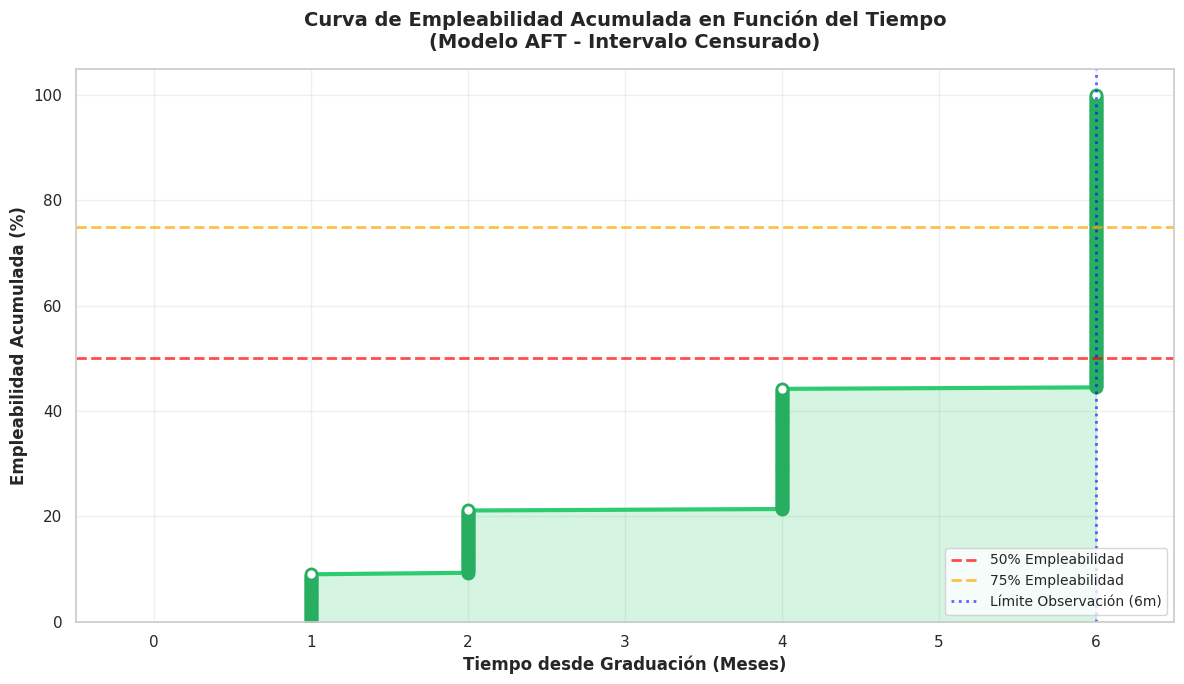

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Usar T_Lower y T_Upper según la definición AFT del documento
# NO convertir TARGET_Tiempo, usar directamente las columnas creadas

# Filtrar solo casos con empleo (Event=1)
df_empleabilidad = df_analisis[df_analisis['Event'] == 1].copy()
df_empleabilidad = df_empleabilidad.dropna(subset=['T_Lower', 'T_Upper'])

# Usar T_Upper como referencia temporal (límite superior del intervalo)
df_empleabilidad = df_empleabilidad.sort_values('T_Upper')

# Calcular empleabilidad acumulada
df_empleabilidad['Empleabilidad_Acumulada'] = np.arange(1, len(df_empleabilidad) + 1)
df_empleabilidad['Pct_Acumulado'] = (df_empleabilidad['Empleabilidad_Acumulada'] / len(df_empleabilidad) * 100)

# Visualización
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(df_empleabilidad['T_Upper'], df_empleabilidad['Pct_Acumulado'],
        linewidth=3, color='#2ecc71', marker='o', markersize=8,
        markerfacecolor='white', markeredgewidth=2, markeredgecolor='#27ae60')

ax.fill_between(df_empleabilidad['T_Upper'], 0, df_empleabilidad['Pct_Acumulado'],
                alpha=0.2, color='#2ecc71')

# Líneas de referencia
ax.axhline(50, color='red', linestyle='--', linewidth=2, alpha=0.7, label='50% Empleabilidad')
ax.axhline(75, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='75% Empleabilidad')

# Línea vertical en t=6 meses (límite de observación)
ax.axvline(6, color='blue', linestyle=':', linewidth=2, alpha=0.6, label='Límite Observación (6m)')

ax.set_xlabel('Tiempo desde Graduación (Meses)', fontsize=12, fontweight='bold')
ax.set_ylabel('Empleabilidad Acumulada (%)', fontsize=12, fontweight='bold')
ax.set_title('Curva de Empleabilidad Acumulada en Función del Tiempo\n(Modelo AFT - Intervalo Censurado)',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlim(-0.5, df_empleabilidad['T_Upper'].max() + 0.5)
ax.set_ylim(0, 105)
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)  # ← CORREGIDO (era ax.gri)

plt.tight_layout()
plt.savefig('08_empleabilidad_acumulada.png', dpi=300, bbox_inches='tight')
print("✅ [8/11] Curva de empleabilidad acumulada (AFT)")

# Estadísticas clave
print(f"\n📊 Estadísticas de Tiempo de Inserción (T_Upper):")
print(f"   • Mediana: {df_empleabilidad['T_Upper'].median():.1f} meses")
print(f"   • Media: {df_empleabilidad['T_Upper'].mean():.1f} meses")

# Porcentajes clave
insercion_inmediata = (df_empleabilidad['T_Upper'] <= 0.1).sum()
insercion_rapida = ((df_empleabilidad['T_Upper'] > 0.1) & (df_empleabilidad['T_Upper'] <= 6)).sum()
print(f"   • Inserción Anticipada (T≈0): {insercion_inmediata} ({insercion_inmediata/len(df_empleabilidad)*100:.1f}%)")
print(f"   • Inserción Post-Grado (0-6m): {insercion_rapida} ({insercion_rapida/len(df_empleabilidad)*100:.1f}%)")

=== ESTRUCTURA DE CENSURA ===
Event
1.0    355
0.0    310
Name: count, dtype: int64

Tasa de censura: 46.6%
Rango T_Upper: [1.0, 7.0] meses
✅ [13/18] Análisis de Censura Kaplan-Meier

📊 TEST LOG-RANK (Comparación entre Cohortes):
   • Estadístico χ²: 1.057
   • p-valor: 0.3040
   • Interpretación: No hay diferencias significativas entre cohortes

⏱️ TIEMPO MEDIANO DE INSERCIÓN:
   • Julio: 6.0 meses
   • Diciembre: 6.0 meses


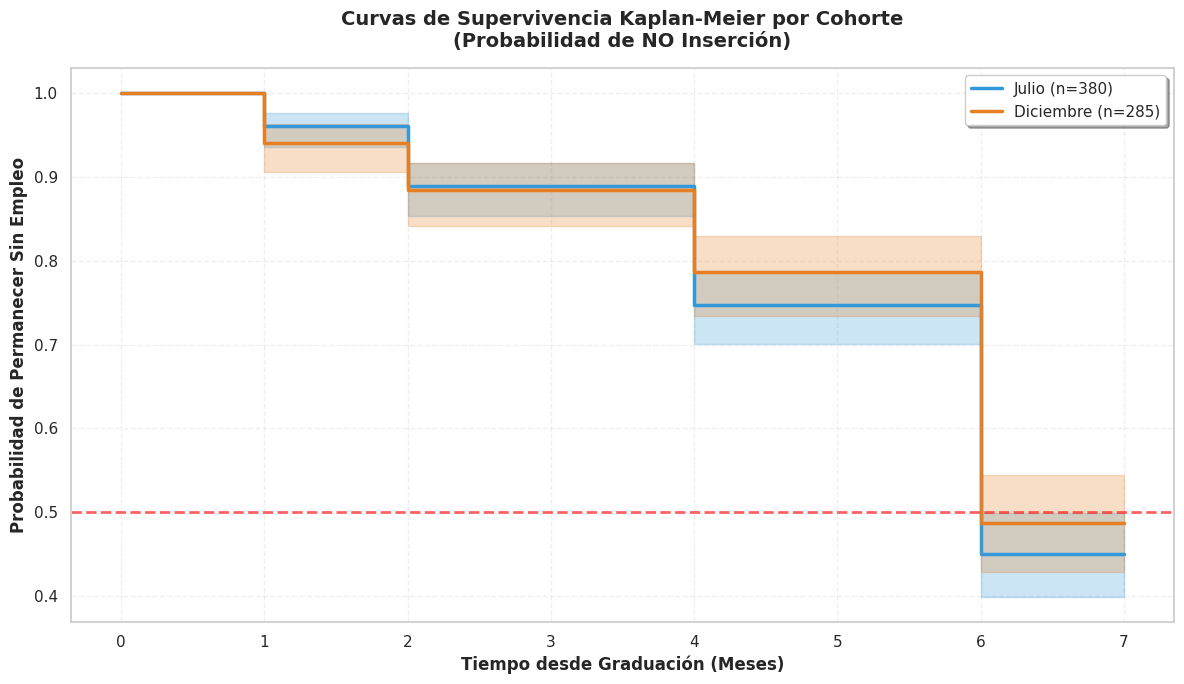

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import numpy as np

# ============================================================================
# PREPARACIÓN DE DATOS (ELIMINAR INF Y VALORES INVÁLIDOS)
# ============================================================================

df_km = df_base.copy()

# Reemplazar inf por el valor máximo observado + 1 (censura extrema)
max_valido = df_km[df_km['T_Upper'] != np.inf]['T_Upper'].max()
df_km['T_Upper_Clean'] = df_km['T_Upper'].replace(np.inf, max_valido + 1)

# Filtrar NaN
df_km = df_km.dropna(subset=['T_Upper_Clean', 'Event', 'Cohorte'])

print("=== ESTRUCTURA DE CENSURA ===")
print(df_km['Event'].value_counts())
print(f"\nTasa de censura: {(df_km['Event']==0).sum()/len(df_km)*100:.1f}%")
print(f"Rango T_Upper: [{df_km['T_Upper_Clean'].min():.1f}, {df_km['T_Upper_Clean'].max():.1f}] meses")

# ============================================================================
# CURVAS KAPLAN-MEIER POR COHORTE
# ============================================================================

kmf = KaplanMeierFitter()

fig, ax = plt.subplots(figsize=(12, 7))

colores = {'Julio': '#3498db', 'Diciembre': '#e67e22'}

for cohorte in df_km['Cohorte'].unique():
    mask = df_km['Cohorte'] == cohorte
    durations = df_km[mask]['T_Upper_Clean']
    events = df_km[mask]['Event']

    kmf.fit(durations, events, label=f'{cohorte} (n={mask.sum()})')
    kmf.plot_survival_function(ax=ax, ci_show=True,
                                color=colores.get(cohorte, 'gray'),
                                linewidth=2.5)

ax.set_xlabel('Tiempo desde Graduación (Meses)', fontsize=12, fontweight='bold')
ax.set_ylabel('Probabilidad de Permanecer Sin Empleo', fontsize=12, fontweight='bold')
ax.set_title('Curvas de Supervivencia Kaplan-Meier por Cohorte\n(Probabilidad de NO Inserción)',
             fontsize=14, fontweight='bold', pad=15)
ax.grid(alpha=0.3, linestyle='--')
ax.legend(loc='upper right', fontsize=11, frameon=True, shadow=True)

# Añadir línea de referencia en 50%
ax.axhline(0.5, color='red', linestyle='--', linewidth=2, alpha=0.6,
           label='50% Sin Empleo')

plt.tight_layout()
plt.savefig('13_kaplan_meier_cohortes.png', dpi=300, bbox_inches='tight')
print("✅ [13/18] Análisis de Censura Kaplan-Meier")

# ============================================================================
# TEST LOG-RANK (COMPARACIÓN ESTADÍSTICA)
# ============================================================================

from lifelines.statistics import multivariate_logrank_test

results = multivariate_logrank_test(
    df_km['T_Upper_Clean'],
    df_km['Cohorte'],
    df_km['Event']
)

print(f"\n📊 TEST LOG-RANK (Comparación entre Cohortes):")
print(f"   • Estadístico χ²: {results.test_statistic:.3f}")
print(f"   • p-valor: {results.p_value:.4f}")
print(f"   • Interpretación: {'Diferencias significativas' if results.p_value < 0.05 else 'No hay diferencias significativas'} entre cohortes")

# Mediana de supervivencia por cohorte
print(f"\n⏱️ TIEMPO MEDIANO DE INSERCIÓN:")
for cohorte in df_km['Cohorte'].unique():
    mask = df_km['Cohorte'] == cohorte
    kmf.fit(df_km[mask]['T_Upper_Clean'], df_km[mask]['Event'])
    mediana = kmf.median_survival_time_
    print(f"   • {cohorte}: {mediana:.1f} meses")

In [ ]:
df_analisis.to_csv('dataset_part1_analisis.csv')